# Ordinary Differential Equation Solver "Odie:" a Tutorial

## Authors: Gabriel M Steward

### January 2023

https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Template_Style_Guide.ipynb

Link to the Style Guide. Not internal in case something breaks. 

### </list_source_code> NRPy+ Source Code for this module:
[RK_Butcher_Table_Dictionary.py](/edit/RK_Butcher_Table_Dictionary.py)

[cmdline_helper.py](/edit/cmdline_helper.py)

[outputC.py](/edit/outputC.py)

## Introduction:
Welcome to the Ordinary Differential Equation Solver Tutorial notebook, wherin we will both showcase a program that solves Ordinary Differential Equations and instruct users on how to use it.

This Ordinary Differential Equation Solver, affectionately known as "Odie," takes a system of Ordinary Differential Equations (ODEs) with initial boundary conditions and solves it numerically. There are many ways to implement the code, but the primary method shown here produces a text file with the previously unknopwn functions' values. 

The code is generic and can use any Runge-Kutta-style method to solve the ODE, as well as Adams-Bashforth methods up to 19th order. There are a wide variety of methods pre-programmed into Odie, including some inherently adaptive Runge-Kutta methods, but if a user is able to provide a butcher table for a custom method the program can take that as well. 

All Runge-Kutta type methods can be run with adaptive timestep, where the program attempts to estimate the error and determine how far it can step and still maintain a user-set error tolerance. This is not available for Adams-Bashforth methods. All methods, including the inherently adaptive ones, can be run with a fixed time step option as well. 

Due to the way the program is segmented, it is possible to switch from adaptive to nonadaptive and from Runge-Kutta to Adams-Bashforth at will, depending on the user's desires. Switching methods is possible between every step.

Odie was designed with the intent of being a replcement for GSL's Ordinary Differential Equations solver in lalsuite, and as such the formatting for many of the functions is similar if not identical to GSL. However, the internal workings of ODIE are quite different from GSL.  

The code can be run entirely in either this jupyter notebook or as C-files. The C-file version has five files, four of which are the code itself, and the fifth is an example implementation that should be able to handle most systems of ODEs given to it. This jupyter notebook recreates the code in the C-files in full, however it does not split it up into five files but rather creates one large file to be run all at once. Each section is still clearly labeled, however, and the tutorial below will make it clear what goes where. 

If the user has no need for a tutorial and just wants to run the code, there is a section near the bottom of this notebook designed explicitly for user input, the Customization section ([Step 5a](#S5a) below). Here, the user can specify essentially everything ranging from the system of ODEs, to the termination condition, to the method type, to highly specific manipulation of error limiting parameters. In most cases this will involve directly modifying C-code, so reading the tutorial first is highly recommended. 

## </other>  Other:
A note: this notebook attempts to be a proper tutorial, but it is under construction, so suggestions are welcome. 

### Note on Notation:
Any new notation will be brought up in the notebook when it becomes relevant. 

### Citations:

Matplotlib documentation. (Needs no citation?) 

<a id='1'></a>
[1] https://en.wikibooks.org/wiki/C_Programming/time.h (Using time.h)

<a id='2'></a>
[2] https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h (math.h compilation requirements)

<a id='3'></a>
[3] https://www.tutorialspoint.com/cprogramming/c_file_io.htm (Basic file operations)

<a id='4'></a>
[4] Numerical Mathematics and Computing 6E by Cheney and Kincaid (Primary Text)

<a id='5'></a>
[5] NRPy+ "Solving the Scalar Wave Equation" (Plotting code, surprisingly)

<a id='6'></a>
[6] https://www.dataquest.io/blog/read-file-python/ (Opening and reading CSV files)

<a id='7'></a>
[7] https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib (Changing size of plot)

<a id='8'></a>
[8] https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c (Need to determine what we are being handed by the butcher tables.)

<a id='9'></a>
[9] https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine (how to move up out of a Python directory.)

<a id='10'></a>
[10] https://www.gnu.org/software/gsl/doc/html/intro.html (GSL algorithms)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

1. [Step 1:](#S1) Background: The Problem Statement

3. [Step 2:](#S2) The Code

    4. [Step 2a:](#S2a) Python Preliminary Code

    4. [Step 2b:](#S2b) Headers and Function Prototypes

    5. [Step 2c:](#S2c) Odie's Functions

    6. [Step 2d:](#S2d) User-Defined Functions
    
    6. [Step 2e:](#S2e) The Provided Main Function

3. [Step 3:](#S3) Simple Problem Example

    4. [Step 3a:](#S3a) Simple Problem Customization

    5. [Step 3b:](#S3b) Simple Problem Code Compilation

    6. [Step 3c:](#S3c) Simple Problem Results
    
    6. [Step 3d:](#S3d) Simple Problem Analysis
        
    6. [Step 3e:](#S3e) Multiple Run Examination
    
7. [Step 4:](#S4) Complicated Problem Example

    4. [Step 4a:](#S4a) Complicated Problem Customization

    4. [Step 4b:](#S4b) Complicated Problem Python-Code

    5. [Step 4c:](#S4c) Complicated Problem C-Code

    6. [Step 4d:](#S4d) Complicated Problem Results
    
    6. [Step 4e:](#S4e) Complicated Problem Analysis

7. [Step 5:](#S5) User-Defined Problem Section

    4. [Step 5a:](#S5a) Customization

    4. [Step 5b:](#S5b) Python-Code

    5. [Step 5c:](#S5c) C-Code

    6. [Step 5d:](#S5d) Results
    
    6. [Step 5e:](#S5e) Analysis

8. [Step 6:](#S6) Conclusion

8. [Step 7:](#S7) Questions/Ecercies(?)

9. [Step 8:](#S8) Output this notebook to $\LaTeX$-formatted PDF file

<a id='S1'></a>

# Step 1: Background: The Problem Statement \[Back to [top](#toc)\]
$$\label{S1}$$

#### In order to solve a problem, one must first know the problem exists.

Before we get into the code and instruct potential users on how to use it, we first need to specify exactly what sorts of problems it can solve. 

Odie seeks to take a system of Ordinary Differential Equations (ODEs) and solve it. To be clear, an ODE is an equation relating a function and its derivatives together, with the requirement that all derivatives be taken with respect to a single variable. If multiple variable derivatives are involved, it becoems a Partial Differential Equation. While the program only solves systems of first-order ODEs, every higher-order ODE can be split up into a system of first-order ODEs, thus the program can solve any order ODE so long as the user splits it up into a system first, which is always possible for ODEs. 

Mathematically, our program can solve equations of the form

$$ \frac{dy(x)}{dx} = f(x,y(x)) ; \text{ given } y(a)=b$$

where a system would take the form

$$ \frac{dy_n(x)}{dx} = f(x,y_n(x)) ; \text{ given } y_n(a)=b_n$$

where $f$ is some function that does not contain any derivative or integral operators. A solution is to find what the functions $y_n(x)$ actually are. The given $y_n(a)=b_n$ are the boundary conditions for the problem. For this solver we start at the point $a$ and increase it over time, treating $a$ as the start of an "initial condition." If the user wanted to evolve backward from some point, the system would just have to be flipped, replacing in this notation the parameter $x$ with $-x$. 

The program will restrict itself to Runge-Kutta and Adams-Bashforth type solution methods, which take an initial condition and evolve it forward in "time" with various relational methods. The specifics of these methods can be found elsewhere ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb)) (NOTE: the notebook may not be updated to include Adaptive Runge-Kutta and Adams-Bashforth methods). 

The basic idea is that one value is used to calculate another value forward in "time," and this new value can be used to find the next one, and so on and so forth. Since we start with an initial condition, we can always use such methods. 

Adams-Bashforth methods require multiple points in order to evaluate forward one step, but this can be solved by either using a Runge-Kutta method for the first few steps, or starting from the first order Adams-Bashforth method and increasing it over time. Both options are supported by Odie. 

<a id='S2'></a>

# Step 2: The Code \[Back to [top](#toc)\]
$$\label{S2}$$

#### Odie is our friend, but do we understand our friend?

Before looking at the code itself, lets first discuss how it operates. In the C-code, there are five different files: `nrpy_odiegm.h`, `nrpy_odiegm_proto.c`, `nrpy_odiegm_funcs.c`, `nrpy_odiegm_user_methods.c`, and `nrpy_odiegm_main.c`.

`nrpy_odiegm.h` and `nrpy_odiegm_proto.c` serve very similar purposes. `nrpy_odiegm.h` contians the definitions for all the struct "objects" used by Odie. It also contains all the butcher tables that come pre-installed with the program: 15 standard Runge-Kutta methods, 6 adaptive Runge-Kutta methods, and a table that stores all 19 Adams-Bashforth methods in one. Details about all these methods, their orders, and validaitions can be found elsewhere. ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb), once the push goes through) `nrpy_odiegm_proto.c` just contains function prototypes, separated from `nrpy_odiegm.h` for organization purposes. 

`nrpy_odiegm_funcs.c` contains the functions prototyped in `nrpy_odiegm_proto.c`. The functions in here are split into three types: allocation functions, freeing functions, and application functions. Allocation functions create the structs defined in `nrpy_odiegm.h` and fill them with proper values, managing memory if required. Freeing functions free the structs manually so there are no memory leaks. The majority of Odie is contained within the application functions. More precisely, `nrpy_odiegm_evolve_apply()`, the function that all the other application functions call at some point. What this function ultimately does is "evolve" the solution of a given system of ODEs forward one step, the result being a new set of values at some later point. 

The three files above are expected to never be touched by the user, always running in the background. This is not the case for `nrpy_odiegm_user_methods`, which contains the various functions the user is expected to define, including the system of ODEs. The majority of this tutorial will be concerned with how to properly edit and manage this file. In theory it is possible to run Odie without this file, but that will put a lot more weight on the user to come up with the exactly correct format of functions. This template will make things much simpler. It does not depend on anything in the previous three files. 

The last file, `nrpy_odiegm_main.c`, is not actually part of the Odie program, but actually an example file provided that can handle almost any differential equation passed to it, and it is prepared in such a way that it can even evaluate hybrid methods. It is not the most efficient possible program, as it performs a lot of checks to tell what it's supposed to be doing at any given time, so if efficeincy is the name of the game the user should define their own main. 

We will go through each of these files and build them up in turn, though if a user just wants to know how to use Odie and not the inner workings of how the solver works, then it is recommended to skip past the headers and function declarations to the `nrpy_odiegm_user_methods` section, as that is where the user will most likely interface with the program. It is, however, important to run all the code in this notebook section (Step 2) every time, as it declares many things that will be used extensively later. 

<a id='S2a'></a>

## Step 2a: Python Preliminary Code \[Back to [top](#toc)\]
$$\label{S2a}$$

#### So, you want to run C-code in a ipykernel notebook? 

In order to run Odie, which is a C-code, from within this jupyter notebook, we will need to rely on NRPy+'s C-code generation libraries. This notebook, while it is a tutorial, is not concerned with explaining the ins and outs of how to do this, that can be found in the various nrpytutorial notebooks. 

In [1]:
import outputC as outC       #NRPy+: Core C code output module.
import cmdline_helper as cmd #NRPy+: Multi-platform Python command-line interface
import os                    #Python: Miscellaneous operating system interfaces
import shutil                #Python: High level file operations

# https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb

#Create a C code output directory
#First, name it.
Ccodesrootdir = os.path.join("nrpy_odiegm_notebook_codes/")
#Remove any previously existing files there.
shutil.rmtree(Ccodesrootdir,ignore_errors=True)
#Create the fresh directory. 
cmd.mkdir(Ccodesrootdir)

<a id='S2b'></a>

## Step 2b: Headers and Function Prototypes \[Back to [top](#toc)\]
$$\label{S2b}$$

#### Taking it From the top

**It is highly recommended for users who don't need to understand the inner workings of the program to skip this section and go to Step 2d**

We will create our C-code in the form of python strings. These strings will then be passed to NRPy+'s C-compiling functions to create the code that will actually be run. Let's start with `nrpy_odiegm.h`, as it is arguably the "highest" of the files. 

We use `r""" """` format to make sure any special characters won't split up the python string inadvertently. We are putting code in a different language inside it after all. 

In [2]:
nrpy_odiegm_h = r"""
//#include <stdio.h>
//#include <stdlib.h>
//#include <math.h>
//#include <stdbool.h>

//Note: math.h requries the "-lm" arg be added at the END of tasks.json's arguments.
//https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

//ODE Solver "Odie"
//By G. M. Steward
//The main goal of this project is to solve Ordinary Differential Equation Systems
//in complete generality. However, we will take a while to get there.
//This tenth version seeks to make this code functional as a drop-in replacement for GSL's solver. 

//Heavily influenced by Numerical Mathematics and Computing 6E by Cheney and Kincaid.
//and GSL's ODE Solver, especially the method for adaptive time step and high-level funcitonality. 

//https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRTEOBResumS.c
//Lalsuite section for what parts of GSL this was designed to replace. 

//This is the header file for Odie. 
//It contains the structure definitions. 
//The structs are defined below largely in accordance with GSL definitions. 
//However, unecessary variables were removed, and a handful were repurposed. 
//Butcher tables can be found at the bottom of this file. 
//Function prototypes can be found in nrpy_odiegm_proto.c
"""

Note that the above is all comments, just the introductory parts to the program. However, one might find it odd that the `#include` markers are commented out. This is because NRPy+ will add those later--Odie really does depend on stdio.h, stdlib.h, math.h, and stdbool.h. It doesn't depend on anything else, though. 

With that, we add to our header a struct definition. 

In [3]:
nrpy_odiegm_h = nrpy_odiegm_h + r"""

typedef struct {
    int (*function) (double x, double y[], double dydx[], void *params);
    //The function passed to this struct contains the definitions of the differnetial equations. 
    //int (*jacobian) (double t, const double y[], double *dfdy, double dfdt[], void *params); 
    //The Jacobian is a holdover from GSL, it will not be used in this program.
    int (*trueFunction) (double x, double y[]);
    //INSTEAD we will use the Jacobian's slot slot to allow passing of a true value! 
    //Naturally, this is only if desired.
    size_t dimension; //For storing how big our system of equations is. 
    //Just pass it an int, usually. 
    void *params; //For storing extra constants needed to evaluate the functions. 
    //params->dimension stores how many there are. Can be found in user_methods
} nrpy_odiegm_system;
"""

Odie was partially designed to be a replacement for GSL's Ordinary Differential Equations Solver as it was used in lalsuite. AS such, it was required that many structs be created that were in-line with GSL's function implementation, even if the interior of said structures was different than intended. 

The struct above is the `system` struct, the one that holds the system of equations. `*function` points to the C-function that holds the system of ODEs that will be found in `nrpy_odiegm_user_methods.c`. `*trueFunction` holds what the "true solution" of the system of equations is, if it is known, otherwise it points to nothing. `dimension` simply reports how many equations are in the system, and `*params` can be used for any number of things but its intended use is to hold constants that are related to quantities in the system of ODEs, but not through differential equations. Such as, say, reporting density when the system itself only evolved pressure ad mass. 

In [4]:
nrpy_odiegm_h = nrpy_odiegm_h + r"""

typedef struct {
    //unlike with the system object above, this step_type object does not need
    //to match GSL's form explicitly, it just needs to define the method.
    int rows; 
    int columns; //Size of table for used method.
    //Since we're dealing with void pointers we need a way to know how big everything is. 
    int order; //record the order.
    //These are set in butcher.c.
    void *butcher;
    //Make sure to put this at the end of the struct,
    //in case we add more parts to it. Nonspecific arrays must be the last element.

    //Two of these step_type "objects" might be needed at once, depending on implementation. 
    //Fortunately you can make as many as you want. 
} nrpy_odiegm_step_type;
"""

This is the `step_type` struct, which holds the butcher table to either an Runge-Kutta (RK) or Adams-Bashforth (AB) method. The table itself is held in `*butcher`, but the `step_type` has variables `rows`, `columns`, and `order` to make it easier to access how big the table is and what order the method it holds is. Since `*butcher` is a void pointer, it's important to know how big the array is through `rows` and `columns` so we can actually cycle through its values properly. 

In [5]:
nrpy_odiegm_h = nrpy_odiegm_h + r"""

typedef struct {
  const nrpy_odiegm_step_type *type; 
  int rows; 
  int columns; //since we are passing a void pointer to do this, we need a way
  //to know how large it is in the end.
  //purposefully redundant with step_type's rows and columns value. 
  int methodType; //What type of method we are using. 0,1,2 values. 
  int adamsBashforthOrder; //order if an AB method is used.
  void *yValues; //The extremely funky parameter that hides a 2D array, used when
  //the past steps are important for AB method.  
  //Stored in step since it needs access to adamsBashforthOrder for allocation.
} nrpy_odiegm_step;

typedef struct {
    //Various error parameters
    double absLim; //absolute error limiter
    double relLim; //relative error limiter
    double scaleFactor; //a scale factor used in the error comparison formula.
    double errorSafety; //a factor that limits how drastically things can change for stability.
    double ayErrorScaler; //weight given to error estimates related to the function itself.
    double adyErrorScaler; //weight given to error estimates related to the function's derivative.
    double maxStepAdjustment; //What is the largest step adjustment we'll allow?
    double minStepAdjustment; //What ist he smallest step adjustment we'll allow?
    double absoluteMaxStep; //Largest allowed step?
    double absoluteMinStep; //Smallest allowed step?
    double errorUpperTolerance; //If estimated error is higher than this, it is too high. 
    double errorLowerTolerance; //If estimated error is lower than this, it is too low.
    //We added these ourselves. Control the error!
    //we suppose this means that our control object acts NOTHING like GSL's control object
    //save that it stores error limits. 
} nrpy_odiegm_control;

typedef struct
{
  double *y0; //the values of the system of equations
  double *yerr; //the estimated errors, if needed. 
  //double *dydt_in;
  //double *dydt_out; //These two values are not used as we are not using Jacobian methods. 
  double last_step; //Set to 1 when we are at the last step.
  //Probably not used but the user may want it for some reason. 
  //Could be used as a termination condition. 
  double bound; //the point at which we started is sometimes important. 
  double currentPosition; //It's a good idea to know where we are at any given time. 
  unsigned long int count; //equivalent to i. Keeps track of steps taken.
  //unsigned long int failed_steps; //we automatically handle tossing out "bad" steps.
  bool noAdaptiveTimestep; //a simple toggle for forcing the steps to be the same or not.
} nrpy_odiegm_evolve;

"""

These three structs, `step`, `control`, and `evolve` are the "primary actors" of Odie, as they actually do most of the heavy lifting. `step` is concerned with holding the `step_type` as well as managing what kind of steps should be taken, in addition to an array that can store past values between iterations in case those are needed, which they are for AB reasons. Its role is admittedly somewhat niche. 

`step` contains a `step_type` simply called `type` as well as `rows` and `columns` that are just repeated instances of the values in `step_type` to make things easy to access. `methodType` tells Odie if it's using an RK, Adaptive RK, or AB method at the moment. `adamsBashforthOrder` tells the program what kind of AB method it is using, while `yValues` is a mysteirous array used to store past values of points for AB methods. 

Keep in mind that for all the structs, the user genreally doesn't have to define all the parameters directly, they will be filled automatically; they are merely here if the user *does* want to manipulate them. 

`control`, on the other hand, has a much more defined role in the program: it holds the values used for error analysis and adaptive timestep. `control` isn't even used in situations where adaptive timestep isn't taken, but when it is taken, the dozen or so values in here all allow for fine-tuning of how exactly the adaptive time step should be managed. 

Many of `control`'s parameters are error related and not generally something the user will mess with, but here they are anyway. `absLim` is an imposed limit on the estimated absolute error, `relLim` is the same except for the estimated relative error. `scaleFactor` is a number that is used to compare various errors, and `errorSafety` is a factor that limits how drastically things can change at once to keep results stable. `ayErrrorScaler` determines how much of the estimated relative error is weighted toward the functions themselves, while `adyErrorScaler` places weight on the derivative. The next four parameters, `maxStepAdjustment`, `minStepAdjustment`, `absoluteMaxStep`, and `absoluteMinStep` all put limits on how much the step size can change. The first two put limits on how far the step can be adjusted when taking one step, while the latter two put global maximums and minimums. Lastly, we have `upperErrorTolerance` abd `lowerErrorTolerance`. These two tell the program how big or small the error has to be in order to trigger adaptive stepsize--if neither is triggered, the program pushes forward without changing the step size. 

the math of the `control` struct is based on GSL's implemetnations of error, albeit with more options for freedom. It may be more illuminating to write out what's going on mathematically. First, we calculate a desired error. 

$$ D = absLim + relLim * (ayErrorScaler|y| + adyErrorScaler|y'|) $$

Where y and y' are our current proposed points after taking a step. The $D$ we calculate is a "desired error." In the case where there are multiple equations in the system of ODEs, a D is calculated for each one. Note that absLim and relLim add together, so if both absolute and relative errors contribute a lot to our error, the overall D result will be higher. We also create an estimated error based on the behavior of the results:

$$ E = |y_1 - y_2| * errorSafety $$

Where $y_1$ and $y_2$ are just two different guesses, one of which is the y used in calculating D. This seems primitive but by examining the difference we can estimate how much error occurs in general, with the `errorSafety` term being able to make up for our uncertainty. GSL sets `errorSafety` to 4/15 by default, so that's what we do as well. 

After this, we analyze the ratio E/D for each equation in the system of ODEs, picking the largest one. If it is greater than `upperErrorToleranece` we go on to increase the step size. If it is lower than `lowerErrorTolwerance` we go on to decrease it. If it is in between them, we do neither. 

The actual adjustment formulae are as follows, with q being the order of the method being used. 

$$ h_{smaller} = h_{old} * scaleFactor * (E/D)^{-1/q} $$

$$ h_{bigger} = h_{old} * scaleFactor * (E/D)^{-1/(q+1)} $$

The `scaleFactor` is 0.9 by default in GSL, and so it is here. 

`evolve` is the struct that "evolves" or "extrapolates" the System of ODEs and stores the values found for the next iteration. It also stores estimated errors to pass to `control` or to let the user report them. 

Specifically, it contains `*y0`, which is the actual solution calculated for the next step. It also has `*yerr` which holds the errors. `last_step` is a paraemter rarely used but which can be helpful in making sure an sequence of steps stops a a very specific value and lets the user know that it's ready to stop early. `bound` and `currentPosition` are two very helpful numbers that record where the first step started and where the stepper currently is, respectively. `count` just keeps track of how many steps have been eprformed, while `noAdaptiveTimestep` is a toggle that allows the adaptive timesteppers to be turned on or off at will. If `true`, the same step size will be taken every time. 

In [6]:
nrpy_odiegm_h = nrpy_odiegm_h + r"""

typedef struct {
    const nrpy_odiegm_system *sys; /* ODE system */
    nrpy_odiegm_evolve *e;         /* evolve object */
    nrpy_odiegm_control *c;         /* control object */
    nrpy_odiegm_step *s;          /* step object, will contain step type */
    double h;                     /* step size */
    //Curiously, this is where the step size is held. Usually it's passed to functions directly though. 
} nrpy_odiegm_driver;

"""

The last struct here is the `driver`, one that holds all the others for conveience, so the entire machinery of Odie can be activated by dealing with one thing. It also contains the step size itself since the `driver` is capable of doing multiple steps at once without management from the user. 

With all the structs, the last part of the header file is a very long list of butcher tables that are used to define the various methods for solving the system of ODEs. 

In [7]:
nrpy_odiegm_h = nrpy_odiegm_h + r"""

//A collection of butcher tables, courtesy of NRPy+.
//This section just has definitions. 
//Specifically of all the various kinds of stepper methods we have on offer. 

double butcherEuler[2][2] = {{0.0,0.0},{1.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_euler0 = {2,2,1,&butcherEuler};
const nrpy_odiegm_step_type *nrpy_odiegm_step_euler = &nrpy_odiegm_step_euler0;

double butcherRK2H[3][3] = {{0.0,0.0,0.0},{1.0,1.0,0.0},{2.0,1.0/2.0,1.0/2.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_Heun0 = {3,3,2,&butcherRK2H};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_Heun = &nrpy_odiegm_step_RK2_Heun0;

double butcherRK2MP[3][3] = {{0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0},{2.0,0.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_MP0 = {3,3,2,&butcherRK2MP};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_MP = &nrpy_odiegm_step_RK2_MP0;

double butcherRK2R[3][3] = {{0.0,0.0,0.0},{2.0/3.0,2.0/3.0,0.0},{2.0,1.0/4.0,3.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK2_R0 = {3,3,2,&butcherRK2R};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK2_Ralston = &nrpy_odiegm_step_RK2_R0;

double butcherRK3[4][4] = {{0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0},{1.0,-1.0,2.0,0.0},{3.0,1.0/6.0,2.0/3.0,1.0/6.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_0 = {4,4,3,&butcherRK3};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3 = &nrpy_odiegm_step_RK3_0;

double butcherRK3H[4][4] = {{0.0,0.0,0.0,0.0},{1.0/3.0,1.0/3.0,0.0,0.0},{2.0/3.0,0.0,2.0/3.0,0.0},{3.0,1.0/4.0,0.0,3.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_H0 = {4,4,3,&butcherRK3H};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3_Heun = &nrpy_odiegm_step_RK3_H0;

double butcherRK3R[4][4] = {{0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0},{3.0/4.0,0.0,3.0/4.0,0.0},{3.0,2.0/9.0,1.0/3.0,4.0/9.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_R0 = {4,4,3,&butcherRK3R};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK3_Ralston = &nrpy_odiegm_step_RK3_R0;

double butcherRK3S[4][4] = {{0.0,0.0,0.0,0.0},{1.0,1.0,0.0,0.0},{1.0/2.0,1.0/4.0,1.0/4.0,0.0},{3.0,1.0/6.0,1.0/6.0,2.0/3.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK3_S0 = {4,4,3,&butcherRK3S};
const nrpy_odiegm_step_type *nrpy_odiegm_step_SSPRK3 = &nrpy_odiegm_step_RK3_S0;

double butcherRK4[5][5] = {{0.0,0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0,0.0},{1.0/2.0,0.0,1.0/2.0,0.0,0.0},{1.0,0.0,0.0,1.0,0.0},{4.0,1.0/6.0,1.0/3.0,1.0/3.0,1.0/6.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_RK4_0 = {5,5,4,&butcherRK4};
const nrpy_odiegm_step_type *nrpy_odiegm_step_RK4 = &nrpy_odiegm_step_RK4_0;
//This alternate name is declared for gsl drop in requirements. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk4 = &nrpy_odiegm_step_RK4_0;

double butcherDP5[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0,0.0},{4.0/5.0,44.0/45.0,-56.0/15.0,32.0/9.0,0.0,0.0,0.0,0.0},{8.0/9.0,19372.0/6561.0,-25360.0/2187.0,64448.0/6561.0,-212.0/729.0,0.0,0.0,0.0},{1.0,9017.0/3168.0,-355.0/33.0,46732.0/5247.0,49.0/176.0,-5103.0/18656.0,0.0,0.0},{1.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP5_0 = {8,8,5,&butcherDP5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP5 = &nrpy_odiegm_step_DP5_0;

double butcherDP5A[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/10.0,1.0/10.0,0.0,0.0,0.0,0.0,0.0,0.0},{2.0/9.0,-2.0/81.0,20.0/81.0,0.0,0.0,0.0,0.0,0.0},{3.0/7.0,615.0/1372.0,-270.0/343.0,1053.0/1372.0,0.0,0.0,0.0,0.0},{3.0/5.0,3243.0/5500.0,-54.0/55.0,50949.0/71500.0,4998.0/17875.0,0.0,0.0,0.0},{4.0/5.0,-26492.0/37125.0,72.0/55.0,2808.0/23375.0,-24206.0/37125.0,338.0/459.0,0.0,0.0},{1.0,5561.0/2376.0,-35.0/11.0,-24117.0/31603.0,899983.0/200772.0,-5225.0/1836.0,3925.0/4056.0,0.0},{5.0,821.0/10800.0,0.0,19683.0/71825.0,175273.0/912600.0,395.0/3672.0,785.0/2704.0,3.0/50.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP5A_0 = {8,8,5,&butcherDP5A};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP5alt = &nrpy_odiegm_step_DP5A_0;

double butcherCK5[7][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0},{3.0/5.0,3.0/10.0,-9.0/10.0,6.0/5.0,0.0,0.0,0.0},{1.0,-11.0/54.0,5.0/2.0,-70.0/27.0,35.0/27.0,0.0,0.0},{7.0/8.0,1631.0/55296.0,175.0/512.0,575.0/13824.0,44275.0/110592.0,253.0/4096.0,0.0},{5.0,37.0/378.0,0.0,250.0/621.0,125.0/594.0,0.0,512.0/1771.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_CK5_0 = {7,7,5,&butcherCK5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_CK5 = &nrpy_odiegm_step_CK5_0;

double butcherDP6[9][9] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/10.0,1.0/10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{2.0/9.0,-2.0/81.0,20.0/81.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/7.0,615.0/1372.0,-270.0/343.0,1053.0/1372.0,0.0,0.0,0.0,0.0,0.0},{3.0/5.0,3243.0/5500.0,-54.0/55.0,50949.0/71500.0,4998.0/17875.0,0.0,0.0,0.0,0.0},{4.0/5.0,-26492.0/37125.0,72.0/55.0,2808.0/23375.0,-24206.0/37125.0,338.0/459.0,0.0,0.0,0.0},{1.0,5561.0/2376.0,-35.0/11.0,-24117.0/31603.0,899983.0/200772.0,-5225.0/1836.0,3925.0/4056.0,0.0,0.0},{1.0,465467.0/266112.0,-2945.0/1232.0,-5610201.0/14158144.0,10513573.0/3212352.0,-424325.0/205632.0,376225.0/454272.0,0.0,0.0},{6.0,61.0/864.0,0.0,98415.0/321776.0,16807.0/146016.0,1375.0/7344.0,1375.0/5408.0,-37.0/1120.0,1.0/10.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP6_0 = {9,9,6,&butcherDP6};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP6 = &nrpy_odiegm_step_DP6_0;

//This one is left in terms of floating points, as the form stored in 
//the butcher table includes irrational numbers and other stuff. 
//double butcherL6[8][8] = {{0.0,0,0,0,0,0,0,0},{1.0,1.0,0,0,0,0,0,0},{0.5,0.375,0.125,0,0,0,0,0},{0.6666666666666666,0.2962962962962963,0.07407407407407407,0.2962962962962963,0,0,0,0},{0.17267316464601143,0.051640768506639186,-0.04933518989886041,0.2960111393931624,-0.1256435533549298,0,0,0},{0.8273268353539885,-1.1854881643947648,-0.2363790958154253,-0.7481756236662596,0.8808545802392703,2.116515138991168,0,0},{1.0,4.50650248872424,0.6666666666666666,6.017339969931307,-4.111704479703632,-7.018914097580199,0.9401094519616178,0},{6.0,0.05,0.0,0.35555555555555557,0.0,0.2722222222222222,0.2722222222222222,0.05}};
//const double sqrt21 = 4.58257569495584; //explicitly declared to avoid the funky problems with consts. 
//Manually added to the below definition since visual studio complained sqrt21 wasn't a constant.
double butcherL6[8][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/2.0,3.0/8.0,1.0/8.0,0.0,0.0,0.0,0.0,0.0},{2.0/3.0,8.0/27.0,2.0/27.0,8.0/27.0,0.0,0.0,0.0,0.0},{1.0/2.0 - 4.58257569495584/14.0,-3.0/56.0 + 9.0*4.58257569495584/392.0,-1.0/7.0 + 4.58257569495584/49.0,6.0/7.0 - 6.0*4.58257569495584/49.0,-9.0/56.0 + 3.0*4.58257569495584/392.0,0.0,0.0,0.0},{4.58257569495584/14.0 + 1.0/2.0,-51.0*4.58257569495584/392.0 - 33.0/56.0,-1.0/7.0 - 4.58257569495584/49.0,-8.0*4.58257569495584/49.0,9.0/280.0 + 363.0*4.58257569495584/1960.0,4.58257569495584/5.0 + 6.0/5.0,0.0,0.0},{1.0,11.0/6.0 + 7.0*4.58257569495584/12.0,2.0/3.0,-10.0/9.0 + 14.0*4.58257569495584/9.0,7.0/10.0 - 21.0*4.58257569495584/20.0,-343.0/90.0 - 7.0*4.58257569495584/10.0,49.0/18.0 - 7.0*4.58257569495584/18.0,0.0},{6.0,1.0/20.0,0.0,16.0/45.0,0.0,49.0/180.0,49.0/180.0,1.0/20.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_L6_0 = {8,8,6,&butcherL6};
const nrpy_odiegm_step_type *nrpy_odiegm_step_L6 = &nrpy_odiegm_step_L6_0;

double butcherDP8[14][14] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/18.0,1.0/18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/12.0,1.0/48.0,1.0/16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/8.0,1.0/32.0,0.0,3.0/32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{5.0/16.0,5.0/16.0,0.0,-75.0/64.0,75.0/64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/80.0,0.0,0.0,3.0/16.0,3.0/20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{59.0/400.0,29443841.0/614563906.0,0.0,0.0,77736538.0/692538347.0,-28693883.0/1125000000.0,23124283.0/1800000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{93.0/200.0,16016141.0/946692911.0,0.0,0.0,61564180.0/158732637.0,22789713.0/633445777.0,545815736.0/2771057229.0,-180193667.0/1043307555.0,0.0,0.0,0.0,0.0,0.0,0.0},{5490023248.0/9719169821.0,39632708.0/573591083.0,0.0,0.0,-433636366.0/683701615.0,-421739975.0/2616292301.0,100302831.0/723423059.0,790204164.0/839813087.0,800635310.0/3783071287.0,0.0,0.0,0.0,0.0,0.0},{13.0/20.0,246121993.0/1340847787.0,0.0,0.0,-37695042795.0/15268766246.0,-309121744.0/1061227803.0,-12992083.0/490766935.0,6005943493.0/2108947869.0,393006217.0/1396673457.0,123872331.0/1001029789.0,0.0,0.0,0.0,0.0},{1201146811.0/1299019798.0,-1028468189.0/846180014.0,0.0,0.0,8478235783.0/508512852.0,1311729495.0/1432422823.0,-10304129995.0/1701304382.0,-48777925059.0/3047939560.0,15336726248.0/1032824649.0,-45442868181.0/3398467696.0,3065993473.0/597172653.0,0.0,0.0,0.0},{1.0,185892177.0/718116043.0,0.0,0.0,-3185094517.0/667107341.0,-477755414.0/1098053517.0,-703635378.0/230739211.0,5731566787.0/1027545527.0,5232866602.0/850066563.0,-4093664535.0/808688257.0,3962137247.0/1805957418.0,65686358.0/487910083.0,0.0,0.0},{1.0,403863854.0/491063109.0,0.0,0.0,-5068492393.0/434740067.0,-411421997.0/543043805.0,652783627.0/914296604.0,11173962825.0/925320556.0,-13158990841.0/6184727034.0,3936647629.0/1978049680.0,-160528059.0/685178525.0,248638103.0/1413531060.0,0.0,0.0},{8.0,14005451.0/335480064.0,0.0,0.0,0.0,0.0,-59238493.0/1068277825.0,181606767.0/758867731.0,561292985.0/797845732.0,-1041891430.0/1371343529.0,760417239.0/1151165299.0,118820643.0/751138087.0,-528747749.0/2220607170.0,1.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_DP8_0 = {14,14,8,&butcherDP8};
const nrpy_odiegm_step_type *nrpy_odiegm_step_DP8 = &nrpy_odiegm_step_DP8_0;

//Adaptive Methods
double butcherAHE[4][3] = {{0.0,0.0,0.0},{1.0,1.0,0.0},{2.0,1.0/2.0,1.0/2.0},{2.0,1.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_AHE_0 = {4,3,2,&butcherAHE};
const nrpy_odiegm_step_type *nrpy_odiegm_step_AHE = &nrpy_odiegm_step_AHE_0;
//This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk2 = &nrpy_odiegm_step_AHE_0;

double butcherABS[6][5] = {{0.0,0.0,0.0,0.0,0.0},{1.0/2.0,1.0/2.0,0.0,0.0,0.0},{3.0/4.0,0.0,3.0/4.0,0.0,0.0},{1.0,2.0/9.0,1.0/3.0,4.0/9.0,0.0},{3.0,2.0/9.0,1.0/3.0,4.0/9.0,0.0},{3.0,7.0/24.0,1.0/4.0,1.0/3.0,1.0/8.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ABS_0 = {6,5,3,&butcherABS};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ABS = &nrpy_odiegm_step_ABS_0;

double butcherARKF[8][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/4.0,1.0/4.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/32.0,9.0/32.0,0.0,0.0,0.0,0.0},{12.0/13.0,1932.0/2197.0,-7200.0/2197.0,7296.0/2197.0,0.0,0.0,0.0},{1.0,439.0/216.0,-8.0,3680.0/513.0,-845.0/4104.0,0.0,0.0},{1.0/2.0,-8.0/27.0,2.0,-3544.0/2565.0,1859.0/4104.0,-11.0/40.0,0.0},{5.0,16.0/135.0,0.0,6656.0/12825.0,28561.0/56430.0,-9.0/50.0,2.0/55.0},{5.0,25.0/216.0,0.0,1408.0/2565.0,2197.0/4104.0,-1.0/5.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ARKF_0 = {8,7,5,&butcherARKF};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ARKF = &nrpy_odiegm_step_ARKF_0;
//This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rkf45 = &nrpy_odiegm_step_ARKF_0;

double butcherACK[8][7] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0},{3.0/5.0,3.0/10.0,-9.0/10.0,6.0/5.0,0.0,0.0,0.0},{1.0,-11.0/54.0,5.0/2.0,-70.0/27.0,35.0/27.0,0.0,0.0},{7.0/8.0,1631.0/55296.0,175.0/512.0,575.0/13824.0,44275.0/110592.0,253.0/4096.0,0.0},{5.0,37.0/378.0,0.0,250.0/621.0,125.0/594.0,0.0,512.0/1771.0},{5.0,2825.0/27648.0,0.0,18575.0/48384.0,13525.0/55296.0,277.0/14336.0,1.0/4.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ACK_0 = {8,7,5,&butcherACK};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ACK = &nrpy_odiegm_step_ACK_0;
//This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rkck = &nrpy_odiegm_step_ACK_0;

double butcherADP5[9][8] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/5.0,1.0/5.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/10.0,3.0/40.0,9.0/40.0,0.0,0.0,0.0,0.0,0.0},{4.0/5.0,44.0/45.0,-56.0/15.0,32.0/9.0,0.0,0.0,0.0,0.0},{8.0/9.0,19372.0/6561.0,-25360.0/2187.0,64448.0/6561.0,-212.0/729.0,0.0,0.0,0.0},{1.0,9017.0/3168.0,-355.0/33.0,46732.0/5247.0,49.0/176.0,-5103.0/18656.0,0.0,0.0},{1.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,35.0/384.0,0.0,500.0/1113.0,125.0/192.0,-2187.0/6784.0,11.0/84.0,0.0},{5.0,5179.0/57600.0,0.0,7571.0/16695.0,393.0/640.0,-92097.0/339200.0,187.0/2100.0,1.0/40.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ADP5_0 = {9,8,5,&butcherADP5};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ADP5 = &nrpy_odiegm_step_ADP5_0;

double butcherADP8[15][14] = {{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/18.0,1.0/18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/12.0,1.0/48.0,1.0/16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{1.0/8.0,1.0/32.0,0.0,3.0/32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{5.0/16.0,5.0/16.0,0.0,-75.0/64.0,75.0/64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{3.0/8.0,3.0/80.0,0.0,0.0,3.0/16.0,3.0/20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{59.0/400.0,29443841.0/614563906.0,0.0,0.0,77736538.0/692538347.0,-28693883.0/1125000000.0,23124283.0/1800000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0},{93.0/200.0,16016141.0/946692911.0,0.0,0.0,61564180.0/158732637.0,22789713.0/633445777.0,545815736.0/2771057229.0,-180193667.0/1043307555.0,0.0,0.0,0.0,0.0,0.0,0.0},{5490023248.0/9719169821.0,39632708.0/573591083.0,0.0,0.0,-433636366.0/683701615.0,-421739975.0/2616292301.0,100302831.0/723423059.0,790204164.0/839813087.0,800635310.0/3783071287.0,0.0,0.0,0.0,0.0,0.0},{13.0/20.0,246121993.0/1340847787.0,0.0,0.0,-37695042795.0/15268766246.0,-309121744.0/1061227803.0,-12992083.0/490766935.0,6005943493.0/2108947869.0,393006217.0/1396673457.0,123872331.0/1001029789.0,0.0,0.0,0.0,0.0},{1201146811.0/1299019798.0,-1028468189.0/846180014.0,0.0,0.0,8478235783.0/508512852.0,1311729495.0/1432422823.0,-10304129995.0/1701304382.0,-48777925059.0/3047939560.0,15336726248.0/1032824649.0,-45442868181.0/3398467696.0,3065993473.0/597172653.0,0.0,0.0,0.0},{1.0,185892177.0/718116043.0,0.0,0.0,-3185094517.0/667107341.0,-477755414.0/1098053517.0,-703635378.0/230739211.0,5731566787.0/1027545527.0,5232866602.0/850066563.0,-4093664535.0/808688257.0,3962137247.0/1805957418.0,65686358.0/487910083.0,0.0,0.0},{1.0,403863854.0/491063109.0,0.0,0.0,-5068492393.0/434740067.0,-411421997.0/543043805.0,652783627.0/914296604.0,11173962825.0/925320556.0,-13158990841.0/6184727034.0,3936647629.0/1978049680.0,-160528059.0/685178525.0,248638103.0/1413531060.0,0.0,0.0},{8.0,14005451.0/335480064.0,0.0,0.0,0.0,0.0,-59238493.0/1068277825.0,181606767.0/758867731.0,561292985.0/797845732.0,-1041891430.0/1371343529.0,760417239.0/1151165299.0,118820643.0/751138087.0,-528747749.0/2220607170.0,1.0/4.0},{8.0,13451932.0/455176623.0,0.0,0.0,0.0,0.0,-808719846.0/976000145.0,1757004468.0/5645159321.0,656045339.0/265891186.0,-3867574721.0/1518517206.0,465885868.0/322736535.0,53011238.0/667516719.0,2.0/45.0,0.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_ADP8_0 = {15,14,8,&butcherADP8};
const nrpy_odiegm_step_type *nrpy_odiegm_step_ADP8 = &nrpy_odiegm_step_ADP8_0;
//This alternate name is declared because of the need for GSL drop in. 
const nrpy_odiegm_step_type *nrpy_odiegm_step_rk8pd = &nrpy_odiegm_step_ADP8_0;

//Adams-Bashforth Method. Could be set to arbitrary size, but we chose 19. 
//Should never need all 19.
double butcherAB[19][19] = {{333374427829017307697.0/51090942171709440000.0,-5148905233415267713.0/109168679854080000.0,395276943631267674287.0/1548210368839680000.0,-2129159630108649501931.0/2128789257154560000.0,841527158963865085639.0/283838567620608000.0,-189774312558599272277.0/27646613729280000.0,856822959645399341657.0/67580611338240000.0,-13440468702008745259589.0/709596419051520000.0,196513123964380075325537.0/8515157028618240000.0,-57429776853357830333.0/2494674910728000.0,53354279746900330600757.0/2838385676206080000.0,-26632588461762447833393.0/2128789257154560000.0,4091553114434184723167.0/608225502044160000.0,-291902259907317785203.0/101370917007360000.0,816476630884557765547.0/851515702861824000.0,-169944934591213283591.0/709596419051520000.0,239730549209090923561.0/5676771352412160000.0,-19963382447193730393.0/4257578514309120000.0,12600467236042756559.0/51090942171709440000.0},{0.0,57424625956493833.0/9146248151040000.0,-3947240465864473.0/92386344960000.0,497505713064683651.0/2286562037760000.0,-511501877919758129.0/640237370572800.0,65509525475265061.0/29640619008000.0,-38023516029116089751.0/8002967132160000.0,129650088885345917773.0/16005934264320000.0,-19726972891423175089.0/1778437140480000.0,3146403501110383511.0/256094948229120.0,-70617432699294428737.0/6402373705728000.0,14237182892280945743.0/1778437140480000.0,-74619315088494380723.0/16005934264320000.0,17195392832483362153.0/8002967132160000.0,-4543527303777247.0/5928123801600.0,653581961828485643.0/3201186852864000.0,-612172313896136299.0/16005934264320000.0,2460247368070567.0/547211427840000.0,-85455477715379.0/342372925440000.0},{0.0,0.0,14845854129333883.0/2462451425280000.0,-55994879072429317.0/1455084933120000.0,2612634723678583.0/14227497123840.0,-22133884200927593.0/35177877504000.0,5173388005728297701.0/3201186852864000.0,-5702855818380878219.0/1778437140480000.0,80207429499737366711.0/16005934264320000.0,-3993885936674091251.0/640237370572800.0,2879939505554213.0/463134672000.0,-324179886697104913.0/65330343936000.0,7205576917796031023.0/2286562037760000.0,-2797406189209536629.0/1778437140480000.0,386778238886497951.0/640237370572800.0,-551863998439384493.0/3201186852864000.0,942359269351333.0/27360571392000.0,-68846386581756617.0/16005934264320000.0,8092989203533249.0/32011868528640000.0},{0.0,0.0,0.0,362555126427073.0/62768369664000.0,-2161567671248849.0/62768369664000.0,740161300731949.0/4828336128000.0,-4372481980074367.0/8966909952000.0,72558117072259733.0/62768369664000.0,-131963191940828581.0/62768369664000.0,62487713370967631.0/20922789888000.0,-70006862970773983.0/20922789888000.0,62029181421198881.0/20922789888000.0,-129930094104237331.0/62768369664000.0,10103478797549069.0/8966909952000.0,-2674355537386529.0/5706215424000.0,9038571752734087.0/62768369664000.0,-1934443196892599.0/62768369664000.0,36807182273689.0/8966909952000.0,-25221445.0/98402304.0},{0.0,0.0,0.0,0.0,13325653738373.0/2414168064000.0,-60007679150257.0/1961511552000.0,3966421670215481.0/31384184832000.0,-25990262345039.0/70053984000.0,25298910337081429.0/31384184832000.0,-2614079370781733.0/1961511552000.0,17823675553313503.0/10461394944000.0,-2166615342637.0/1277025750.0,13760072112094753.0/10461394944000.0,-1544031478475483.0/1961511552000.0,1600835679073597.0/4483454976000.0,-58262613384023.0/490377888000.0,859236476684231.0/31384184832000.0,-696561442637.0/178319232000.0,1166309819657.0/4483454976000.0},{0.0,0.0,0.0,0.0,0.0,905730205.0/172204032.0,-140970750679621.0/5230697472000.0,89541175419277.0/871782912000.0,-34412222659093.0/124540416000.0,570885914358161.0/1046139494400.0,-31457535950413.0/38745907200.0,134046425652457.0/145297152000.0,-350379327127877.0/435891456000.0,310429955875453.0/581188608000.0,-10320787460413.0/38745907200.0,7222659159949.0/74724249600.0,-21029162113651.0/871782912000.0,6460951197929.0/1743565824000.0,-106364763817.0/402361344000.0},{0.0,0.0,0.0,0.0,0.0,0.0,13064406523627.0/2615348736000.0,-931781102989.0/39626496000.0,5963794194517.0/72648576000.0,-10498491598103.0/52306974720.0,20730767690131.0/58118860800.0,-34266367915049.0/72648576000.0,228133014533.0/486486000.0,-2826800577631.0/8072064000.0,2253957198793.0/11623772160.0,-20232291373837.0/261534873600.0,4588414555201.0/217945728000.0,-169639834921.0/48432384000.0,703604254357.0/2615348736000.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,4527766399.0/958003200.0,-6477936721.0/319334400.0,12326645437.0/191600640.0,-15064372973.0/106444800.0,35689892561.0/159667200.0,-41290273229.0/159667200.0,35183928883.0/159667200.0,-625551749.0/4561920.0,923636629.0/15206400.0,-17410248271.0/958003200.0,30082309.0/9123840.0,-4777223.0/17418240.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2132509567.0/479001600.0,-2067948781.0/119750400.0,1572737587.0/31933440.0,-1921376209.0/19958400.0,3539798831.0/26611200.0,-82260679.0/623700.0,2492064913.0/26611200.0,-186080291.0/3991680.0,2472634817.0/159667200.0,-52841941.0/17107200.0,26842253.0/95800320.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4325321.0/1036800.0,-104995189.0/7257600.0,6648317.0/181440.0,-28416361.0/453600.0,269181919.0/3628800.0,-222386081.0/3628800.0,15788639.0/453600.0,-2357683.0/181440.0,20884811.0/7257600.0,-25713.0/89600.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14097247.0/3628800.0,-21562603.0/1814400.0,47738393.0/1814400.0,-69927631.0/1814400.0,862303.0/22680.0,-45586321.0/1814400.0,19416743.0/1814400.0,-4832053.0/1814400.0,1070017.0/3628800.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16083.0/4480.0,-1152169.0/120960.0,242653.0/13440.0,-296053.0/13440.0,2102243.0/120960.0,-115747.0/13440.0,32863.0/13440.0,-5257.0/17280.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198721.0/60480.0,-18637.0/2520.0,235183.0/20160.0,-10754.0/945.0,135713.0/20160.0,-5603.0/2520.0,19087.0/60480.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4277.0/1440.0,-2641.0/480.0,4991.0/720.0,-3649.0/720.0,959.0/480.0,-95.0/288.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1901.0/720.0,-1387.0/360.0,109.0/30.0,-637.0/360.0,251.0/720.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0/24.0,-59.0/24.0,37.0/24.0,-3.0/8.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0/12.0,-4.0/3.0,5.0/12.0},{0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0/2.0,-1.0/2.0},{19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0}};
const nrpy_odiegm_step_type nrpy_odiegm_step_AB0 = {19,19,19,&butcherAB};
const nrpy_odiegm_step_type *nrpy_odiegm_step_AB = &nrpy_odiegm_step_AB0;
//NOT even comparable to GSL's AB method, so it is not named as such. 

"""

The definitions are somewhat unusual for these butcher tables so Odie can be a drop-in substitution for GSL if needed, and GSL treats each method as its own separate thing that needs to be defined ahead of time. The definitions and explanations for what all these tables are and do can be found in NRPy+'s documentation [LINK GOES HERE]. 

Technically we have another file to declare here, `nrpy_odiegm_proto`, which contains the function prototypes.  It's a small file that's rather self-explanatory. 

In [8]:
nrpy_odiegm_proto_c = r"""

//#include "nrpy_odiegm.h"

//This file contains all the function prototypes that would usually be in the header
//However we split them off so the struct "objects" would occupy different files. 
//The actual function definitions can be found in nrpy_odiegm_funcs.c

//allocation methods. 
nrpy_odiegm_step * nrpy_odiegm_step_alloc (const nrpy_odiegm_step_type * T, size_t dim);
nrpy_odiegm_evolve * nrpy_odiegm_evolve_alloc (size_t dim);
nrpy_odiegm_control * nrpy_odiegm_control_y_new (double eps_abs, double eps_rel);
nrpy_odiegm_driver * nrpy_odiegm_driver_alloc_y_new (const nrpy_odiegm_system * sys,
                               const nrpy_odiegm_step_type * T,
                               const double hstart,
                               const double epsabs, const double epsrel);

//memory freeing methods. 
void nrpy_odiegm_control_free (nrpy_odiegm_control * c);
void nrpy_odiegm_evolve_free (nrpy_odiegm_evolve * e);
void nrpy_odiegm_step_free (nrpy_odiegm_step * s);
void nrpy_odiegm_driver_free (nrpy_odiegm_driver * state);

//The actual stepping functions are below.

//The goal is for these functions to be completely agnostic to whatever the user is doing, 
//they should always work regardless of the form of the system passed, the method passed, and even
//if the user does something dumb it shouldn't crash. It will spit out nonsense in those cases, though. 

//This is the main function, it does most of the actual work. 
int nrpy_odiegm_evolve_apply (nrpy_odiegm_evolve * e, nrpy_odiegm_control * c,
                             nrpy_odiegm_step * s,
                             const nrpy_odiegm_system * dydt, double *t,
                             double t1, double *h, double y[]);

//The rest of these are just modifications on the above, in fact all of them call evolve_apply when run. 
int nrpy_odiegm_evolve_apply_fixed_step (nrpy_odiegm_evolve * e,
                                        nrpy_odiegm_control * con,
                                        nrpy_odiegm_step * step,
                                        const nrpy_odiegm_system * dydt,
                                        double *t, double h0,
                                        double y[]);
int nrpy_odiegm_driver_apply (nrpy_odiegm_driver * d, double *t,
                             const double t1, double y[]);
int nrpy_odiegm_driver_apply_fixed_step (nrpy_odiegm_driver * d, double *t,
                                        const double h,
                                        const unsigned long int n,
                                        double y[]);

"""

we will describe exactly what these functions do in the next section. 

<a id='S2c'></a>
## Step 2c: Odie's Functions \[Back to [top](#toc)\]
$$\label{S2c}$$

As we build the library of functions Odie has at it's disposal, we will describe them. We highly recommend just reading the juypter notebook markdown sections and not the code itself, the code is just there to be compiled.

First, be becing with the allocation methods. 

In [9]:
nrpy_odiegm_funcs_c = r"""

//#include "nrpy_odiegm_proto.c"

//This file contains the actual definitions for the funcitons outlined in nrpy_odiegm_proto.c

nrpy_odiegm_step *
nrpy_odiegm_step_alloc (const nrpy_odiegm_step_type * T, size_t dim)
{
  //Allocate the step "object", set all values, even those that may not be used. 
  nrpy_odiegm_step *s = (nrpy_odiegm_step *) malloc (sizeof (nrpy_odiegm_step));
  s->type = T;
  s->methodType = 1;
  s->adamsBashforthOrder = 0;
  s->rows = T->rows;
  s->columns = T->columns;
  //these last two assignments might be unecessary, but it will be convenient if this number
  //can be acessed at both levels. 
  if (T->rows == T->columns) {
    s->methodType = 0; //aka, normal RK-type method. 
  }
  if (T->rows == 19) {
    s->methodType = 2; //AB method. 
    s->adamsBashforthOrder = 4; //default order chosen, if user wants control they will specify elsewhere.
    //after allocation is run.  
  }

  s->yValues = (double *) malloc ((double)19.0 * dim * sizeof (double));
  //This here is the array used to store past values.
  //Only used for AB methods, but it still needs to be dynamically allocated. 
  //Having an adamsbashforthorder of 0 doesn't throw any errors, which is conveinent.

  return s;
}

nrpy_odiegm_evolve *
nrpy_odiegm_evolve_alloc (size_t dim)
{
  //allocate the evolve "object" and set all values, even those that may not be used.
  nrpy_odiegm_evolve *e = (nrpy_odiegm_evolve *) malloc (sizeof (nrpy_odiegm_evolve));
  e->y0 = (double *) malloc (dim * sizeof (double));
  e->yerr = (double *) malloc (dim * sizeof (double));
  //fill these with 0 just in case someone tries to allocate something. 
  for (int n = 0; n < dim; n++) {
    e->y0[n] = 0.0;
    e->yerr[n] = 0.0;
  }
  
  e->count = 0;
  e->last_step = 0.0; //By default we don't use this value. 
  e->bound = 0.0; //This will need to be adjusted to handle other starting positions. 
  e->currentPosition = e->bound;
  e->noAdaptiveTimestep = false; //We assume adaptive by default. 
  return e;
}

nrpy_odiegm_control *
nrpy_odiegm_control_y_new (double eps_abs, double eps_rel)
{
  //allocate the control "object." Unusual wording of function is due to us needing
  //a GSL replacement. 
  nrpy_odiegm_control *c = (nrpy_odiegm_control *) malloc (sizeof (nrpy_odiegm_control));
  c->absLim = eps_abs;
  c->relLim = eps_rel;

    c->scaleFactor = 0.9;
    c->errorSafety = 4.0/15.0;
    c->ayErrorScaler = 1.0;
    c->adyErrorScaler = 1.0;
    c->maxStepAdjustment = 5.0;
    c->minStepAdjustment = 0.2;
    c->absoluteMaxStep = 0.1;
    c->absoluteMinStep = 1e-10;
    c->errorUpperTolerance = 1.1;
    c->errorLowerTolerance = 0.5;
    //These are all the default values, virtually all responsible for adaptive timestep and 
    //error estimation.

  return c;
}

nrpy_odiegm_driver * nrpy_odiegm_driver_alloc_y_new (const nrpy_odiegm_system * sys,
                               const nrpy_odiegm_step_type * T,
                               const double hstart,
                               const double epsabs, const double epsrel)
{
    //Initializes an ODE driver "object" which contains all the "objets" above, making a system
    //that is prepared to evaluate a system of differential equations. 

    nrpy_odiegm_driver *state;
    state = (nrpy_odiegm_driver *) calloc (1, sizeof (nrpy_odiegm_driver)); //valgrind doesn't like this line. 
    const size_t dim = sys->dimension; 
    state->sys = sys;
    state->s = nrpy_odiegm_step_alloc (T, dim);

    state->e = nrpy_odiegm_evolve_alloc (dim);
    state->h = hstart; //the step size. 

    state->c = nrpy_odiegm_control_y_new (epsabs, epsrel);

  //There were functions here in GSL that assigned the driver to the objects contained in the driver.
  //We will not be doing that insanity. 

  return state;
}
"""

There are four allocation methods, one for `step`, `control`, `evolve`, and `driver`. These methods create the structs in their names, assign default values to all their members, and allocate the proper amount of memory for the various arrays within. Note that `driver`'s allocation method calls all the others, so in an actual program the user likely only needs to use `nrpy_odiegm_driver_alloc_y_new`. 

As such, we will look at it a little closer. `nrpy_odiegm_driver_alloc_y_new` takes in five arguments, a `nrpy_odiegm_system` a `nrpy_odiegm_step_type`, `hstart`, `epsabs`, and `epsrel`. The last two are the easiest to explain, they are the absolute and relative error limits, respectively. They are only used if the stepper method in use is adaptive, otherwise they do nothing. `hstart` is the size of the initial step. 

The `system` struct holds the system of ODEs itself and relevant information surrounding it, while `step_type` is a struct that holds the butcher table that defines how exactly to perform a Runge-Kutta (RK) or Adams-Bashforth (AB) method. That's all that needs to be provided to the `driver`. 

All of these can be changed after the `driver` is created, though the user will have to track down which variables need changing, and in general there would be no need to adjust the `system` unelss the same `driver` was being re-used to solve an entirely new system of equations. Changing `step_type` would require interfacing with the `step` object and making sure all its parameters were set to identify the new `step_type` properly. This could either be done by manually setting values or just declaring a new `step` struct, allocating it, and replacing the `step` inside `driver` with it. 

`epsabs` and `epsrel` are stored within `control` and can be changd directly from there. `hstart` is likely to be rewritten rather quickly as the differential equaiton is solved, but it will be stored in `driver`'s `h` member until then.

In [10]:
nrpy_odiegm_funcs_c = nrpy_odiegm_funcs_c + r"""

//Memory freeing methods. 
void nrpy_odiegm_control_free (nrpy_odiegm_control * c)
{
  free (c);
}
void nrpy_odiegm_evolve_free (nrpy_odiegm_evolve * e)
{
  //free (e->dydt_out);
  //free (e->dydt_in); //these two are for jacobians, not used. 
  free (e->yerr);
  free (e->y0);
  free (e);
}
void nrpy_odiegm_step_free (nrpy_odiegm_step * s)
{ 
  free (s->yValues);
  free (s);
}
void nrpy_odiegm_driver_free (nrpy_odiegm_driver * state)
{
  //In most cases, this method should be called alone, calling the others would be redundant. 
  if (state->c)
    nrpy_odiegm_control_free (state->c);

  if (state->e)
    nrpy_odiegm_evolve_free (state->e);

  if (state->s)
    nrpy_odiegm_step_free (state->s);

  free (state);
}


"""

These are the memory freeing methods for the various structs. In general, the user should only call `nrpy_odiegm_driver_free` as it calls all the other freeing methods inside of itself, taking care of all the structs that are part of it. It is feasible that a user created extra step types or swapped out some thigns, though, so all the freeing methods are available for use if so desired, just replace `driver` with `step`, `control`, or `evolve`. 

Nothing much to see here, moving on to the big function upon which the entire code hinges. It is highly recommended not to try to read the entire thing, it's huge. 

In [11]:
nrpy_odiegm_funcs_c = nrpy_odiegm_funcs_c + r"""

//The actual stepping functions follow. 

//The goal is for these functions to be completely agnostic to whatever the user is doing, 
//they should always work regardless of the form of the system passed, the method passed, and even
//if the user does something dumb it shouldn't crash. It will spit out nonsense in those cases, though. 

int nrpy_odiegm_evolve_apply (nrpy_odiegm_evolve * e, nrpy_odiegm_control * c,
                             nrpy_odiegm_step * s,
                             const nrpy_odiegm_system * dydt, double *t,
                             double t1, double *h, double y[]) {
    //This is the big one, the function that ACTUALLY performs the timestep adjustment. 

    //First off, check if we're at the desired edge or not. 
    if (*t + *h > t1) {
        *h = t1 - *t;
        //If we're going past an endpoint we want, reduce the step size. 
        //Otherwise continue as normal. 
        //no need to stop the adaptive time step! If we need to increase the size, we
        //still report the smaller value, so it'll go through. 
        e->last_step = 1.0; //this is generally not used but the user might want it or something. 
    }

    //Gotta read in several things... improves readability.
    //Don't need a million arrows everywhere. 
    int numberOfEquations = (int)(dydt->dimension);
    double currentPosition = *t;
    double step = *h; 

    unsigned long int i = e->count;
    double bound = e->bound;
    bool noAdaptiveTimestep = e->noAdaptiveTimestep;

    int methodType = s->methodType; 
    int rows = s->type->rows;
    int columns = s->type->columns;
    int adamsBashforthOrder = s->adamsBashforthOrder;

    double absoluteErrorLimit = c->absLim;
    double relativeErrorLimit = c->relLim;
    double scaleFactor = c->scaleFactor;
    double errorSafety = c->errorSafety;
    double ayErrorScaler = c->ayErrorScaler;
    double adyErrorScaler = c->adyErrorScaler;
    double maxStepAdjustment = c-> maxStepAdjustment;
    double minStepAdjustment = c->minStepAdjustment;
    double absoluteMaxStep = c->absoluteMaxStep;
    double absoluteMinStep = c->absoluteMinStep;
    double errorUpperTolerance = c->errorUpperTolerance;
    double errorLowerTolerance = c->errorLowerTolerance;

    double yValues[numberOfEquations][adamsBashforthOrder];

    int counter = 0; //This counter is reused time and time again for sifting through memory
    //Allow me to express my dislike of void pointers. 

    //The following section only runs if we're using an AB method, otherwise it jumps over. 
    if (adamsBashforthOrder != 0) {
        if (i == 0) {
            //first time initialization of the yValues array for AB methods. 
            for (int n = 0; n< numberOfEquations; n++) {
                yValues[n][0] = y[n];
                for (int m = 1; m < adamsBashforthOrder; m++) {
                    yValues[n][m] = 0; //these values shouldn't be used, but zero them anyway. 
                } 
            }
        } else {
            //load values from known yValues if not first step for AB method. 
            for (int n = 0; n< numberOfEquations; n++) {
                for (int m = 0; m < adamsBashforthOrder; m++) {
                    yValues[n][m] = *((double *)(*s).yValues+counter); //Gotta fill in an array... joy...
                    counter++;
                    //This has to be done this way due to the array being passed as a void pointer. 
                } 
            }
        }
    }

    const nrpy_odiegm_step_type * stepType;
    stepType = s->type;

    counter = 0;
    if (methodType == 2) {
        rows = adamsBashforthOrder;
        columns = adamsBashforthOrder;
    }
    double butcher[rows][columns];
    //This is the butcher table that actually defines the method we use. 
    if (methodType != 2) { //If we aren't using AB method, just fill it without anything special. 
        for (int k=0; k < rows; k++) {
            for (int j = 0; j < columns; j++) {
                butcher[k][j] = *((double *)(*stepType).butcher+counter);
                counter++;
            }
        }
    } else { //If we ARE using an AB method, we need to construct it a little more carefully. 
        counter = counter + 19*(19-adamsBashforthOrder);
        //Every row has 19 elements, and we need to clear 19-order rows, leaving only the order behind. 
        for (int i=0; i < adamsBashforthOrder; i++) {
            counter = counter + 19-adamsBashforthOrder; 
            //for every row, clear the unneeded zeroes. 
            for (int j = 0; j < adamsBashforthOrder; j++) {
                butcher[i][j] = *((double *)(*stepType).butcher+counter);
                //This slowly counts through the array via complciated void pointer nonsense. 
                counter++;
            }
        }
        if (adamsBashforthOrder == 19) {
            butcher[adamsBashforthOrder-1][0] = 0.0;
            //Implementation artifact--we stored the order in the bottom left corner. 
            //but now we have to get rid of it so the algorithm doesn't freak out later.             
        }
    }

    if (methodType != 2) {
        //To use adaptive time-step, we need to store data at different step values:
        double yBigStep[numberOfEquations];
        double ySmolSteps[numberOfEquations];

        //One could argue that since the small steps will become our result 
        //we shouldn't declare it, however we are actually
        //NOT going to assign them to the actual answer y until we compare and run the adaptive
        //time-step algorithm. We might throw out all the data and need to run it again! 
        double errorEstimate[numberOfEquations];
        //even if we aren't limiting the constants, we can still report their error. 
        
        double originalStep = step;
        //We need to be able to refer to the original step so we can 
        //see if we're adjusting it too much at once. 
        double previousStep = step;
        //if we end up in a situation where the adaptive method wants to oscillate back and forth, 
        //we will occasionally need to know what the step we found before the current step is. 

        //We rather explicitly do not actually take any steps until we confirm the error is below what we want.
        bool errorSatisfactory = false;
        bool underError = false;
        bool overError = false;
        //It's important to declare these outside the errorSatisfactory loop since to update the stepper we need to know
        //exactly what kind of step change we just did. 

        //This is a slapped together solution for indexing. 
        //Uses multiplication by 1 or 0 instead of an if statement on a bool. 
        //Should be more efficient. 
        int quickPatch = 1;
        if (methodType == 2) {
            quickPatch = 0;
        }
        //this constant removes certain components from consideraiton. 

        bool floored = false;
        //this is for a check hard-coded in for if we hit the *absolute minimum* step size. 
        //we have to make sure to run the loop one more time, so rather than exiting the loop
        //we set this to true and run once more. 

        while (errorSatisfactory == false) {
            
            //All of the bellow values start off thinking they are the values from the 
            //previous step or initial conditions. 
            //We must reset them every time we return here.  
            for (int n = 0; n < numberOfEquations; n++) {
                yBigStep[n] = y[n];
                ySmolSteps[n] = y[n];
            } 
            for (int iteration = 1; iteration < 4; iteration++) {
                //So, we want to use Adaptive Timestep methodology. 
                //This will involve evaluating each step three times, 
                //In order to compare the evolution of two different step sizes and get an error estimate. 
                //Iteration 1 performs a normal step. 
                //Iteration 2 perofrms a half step.
                //Iteration 3 performs another half step after the previous one. 
                //Naturally the half-step results are reported as truth, 
                //but we get an error estimate from the difference
                //between the two values. 

                //For adaptive methods we only go through iteration 1 and 2
                
                //For AB method we only go through once, but do so with some additional operations. 

                if (i == 0 && iteration == 1 && methodType == 0 && adamsBashforthOrder == 0) {
                    //don't take unecessary steps, if we are on the first step 
                    //and have no need for the large step, ignore it.
                    //Since we always want the first step to go through 
                    //don't bother calculating things we don't need. 
                    iteration = 2;
                    //This doesn't actually apply to inherently adaptive methods 
                    //since we cheat and do it in one iteration. 
                }

                double scale = 1.0;
                //this is the number we use to scale. It's either 1 or 1/2, 
                //depending on what size step we want. 
                int shift = 0;
                //this is the number we set if we want to shift where we are evaluating from. 
                if (iteration == 1.0) {
                    //scale remains 1
                    //shift remains 0
                } else if (iteration == 2.0) {
                    scale = 0.5; //using half-steps.
                    // shfit remains 0
                } else {
                    scale = 0.5; //using half-steps.
                    shift = 1; 
                }
                //Every time it's needed, we multiply the step by the scale. 

                double K[rows-methodType*quickPatch][numberOfEquations];
                //These are the K-values that are required to evaluate RK-like methods. 
                //They will be determined based on the provided butcher table.
                //This is a 2D matrix since each diffyQ has its own set of K-values. 
                //Note that we subtract the method type from the row: adaptive RK butcher tables are larger. 

                //Since we'll be calling K while it's empty, even though there should be no errors due
                //to the way it's set up, let's go ahead and fill it with zeroes.
                for (int j = 0; j<rows-methodType*quickPatch; j++) {
                    for (int n = 0; n<numberOfEquations; n++) {
                        K[j][n]=0.0;
                    }
                } 

                double yInsert[numberOfEquations];
                //We also need an array for the inserted y-values for each equation. 

                double dyOut[numberOfEquations];
                //GSL demands that we use two separate arrays for y and y', so here's y'. 

                for (int j = 1; j < rows-methodType*quickPatch; j++) {
                    //Due to the way the butcher table is formatted, 
                    //start our index at 1 and stop at the end. 
                    double xInsert = currentPosition+shift*step*scale + butcher[j-1][0]*step*scale;
                    //xInsert does not change much for different tables, 
                    //just adjust the "step correction" term.
                    //xInsert is the same for every equation too.

                    for (int n = 0; n < numberOfEquations; n++) {
                        yInsert[n] = ySmolSteps[n];
                    } 
                    //Note that we are setting our buffer value, yInsert, to ySmolSteps. 
                    //This is because ySmolSteps is y at first, but we will need to evolve it forward
                    //two steps, so on the second small step this will be different. 
                    //(If using a method that requires that step, otherwise this is just a formality.)

                    for (int n = 1; n < columns; n++) {
                        //Once again, start at index of 1 rather than 0.
                        for (int q = 0; q < numberOfEquations; q++) {
                            yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                        }
                        //Each individual yInsert portion is dependent on one of the K values.
                        //K values are initially set to zero even though technically whenever 
                        //we would use an undeclared K-value the butcher table would have a zero.
                        //You know, just in case something goes wrong. 
                    }

                    //Now we actually evaluate the differential equations.
                    dydt->function(xInsert, yInsert, dyOut, dydt->params);
                    //yInsert goes in, dyOut comes out. Originally yInsert was overridden. 
                    //This no longer happens. 

                    for (int n = 0; n < numberOfEquations; n++) {
                        K[j][n] = step*scale*dyOut[n];
                        //Fill in the K-values we just calculated. 
                    } 
                }

                //Now that we have all the K-values set, we need to find 
                //the actual result in one final loop.
                for (int n = 0; n< numberOfEquations; n++) {
                    K[0][n] = ySmolSteps[n]; //The 0th spot in the K-values is reserved for holding the 
                    //final value while it's being calculated. 
                    for (int j = 1; j < columns; j++) {
                        K[0][n] = K[0][n] + butcher[rows-1-methodType*quickPatch][j]*K[j][n]; 
                        //This is where the actual approximation is finally performed. 
                    }
                    ySmolSteps[n] = K[0][n]; //Set ySmol to the new estimated value. 
                }
                //Note that we specifically set ySmol to the value, not anything else. 
                //This is because we wish to avoid abusing if statements.

                if (iteration == 1) {
                    for (int n = 0; n<numberOfEquations; n++) {
                        yBigStep[n] = ySmolSteps[n];
                        ySmolSteps[n] = y[n];
                        //we still need to reset the value for SmolSteps on the first iteration
                        //no matter the type of method. 
                    }
                }
                //This only runs on the first iteration, 
                //setting the big step to the right value
                //and resetting the small steps for when we actually use it. 
                //This odd structure exists purely for efficiency. 

                if (i<=5) {
                    for (int n = 0; n< numberOfEquations; n++) {
                        for (int j = 1; j < rows-methodType*quickPatch; j++) {
                            //printf("%15.14e ",K[j][n]);
                        }
                        //printf("\n");
                    }
                }
                
                //If we are in an adaptive method situation, use that method and exit the iterations loop.
                if (methodType == 1) {
                    for (int n = 0; n< numberOfEquations; n++) {
                        K[0][n] = ySmolSteps[n]; //The 0th spot in the K-values is reserved 
                        //for holding the final value while it's being calculated. 
                        for (int j = 1; j < columns; j++) {
                            K[0][n] = K[0][n] + butcher[rows-1][j]*K[j][n]; 
                            //This is where the actual approximation is finally performed. 
                            //This time we use the bottom row, not the second to bottom row 
                            //(for adaptive methods)
                        }
                        ySmolSteps[n] = K[0][n]; //Set ySmol to the new estimated value. 
                    }

                        iteration = 4; //break out after we get to the end, 
                        //we don't need to go any further. 
                }

                if (adamsBashforthOrder != 0) {
                    iteration = 4;
                    //We only iterate once for AB. Thus, break out if we are AB. 
                    for (int n = 0; n < numberOfEquations; n++) {
                        ySmolSteps[n] = yBigStep[n];
                    }
                }
            }
            //Now that the step and double step have been taken 
            //(or whatever alternative method is being used),
            //time to calculate some errors and see if we move on to the next step. 
            //First, from our parameters declared at the beginning, determine what our error limit is. 
            //Using GSL's version we frist estimate our errro based on what we know.
            if (i != 0 && adamsBashforthOrder == 0) {
                //Literally none of this is used for the AB method. 
                for (int n = 0; n<numberOfEquations; n++) {
                    errorEstimate[n] = sqrt((yBigStep[n] - ySmolSteps[n])*(yBigStep[n] - ySmolSteps[n]))* errorSafety;
                    //The 4/15 for errorSafety is taken from GSL's solver, a 'saftey factor' 
                    //with unknown reasoning. 
                }

                double errorLimiter[numberOfEquations];
                //since the definition of the error limiter uses a derivative, 
                //we cannot use it to limit the constant's error. 
                //We originally had the error limiter set its own values. 
                //GSL's formatting requries us to change this. 
                dydt->function(currentPosition+step,ySmolSteps, errorLimiter, dydt->params);
                //Now SmolSteps is used to set the errorLimiter. 
                for (int n = 0; n<numberOfEquations; n++) {
                    errorLimiter[n] = absoluteErrorLimit + relativeErrorLimit*(ayErrorScaler*sqrt(ySmolSteps[n]*ySmolSteps[n]) + adyErrorScaler*step*sqrt(errorLimiter[n]*errorLimiter[n]));
                }
                //The error limiter is set for every equation. Now we need to perform checks.

                double ratioED = 0.0;
                for (int n = 0; n<numberOfEquations; n++) { 
                    if (ratioED < errorEstimate[n]/errorLimiter[n]) {
                        ratioED = errorEstimate[n]/errorLimiter[n];
                        //pick out the largest of these ratios for use, every time. 
                    }
                }

                counter = 0;
                for (int n = 0; n< numberOfEquations; n++) {
                    *((double *)(*e).yerr+counter) = errorEstimate[n]; //Gotta fill in an array... joy...
                    counter++;
                }
                //Notably this yerr is not used naturally by the program, it's set so the user can
                //read it if so desired. 

                underError = false;
                overError = false;
                //make sure to set our values to false every loop. 
                //these will be set to true when the condition is tripped. 

                if (ratioED >  errorUpperTolerance) {
                    //If we are 10% (or whatever value is specified) over what the error we want is, adjust. 
                    overError = true;
                } else if (ratioED <= errorLowerTolerance) {
                    //If we are 50% (or whatever value is specified) under what the error we want is, adjust. 
                    underError = true;
                }
                if (noAdaptiveTimestep == false && step != (minStepAdjustment * originalStep)) {
                    //before adjusting, record what the step size was a second ago. 
                    previousStep = step;
                    
                    //If we have no trouble...
                    if (underError == false && overError == false) {
                        errorSatisfactory = true;
                    }
                    //...say that we're cleared to move to the next step. 
                    //However, if one of them was triggered, we need to adjust. 
                    //In these cases we change the actual step size. 
                    //It is theoretically possible for both to be triggered on different equations. 
                    //In that case, overError takes prescedent. 
                    //We would rather have more accuracy than less in odd situations like that. 

                    //These if statements perform step adjustment if needed. Based on GSL's algorithm. 
                    else if (overError == true) {
                        step = step * scaleFactor * pow(ratioED,-1.0/butcher[rows-1-methodType*quickPatch][0]);
                    } else { //if underError is true and overError is false 
                        //is the only way to get here. The true-true situation is skipped.
                        step = step * scaleFactor * pow(ratioED,-1.0/(butcher[rows-1-methodType*quickPatch][0]+1));
                        errorSatisfactory = true;
                    }

                    //Check to see if we're adjusting the step too much at once. 
                    //If we are, declare that we're done. 
                    if (step > maxStepAdjustment * originalStep) {
                        step = maxStepAdjustment * originalStep;
                        errorSatisfactory = true;
                    } else if (step < minStepAdjustment * originalStep){
                        step = minStepAdjustment * originalStep;
                    }

                    if (floored == true) {
                        errorSatisfactory = true;
                    } 

                    //We also declare some minium and maximum step conditions. 
                    if (step > absoluteMaxStep) {
                        step = absoluteMaxStep;
                        errorSatisfactory = true;
                    } else if (step < absoluteMinStep){
                        step = absoluteMinStep;
                        floored = true;
                        //This is set here since we need to run through one more time, not end right here. 
                    }

                } else {
                    errorSatisfactory = true;
                    underError = false;
                    //This area is triggered when we purposefully take single steps
                    //Or, alternatively, when we hit the minimum step size adjustment on the *previous* step
                    //but still needed to go through one more time. 
                }
                //With that, the step size has been changed. If errorSatisfactory is still false, 
                //it goes back and performs everything again with the new step size. 
            } else {
                errorSatisfactory = true;
                //We always want the *first* step to go through without change, 
                //often the first step is chosen for a specific reason. 
                //In our work this generally came from a need to plot data sets against each other. 
                //Also do this if we are using the AB method, as it has no error checks. 
            }
        }
        
        //Finally, we actually update the real answer. 
        for (int n = 0; n<numberOfEquations; n++) {
            if (methodType == 1) {
                y[n]=yBigStep[n];
            } else {
                y[n]=ySmolSteps[n];
            }
            //This check is required due to the way the butcher tables are stored. 
            //There may be a more efficient way to do this. 
        }

        if (underError == true) {
            currentPosition = currentPosition + previousStep;
            //if we had an underError and increased the step size, 
            //well, we kept the older points so we use that to update our current location.
            //previousStep rather than originalStep since sometimes multiple iterations go through. 
        } else {
            currentPosition = currentPosition + step;
            //in any other case we use the new step. Even the case where the step wasn't actually changed. 
        }

        //Before, the values were Printed here. This method no longer prints, 
        //printing is done outside any method. 

        if (adamsBashforthOrder > 0) {
            //At the END of every loop, we "shift" the values in the array "down" one space, 
            //that is, into the "past."
            //Present values are 0, previous step is 1, step before that is 2, etc. 
            for (int n = 0; n < numberOfEquations; n++) {
                for (int m = adamsBashforthOrder - 1; m > 0; m--) {
                    yValues[n][m] = yValues[n][m-1];
                    //note that we start at the last column, m, and move the adjacent column to it. 
                    //This pushes off the value at the largest m value, 
                    //since it's far enough in the past we no longer care.
                }
                yValues[n][0] = y[n]; 
                //present values update to what we just calculated. 
                //We have now completed stepping. 
            }  
        }
    } else {
        //This loop is for the Adams-Bashforth method, which is implemented 
        //entirely differnetly from all RK methods.
        //As such it needs an entirely different algorithm. 

        //This is normally where we would calulate the K values, but they are entirely unecessary here.

        double yInsert[numberOfEquations];
        //We also need an array for the inserted y-values for each equation. 

        double dyOut[numberOfEquations];
        //GSL demands that we use two separate arrays for y and y', so here's y'. 

        double xInsert; //This is generally going to be rather simple. 

        //first, determine which row to use in the AB butcher table. 
        int currentRow;
        if (i < adamsBashforthOrder-1) {
            currentRow = adamsBashforthOrder-1-i;
            //basically, keep track of how many steps we actually have on offer to use. 
        } else {
            currentRow = 0;
            //the highest order part of the method is used when we hit a certain step. 
        }

        for (int m = adamsBashforthOrder-currentRow-1; m >= 0; m--) {
            //we actually need m=0 in this case, the "present" is evaluated. 
            xInsert = bound + step*(i-m);
            //the "current locaiton" depends on how far in the past we are.
            for (int j = 0; j < numberOfEquations ; j++) {
                yInsert[j] = yValues[j][m];
            }
            //Grab the correct yValues for the proper time/location. 

            //Now we actually evaluate the differential equations.
            dydt->function(xInsert, yInsert, dyOut, dydt->params);

            //With that evaluation, we can change the value of y for each equation. 
            for (int n = 0; n< numberOfEquations; n++) {
                y[n] = y[n] + step*butcher[currentRow][m+currentRow]*dyOut[n];

            }
            //Keep in mind this is procedural, y isn't right until all values of m have been cycled through. 
        }

        //At the END of every loop, we "shift" the values in the array 
        //down one space, that is, into the "past"
        //Present values are 0, previous step is 1, step before that is 2, etc. 
        for (int n = 0; n < numberOfEquations; n++) {
            for (int m = adamsBashforthOrder-1; m > 0; m--) {
                yValues[n][m] = yValues[n][m-1];
                //note that we start at the last column, m, and move the adjacent column to it. 
                //This pushes off the value at the largest m value, 
                //since it's far enough in the past we no longer care.
            }
            yValues[n][0] = y[n]; 
            //present values update to what we just calculated. 
            //We have now completed stepping. 
        }         

        currentPosition = bound+step*(i+1);
            
    }
    //Now we adjust any values that changed so everything outside the function can know it. 


    *h = step;
    *t = currentPosition;
    e->count = i+1;
    //Update things stored outside the function. 

    //update yValues, very important. We spent all that time shifting everything, we need to be able
    //to access it next time this function is called! 
    counter = 0;

    if (adamsBashforthOrder != 0) {
        //Put the new yValues back into the stored array. 
        for (int n = 0; n< numberOfEquations; n++) {
            for (int m = 0; m < adamsBashforthOrder; m++) {
                *((double *)(*s).yValues+counter) = yValues[n][m]; //Gotta fill in an array... joy...
                counter++;
            } 
        }
    }

    //in case the user needs it for some reason we also save the result to the evolve object.
    counter = 0;
    for (int n = 0; n< numberOfEquations; n++) {
        *((double *)(*e).y0+counter) = y[n]; //Gotta fill in an array... joy...
        counter++;
    }

    return 0;                      
}

"""

This beautiful beauty is `nrpy_odiegm_evolve_apply`. What it does is, on the surface, very simple: it steps forward the solution exactly once and reports the result and any estimated errors that might be relevant. The complexity is that it is able to do this for any system of ODEs for any provided RK or AB method at any step. 

`nrpy_odiegm_evolve_apply` takes 8 arguments. The first four are an `evolve`, a `control`, a `step`, and a `system` struct. If a `driver` was allocated directly all four of these things should already be within the `driver`, though ultimately the `system` will source its definition from `nrpy_odiegm_user_methods` as it contains the actual system of ODEs that needs to be solved. The other four are numbers: `*t` is where we start from, `t1` is where we wish to end, `*h` is the step size, and `y[]` is where we put the answer. Most often `y[]` will also just be contianed within `driver`, specifically inside `evolve`. Keep in mind, this method only evolves once, so `t1` is actually only important if we're near the edge of a solution. The only time `t1` is used the entire function is at the beginning to see if the step size needs to be shrunk so we don't overshoot `t1`. 

The inner workings of the `nrpy_odiegm_evolve_apply` aren't particuarly important, it involves a lot of checks to determine exactly what kind of method is being passed to it, if it needs to remember results from previous iterations, and other such things. What is important is what is changed once it completes, for the function itself does not *return* anything but a placeholder "0", what it does is change thigns within arrays. 

The `y[]` passed to it will contain the results. It will also copy this information into the `evolve` struct's `y0`. `evolve` will also retain the estimated errors in `yerr` if such errors were calculated. If it needs to know the results of past calculations, it will store as much as it needs in `step`'s `yValues` array. It will increase `evolve`'s `count` variable by 1. The pased `*h` and `*t` variables will be changed as well, `*h` to the new step size (if it was adjuste) and `*t` to the new location after the step completed. 

After this the function will likely be called again and it will perform an all-new step. In between steps is usualy when the printing of the resutls takes place, if that's something the user wants to do. 

In [12]:
nrpy_odiegm_funcs_c = nrpy_odiegm_funcs_c + r"""

int nrpy_odiegm_evolve_apply_fixed_step (nrpy_odiegm_evolve * e,
                                        nrpy_odiegm_control * con,
                                        nrpy_odiegm_step * step,
                                        const nrpy_odiegm_system * dydt,
                                        double *t, double h0,
                                        double y[]){
    //This method performs a single fixed time step. 
    e->noAdaptiveTimestep = true;
    nrpy_odiegm_evolve_apply(e, con, step, dydt, t, *t+h0, &h0, y);

    return 0;
}
int nrpy_odiegm_driver_apply (nrpy_odiegm_driver * d, double *t,
                             const double t1, double y[]){
    //Takes as many steps as requested at the driver level. 
    //Only really useful if you don't want to report anything until the end. Which. Sure.
    while (*t < t1) {
        nrpy_odiegm_evolve_apply(d->e, d->c, d->s, d->sys, t, t1, &(d->h), y);
    }

    return 0;
}
int nrpy_odiegm_driver_apply_fixed_step (nrpy_odiegm_driver * d, double *t,
                                        const double h,
                                        const unsigned long int n,
                                        double y[]){
    //This just forces a fixed-step extrapolation. 
    d->e->noAdaptiveTimestep = true;
    nrpy_odiegm_driver_apply(d, t, h*(double)n, y);

    return 0;
}

"""

These last three functions are just alternative ways to call `nrpy_odiegm_evolve_apply`, all of them contain that function within themselves. 

`nrpy_odiegm_evolve_apply_fixed_step` forces a fixed time step, no matter what was passed in the arguments. It does not need to be passed a `t1` since fixing the time step takes care of that. 

`nrpy_odiegm_driver_apply` used the driver to perform the stepping. This function will take as many steps as required until it hits `t1`, and does not require separating out the various components of `driver` out in order to fill the function's arguments. 

`nrpy_odiegm_driver_apply_fixed_step` is like the above, except it does a fixed number of fixed steps, forcing it all to be nonadaptive. Curiously, while what this method does is the simplest in a mathematical sense, this is the highest function in the program since it calls most of the other apply within it. 

With that, all of Odie's internal functions have been declared. Remember, the user is *not* expected to edit or interact with the inner workings of these functions. In fact most users will probably just allocate the driver, run the evolve application function a few times, and then free everything without thinking about anything under the hood. 

<a id='S2d'></a>
## Step 2d: User-Defined Functions \[Back to [top](#toc)\]
$$\label{S2d}$$

#### Here are the Tools, Please use Them Well.

Any would-be user of Odie should listen closely to this section, as it describes what parts of the program the user is expectd to have control over. `nrpy_odiegm_user_methods.c` contains a template of functions the user can define to make Odie whatever desired. 

Strictly speaking, this file is unecessary, it's perfectly acceptable for a user to rely entirely on the files above and program everything into a single `main` function. However, Odie does expect certain functions (such as the one holding the system of ODEs) to be in a specific format, so this comes highly recommended. 

As we construct the file we will explain each individual part and what it does. Unlike the above files, this one will have to be reconstructed every time a new problem wishes to be solved, and the definitions of the functions will depend on user desires. 

In [13]:
nrpy_odiegm_user_methods_c = r"""

//#include <stdio.h>
//#include <stdlib.h>
//#include <math.h>
//#include <stdbool.h>

//This file holds all the functions and definitions for the user to edit. 
//Note that it does not depend on any of the other files--so long as the formatting is maintained
//the operation of the code should be agnostic to what the user puts in here. 

"""

Note that the above is all comments, just the introductory parts to the program. However, one might find it odd that the `#include` markers are commented out. This is because NRPy+ will add those later--Odie really does depend on stdio.h, stdlib.h, math.h, and stdbool.h. It doesn't depend on anything else, though. 

With that, we have a single struct definition that is dependent on the user. 

In [14]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

//This structure here holds any constant parameters we may wish to report.
//Often this structure can be entirely empty if the equation is self-contained.
//But if we had a system that relied on an Equation of State, the parameters for that EOS would go here.

struct constantParameters { 
    int dimension; //number that says how many we have. 
    double rho;
    //add more as necessary.  
};
"""

This is the `constantParameters` struct. It's extremely general and could be used to hold almost any modification desired, but it's primary *intended* purpose is to store values of constants that are related to the system of ODEs, but not related to the quantities within differential equations. For instance, say we were evolving a system of pressure and mass together. However, while the system only includes equations for pressure and mass, both of them depend on density in a way that isn't dependent on a differential equation. The value for density could be stored here as needed, either for calculation or just for reporting. 

The only value that should always be in here is `dimension`, which should be set to how many different constants there are. Zero is a perfectly fine number. Everything else is entirely up to the user, though the usual implementation is just a list of doubles with unique names. In our example here we have exactly one variable, a double labeled rho. 

Up next are the function prototypes. Several of them depend on `constantParameters`, which is why they are declared afterward. 

In [15]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

//Here's the prototypes for the functions in this file, stated explicitly for the sake of clarity. 
void exceptionHandler (double x, double y[]); 
//handles any exceptions the user may wish to define.
int doWeTerminate (double x, double y[], struct constantParameters *params); //user-defined endpoint.
//Use if the code won't terminate itself from outside, or if there's a special condition. 
void constEval (double x, const double y[], struct constantParameters *params);
//Assign constants to the constantParameters struct based on values in y[]. 
int diffyQEval (double x, double y[], double dydx[], void *params);
//The definition for the system of equations itself goes here. 
int knownQEval (double x, double y[]);
//If an exact solution is known, it goes here, otherwise leave empty. 
void getInitialCondition (double y[]);
//Initial conditions for the system of differential equations. 
void assignConstants (double c[], struct constantParameters *params);
//Used to read values from constantParameters into an array so they can be reported in sequence. 

//Note that nrpy_odiegm_funcs.c does not depend on these definitions at all. The user is free
//to rename the functions if desired, though since diffyQEval and knownQEval are passed to 
//one of nrpy_odiegm's structs the actual function parameters for those two should not be adjusted.
//NOTE: the given nrpy_odiegm_main.c file will only work with the same names as listed here,
//only change names if creating a new custom main(). 
"""

We declare all the function prototypes here to make it easy to see all the types of constants there are. Each one has its own unique purpose, but most of them can also be left empty depending on user desire. 

`exceptionHandler` handles unusual cases manually that would cause impossible results, such as setting a negative number to zero to avoid taking the square root of a negative number. 
`doWeTerminate` is where the user defines the termination condition--what tells us when we should stop solving?
`constEval` evaluates any constants in `constantParamaters`, if there are any. 
`diffyQEval` is where the system of Differential Equations is defined. It regularly clalls `constEval` and `exceptionHandler` as part of itself. 
`knownQEval` is where the known solution is stored, if there is one. 
`getInitialCondition` is where the initial conditions are stored. 
`assignConstants` is a special method that assigns the constants in the arbitrary `constantParameters` struct into a simple ordered array to make reporting easier. 

Each of these functions is designed to be customized by the user. In the simplest of simple cases, only `diffyQEval` needs to be specified, as that is the function that holds the system of ODEs that need to be solved. That said, it would be a bit odd not to use `getInitialConditions`, but a user could manually insert the starting values in a `main` function. 

Besides that, the other functions could all be left empty and simply not used. Even the `nrpy_odiegm_main_function.c` file provided as an implementation guideline doesn't assume any function has anything in it besides `diffyQEval` and `getInitialConditions`. An example of a really simple case would be:

```
int diffyQEval (double x, double y[], double dydx[], void *params)
{

    dydx[0] = y[0];
    //running the test on y'=y. Obviously gonna be e^x.

    return 1;
}
void getInitialCondition (double y[])
{
    y[0] = 1.0;
}
```

With every other function declaration just empty save the occasional "return 1" or "return 0." However, in order to demonstrate the full power of these functions, we shall show a more complicated setup. This setup will be used in the Complicated Example down in Step 4 [LINK GOES HERE]. There, what it physically means will be explained. Here, though, we only care about how it demonstrates the implementation. 

In [16]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

void exceptionHandler (double x, double y[])
{
    //This funciton might be empty. It's only used if the user wants to hard code some limitations 
    //On some varaibles.
    //Good for avoding some divide by zero errors, or going negative in a square root. 
    if (y[0] < 0) {
        y[0] = 0;
    }
    //In this case, the TOV Equations, we need to make sure the pressure doesn't go negative.
    //Physically, it cannot, but approximation methods can cross the P=0 line
    //We just need a hard wall to prevent that. 
}
"""

Here is an example of an `exceptionHandler` function. 

All this one does is check the 0th value on the vector y, which generally contains values for the system of ODEs at a specific time/place x. If that value y[0] is less than 0, it sets the value to 0. 

The reason for this is becasue estimation methods are not perfect, and it's possible for Odie to report that a value goes negative when it mathematically never should. In this case there happens to be a square root involved, so if y[0] ever was allowed to go nevative, the entire evolution would break. 

Any conditional can be placed in this function. It need not even be in order to stop an error, the `exceptionHandler` can be used to limit values artificially, akin to placing a "wall" in an experiment. 

In [17]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

int doWeTerminate (double x, double y[], struct constantParameters *params)
{
    //This funciton might be empty. It's only used if the user wants to have a special termination condition.
    //Today we do. We terminate once the pressure hits zero, or goes below it. 
    //Notably we also consider ridiculously small pressures to be "zero" since we might be asymptotic. 
    if (y[0] < 1e-16) {
        return 1;
    } else {
        return 0;
    }
    //return 1 for termination.
}

"""

Here is an example for `doWeTerminate`. In this case, there is a termination condition; when `y[0]` drops below a very small value, the function returns 1, indicating that "yes we should terminate." Otherwise it returns 0, which is what it does when there is no termination condition. 

Note that this function can take in `x`, `y[]`, and `constantParameters`. This is so that termination conditions can be defined based on the constants in `constantParameters` if so desired. 

In [18]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

void constEval (double x, const double y[], struct constantParameters *params)
{
    //Sometimes we want to evaluate constants in the equation that change, 
    //but do not have derivative forms.
    //Today, we do that for the total energy density. 
    params->rho = sqrt(y[0]) + y[0];
    //The total energy density only depends on pressure. 
}

"""

In this case, we actually have something to `constEval`, the value `rho` we set up a while ago. In this case the value depends on y[0]. It could arguably depend on anything. 

The purpose of this function is to set the values of the constants in `constantParamaters` to whatever they need to be at the time, based on the current position and values of the system. 

In [19]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

int diffyQEval (double x, double y[], double dydx[], void *params)
{
    //GSL-adapted evaluation function. 
    //It is possible to do this with one array, but GSL expects two. 

    //Always check for exceptions first, then perform evaluations. 
    exceptionHandler(x,y);
    constEval(x,y,params);

    //dereference the struct
    double rho = (*(struct constantParameters*)params).rho;
    //double parameter = (*(struct constantParameters*)params).parameter;
    //WHY oh WHY GSL do you demand we use a VOID POINTER to the struct...
    //https://stackoverflow.com/questions/51052314/access-variables-in-struct-from-void-pointer
    //make sure to dereference every parameter within the struct so it can be used below. 

    //This if statement is an example of a special condition, 
    //in this case at x=0 we have a divide by zero problem. 
    //Fortunately, we manually know what the derivatives should be.
    //Alternatively, we could define piecewise equations this way. 
    if(x == 0) {
        dydx[0] = 0; 
        dydx[1] = 0;
        dydx[2] = 0;
        dydx[3] = 1;
    }
    else {
        dydx[0] = -((rho+y[0])*( (2.0*y[2])/(x) + 8.0*M_PI*x*x*y[0] ))/(x*2.0*(1.0 - (2.0*y[2])/(x)));
        dydx[1] =  ((2.0*y[2])/(x) + 8.0*M_PI*x*x*y[0])/(x*(1.0 - (2.0*y[2])/(x)));
        dydx[2] = 4*M_PI*x*x*rho;
        dydx[3] = (y[3])/(x*sqrt(1.0-(2.0*y[2])/x));
        //Visual Studio likes to complain that M_PI is not defined, even though it is. 
    }
    //This funciton is not guaranteed to work in all cases. For instance, we have manually 
    //made an exception for x=0, since evaluating at 0 produces infinities and NaNs. 
    //Be sure to declare any exceptions before running, both here and in exceptionHandler(), depending 
    //on the kind of exception desired.  

    return 0;
    //GSL_SUCCESS is 0. We do not support fancy error codes like GSL. 
}

"""

Here's `diffyQEval`, the function that defines the system of Ordinary Differential Equations. It takes in four argumetns: `x`, `y[]`, `dydx[]`, and `params`. The first two should be obvious: position and values of the differential equations. `dydx[]` is an array that stores the derivatives of our system based on the definition within `diffyQEval`. `params` is just a fancy way of refering to `constantParameters`, and is only passed as a void pointer since that was what GSL expected and we could not change the format of the primary function's arguments and still be a drop in replacement. 

The first thing this `diffyQEval` does is optional but common, it checks for exceptions and then sets the constants using `exceptionHandler` and `constEval`. This is just to make sure that all the values are correct before being evaluated. 

After it has set the constants, it sets a new variable `rho`. This just copies the value of `rho` from within `constParameters`, making it so we don't have to pass pointers in the upcoming math, making it easier to read. 

The set of differential equations itself always needs to take the same format: y' = f(y). The derivatives are always on the left hand side, alone, represented by the various components of `dydx[]`. The right hand side has the bulk of the differential equations, which can be made from any combination of values that are *not* derivatives. This relation can be extremely complicated, rely on various constants, the position `x`, and any number of the components of `y[0].` Keep in mind that order matters, for `dydx[0]` corresponds to the derivative of `y[0]`. 

In our specific case here, we have four different differential equations. Many of them depend on many values of `y[]`, but others depend on none, just the constant `rho`. We also see some square roots of `y[0]` here, revealing why we needed `exceptionHandler` to make sure we were never passed a negative value. 

One might notice that we actually have two sets of four equations here held beind an `if...else` statement. This is because trying to evaluate the derivatives at `x`=0 would cause a discontinuity, but it just so happens that the values of the derivatives approach known limits, so we can set them manually. An `if` statement can also be used to declare piecewise differential equations, as is sometimes desired in situations where function behavior changes suddenly over a specific domain. 

As mentioned in the introduction, all ODEs can be turned into a set of First Order ODES. Odies does not support writing down equations of the form, y''=y, for instance--it needs to be split into two first-order equations first. 

In [20]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

//This is the function to evaluate the known solution. Must be set manually.
int knownQEval (double x, double y[]) //This function is another one passed using GSL's formulation. 
//Allows the specific_methods file to be completely agnostic to whatever the user is doing. 
{
    //y[0] = ...
    //y[1] = ...
    //This function is only used if there are known solutions. 
    //Notably this is not the case for the TOV equations. 
    //If you do put anything here, make SURE it has the same order as the differential equations. 
    //In the case of TOV, that would be Pressure, nu, mass, and r-bar, in that order. 

    return 1;
    //report "success," what would have been GSL_SUCCESS in the original formulation. 
}
"""

In this particular example we don't have a know solution, so `knownQEval` doesn't do anything. However, in the interests of illustrative purposes, here's what a simple one would look like:

```
y[0] = exp(x);
return 1;
```

This would be the solution to a differential equation described as

```
dydx[0] = y[0];
```

Very simple, yes. All `knownQEval` does is allow for direct comparisons to be made and absolute errors reported. Most often in any interesting situation a solution will not be known, so the exact errors will not be able to be calcualted from this. 

One thing that is important is that the equations in `knownQEval` correspond directly to the ones in `diffyQEval`, the order needs to be the same for both so each index in each function matches up. Otherwise comparisons won't mean anything. 

In [21]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

void getInitialCondition (double y[])
{
    //be sure to have these MATCH the equations in diffyQEval
    y[0] = 0.016714611225000002; //Pressure, can be calcualated from central baryon density. 
    y[1] = 0.0; //nu
    y[2] = 0.0; //mass
    y[3] = 0.0; //r-bar
}

"""

`getInitialConditions` is a very simple function. It sets the initial conditions. The only caveat to be aware of is that the order of initial conditions must match the order of equations in `diffyQEval`, otherwise everything will break. In this case everything starts at zero except `y[0]`.

In [22]:
nrpy_odiegm_user_methods_c = nrpy_odiegm_user_methods_c + r"""

void assignConstants (double c[], struct constantParameters *params)
{
    //Reading parameters from the constantParameters struct is rather difficult, since it exists
    //in the higher order "objects" as a void pointer. So the user needs to declare what constants
    //are what. 
    c[0] = params->rho; //total energy density. 
    //add more as required. 
}

"""

`assignConstants` takes the constants in `constantParameters` and assigns them to a single array in sequence. This is only here to make it easier to print the constants algorithmically if there's more than one. In this case, we only have one, so it is a bit redundant.

The array `c[]` is passed to this function to hold all the constants in sequence. `c[]` recognizes the constants given to it by number rather than name. In this case, '0' rather than `rho`. 

<a id='S2e'></a>
## Step 2e: The Provided Main Function \[Back to [top](#toc)\]
$$\label{S2e}$$

Once a user defines all the needed functions in `nrpy_odiegm_user_methods.c`, it is time to make a decision: to use the provided `nrpy_odiegm_main_function` or to craft a custom `main` function? The second is recommended, but since the provided `main_function` is a little complicated since it tries to handle every case, let's look at what the a very simple custom main function might be.

```
#include "nrpy_odiegm_funcs.c" //nrpy_odiegm itself.
#include "nrpy_odiegm_user_methods.c" //user-dependent functions. 

int main()
{

    double step = 0.01; 
    double bound = 0.0;
    int numberOfEquations = 4; 
    int numberOfConstants = 1; 
    const int SIZE = 100000; 
    double absoluteErrorLimit = 1e-14; 
    double relativeErrorLimit = 1e-14; 
```

First, we have to import both `nrpy_odiegm_funcs.c` and `nrpy_odiegm_user_methods.c`. If we were running this in the jupyter notebook we would do this thorugh NRPy+, but in a genreal C-code the `#imports` are required. `nrpy_odiegm_funcs.c` will naturally link to the header and function prototypes. 

After this we begin our name and declare our variables. We declare how big we want our steps to be, what our inial position is, and the error limits. We also declare `SIZE` which is just the maximum number of steps we let ourselves take. These values are pretty arbitrary, but making the error limits too large will make adaptive timestep behave badly, so small is better.

The numbers that *aren't* arbitrary are `numberOfEquations` and `numberOfConstants`, these need to match the numbers in `diffyQEval` and `constantParameters`. They do, for our example, being 4 and 1. 

```
    const nrpy_odiegm_step_type * stepType;
    stepType = nrpy_odiegm_step_RK4;
    struct constantParameters cp; 
    cp.dimension = numberOfConstants;
    nrpy_odiegm_system system = 
        {diffyQEval,knownQEval,numberOfEquations,&cp};

```

Now we define Odie's special structs. We get a step-type, choosing the ever-reliable 4th order Runge-Kutta method. Then we create an instance of `constantParameters` to hold our constant, and put it all together in the creation of `system`. Note that in creating `system` we feed it the names of *functions*. This is because the `system` struct is designed to hold the entire system of Differential Equations, which is defined inside `diffyQEval`, so now the function `diffyQEval` is within `system`. As is `knownQEval` but that won't mean anything today. The `system` also wants to know the number of equations, as well as have a reference to any constant parameters. 

```
    nrpy_odiegm_driver *d;
    d = nrpy_odiegm_driver_alloc_y_new(&system, stepType, step, absoluteErrorLimit, relativeErrorLimit); 
    d->e->bound = bound;
```

Now we create `driver`, which will handle everything for us. It takes in the `system`, the `step_type`, and the values for `step` as well as the errors, and in the end we have `d`, our new `driver`.

Technically speaking the next step is optional since the program assumes the starting position `bound` is zero, which it is, but it's *very important* to remember that this needs to be set manually when starting from anywhere else, so we included the line here. 

```
    double y[numberOfEquations];
    double c[numberOfConstants];
    double currentPosition = bound;

    getInitialCondition(y); 
    constEval(bound, y,&cp);
```

Now we create some variables to hold everything; `y[]` for the values of the differential equation, `c[]` for the constants. Even though we only have one constant we still use an array. We also create `currentPosition` since we need to be able to know where we are at any given time. 

We then fill the values in these varuables with `getInitialCondition` and `constEval`. 

```
for (int i = 0; i < SIZE; i++){
        nrpy_odiegm_evolve_apply(d->e, d->c, d->s, &system, &currentPosition, currentPosition+step, &step, y);
        exceptionHandler(currentPosition,y);
        constEval(currentPosition,y,&cp);
        assignConstants(c,&cp);

        printf("Position:,\t%15.14e,\t",currentPosition);
        for (int n = 0; n < numberOfEquations; n++) {
            printf("Equation %i:,\t%15.14e,\t",n, y[n]);
        }
        for (int n = 0; n < numberOfConstants; n++) {
            printf("Constant %i:,\t%15.14e,\t",n, c[n]);
        }
        printf("\n");
        if (doWeTerminate(currentPosition, y, &cp) == 1) {
            i = SIZE;
        }
    }
```

This is the loop that actually solves the problem. It starts at `i`=0 and goes to either `SIZE` or whenever `doWeTerminate` gets triggered, which in this case just sets `i` to `SIZE` right away. 

Right after that, we use `nrpy_odiegm_evolve_apply` directly, filling it with all the necessary values. After it is done it has change dmany values, and to be safe we run `exceptionHandler` again, as well as `constEval`. Then we finally use `assignConstants` since we are about ot print the results. 

The rest of the loop is just concerned with printing things neatly, first the results for the various equations, then the constants, all in order. 

```
    nrpy_odiegm_driver_free(d);
    return 0;
}
```

And, lastly, we make sure to free `driver` and everything inside it before closing our function. The end result of the program is an output to the terminal that showcases the calculated values of all four equations and `rho` at every value of `x` from 0 to wherever `y[0]` gets really small (in this case that happens around `x`=0.9566). 



The provided main function behaves similarly but handles a lot more cases. We will split it up into two sections in this notebook: the modifiable section, and the automatic section. 

The modifiable section are variable declarations the user can adjust to dictate precisely what type of solution is desired. 

In [23]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the functions chosen. 
    //The system of differential equations can be found declared in diffyQEval()
    //in nrpy_odiegm_user_methods.c

    double step = 0.01; //the "step" value. Initial step if using an adaptive method.
    double bound = 0.0; //where the boundary/initial condition is. Same for every equation in the system.
    int numberOfEquations = 4; //How many equations are in our system?
    int numberOfConstants = 1; //How many constants do we wish to separately evaluate and report? 
    //If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    //and cause an overflow in the functions in user_methods
    const int SIZE = 100000; //How many steps are we going to take? 
    //This is the default termination condition. 
    int adamsBashforthOrder = 3; //if using the AB method, specify which order you want.
    //If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool noAdaptiveTimestep = false; //Sometimes we just want to step forward uniformly 
    //without using GSL's awkward setup. False by default. 

    bool reportErrorActual = false;
    bool reportErrorEstimates = true;
    //AB methods do not report error estimates. 
    //BE WARNED: setting reporError (either kind) to true makes it print out all error data on another line,
    //the file will have to be read differently. 

    //ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absoluteErrorLimit = 1e-14; //how big do we let the absolute error be?
    double relativeErrorLimit = 1e-14; //how big do we let the relative error be?
    //Note: there are a lot more error control numbers that can be set inside the control "object" d->c.

    char fileName[] = "ooData.txt"; //Where do you want the data to print?

"""

This section simply sets up the variables and parameters to be used for the solution. Most of these are completely independent of what the user has defined in `nrpy_odiegm_user_methods.c`. Those that are completely independent are `step`, which is just the declared step size, `bound`, which is where we start, `SIZE`, which is the max number of steps to take, `adansBashforthOrder`, which declears the order of an Adams-Bashforth (AB) method if one is used, `noAdaptiveTimestep`, which toggles that adaptive timestep, `reportErrorActual`, which toggles reporting of actual error if the known solution is known, `reportErrorEstimates`, which toggles reporting of error estimates, `abssoluteErrorLimit`, which puts a limit on the absolute error, `relativeErrorLimit`, which puts a limit on the relative error, and `fileName`, which just tells the program what the title of the file it is to write to is. 

Technically speaking while `bound` is able to be set to anything, it should match the position expected for the values in `getInitialConditions`. If not, the program won't care, it'll just treat the initial conditions as being at the different `bound` point. 

In the case of an adaptive method being used, `step` will only be the initial step, every subsequent step may be adjusted depending on the limitations placed on `absoluteErrorLimit` and `relativeErrorLimit`. If `noAdaptiveTimestep` is set to true the errorLimit values are still passed to later functions, but they are not used. 

Note that even if a method is used that doesn't have the capacity to report actual errors or error estimates, the program will still print something out if the report values are set to `true`. The values will be absolute nonsense in those cases, though. The reporting variables also change how the final file is printed, so any program reading the data will need to be changed depending on what is reported. 

`adamsBashforthOrder` is a special variable only used if the user wants to use an Adams-Bashforth (AB) method. If an AB method is not used, its value doesn't matter. If one is used it should be an integer between 1 and 19. Extremely high order AB methods are not recommended, they tend to accumulate errors through chaotic means at an extreme rate.

Now, some variables are dependent on what was declard in `nrpy_odiegm_user_methods`. `numberOfEquations` and `numberOfconstants` are the big ones. `numberOfEquations` needs to match the number of equations in the system held within `diffyQEval`. `numberOfConstants` needs to match the number of constants inside `constantParameters`. Inputting zero into `numberOfConstants` is completely acceptable. 

NOTE: due to the way NRPy+ wants the body of the function to be declared, that is, not literally calling it `main()`, we left off the `#import` comments needed to enable it in pure C. 

```
#include "nrpy_odiegm_funcs.c" //nrpy_odiegm itself.
#include "nrpy_odiegm_user_methods.c" //user-dependent functions. 
```

If running in C, this is what the user will see. 

In [24]:
nrpy_odiegm_main_c_modifiable = nrpy_odiegm_main_c_modifiable + r"""

    //Now we set up the method. 
    const nrpy_odiegm_step_type * stepType;
    stepType = nrpy_odiegm_step_RK4;
    //Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * stepType2;
    stepType2 = nrpy_odiegm_step_RK4;
    //this is a second step type "object" (struct) for hybridizing. 
    //Only used if the original type is AB.
    //Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 
"""

This section here is where the step type is defined. By default we're just doing the basic Runge-Kutta (RK) of the fourth order. 

There are two step types defined here for a reason, because this code is capable of running a hybrid method. Adams-Bashforth (AB) methods are terrible during the first few steps on their own, but become much better after there are several points to evaluate from. So it's often a good idea to start with an RK method and then switch to AB once enough steps have been taken and recorded. 

The first `stepType` determines what primary step type is to be used. If this is not `nrpy_odiegm_step_AB` then the second `stepType2` is not used. However, if `stepType` is an AB method, then the program checks if `stepType2` is AB or not. If it is also AB, the program uses a pure AB method. If it is *not* AB, then the program will execute a hybrid method, starting with the method in `stepType2` until it has recorded poitns equal to the value of `adamsBashforthOrder`. 

A large number of methods are built-in to Odie. Here is a list...

[[INSERT LIST LATER]]

The above code is all that the user edits in the `nrpy_odiegm_main` example file, what follows handles everything else automatically. 

In [25]:
nrpy_odiegm_main_c_standard = r"""

    //We need to define a struct that can hold all possible constants. 
    struct constantParameters cp; 
    cp.dimension = numberOfConstants;
    //we'll set the actual parameters later. 
    //Do note that cp itself needs to be declared in constantParameters in user_methods manually.
    //The methods that work with it need to be declared as well. 

    nrpy_odiegm_system system = {diffyQEval,knownQEval,numberOfEquations,&cp};
    //This is the system of equations we solve.
    //The second slot was originally the Jacobian in GSL, but we use it to pass a 
    //validation equation that may or may not be used.

    nrpy_odiegm_driver *d;
    d = nrpy_odiegm_driver_alloc_y_new(&system, stepType, step, absoluteErrorLimit, relativeErrorLimit); 
    //This is the "object" that runs everything, contains every needed varaible, etc. 
    //Basically the master of the whole thing, hence why it's called the "driver"
    //Contains three major sub-objects besides the step type. 
    //c is the controller, which is primarily used to store adaptive timestep values. 
    //s is the step, which has the step type in it, but also parameters that describe the steps themselves.
    //e is the evolver, which actually performs the update when it is requested. 

"""

This section defines three things. 

First, an instance of `constantParameters`, which should have been declared in `nrpy_odiegm_user_methods.c`. It holds a list of constants. Or it includes nothing and we set the `dimension` to zero. 

`nrpy_odiegm_system` is a struct that, largely, holds the system of differential equations declared in `diffyQEval`. It also holds the known solution (if there is one), the exact number of equations, as well as a refernece to the instance of `constantParameters`.

`nrpy_odiegm_driver` is a massive struct with many substructs which we just call `driver`. (Or `d` in this specific instance). It manages basically everything and holds all the data. To set it up, it takes in the `system`, `stepType`, `step`, and error limiting values. This is all it needs, and in theory at this point it is prepared to solve a system. However, we need to do a few more things to make sure it understands exactly what it needs to do no matter what the user input in the previous section of code. 

In [26]:
nrpy_odiegm_main_c_standard = nrpy_odiegm_main_c_standard + r"""

    int methodType = 1;
    if (stepType->rows == stepType->columns) {
        methodType = 0; //aka, normal RK-type method. 
    } //no need for an else, we set it to 1 earlier to represent Adaptive methods. 
    //This integer is actually very useful as it can help us keep track of index changes between
    //the two types of methods! (We said, before we added another methodType that ruined that).

    //Technically the above sets the type. What we do next is basically undo the pointer nonsense. 
    //Since we know the dimension, we can now fill an actual butcher array. 
    if (stepType->rows == 19) { 
        methodType = 2;
    } else {
        adamsBashforthOrder = 0;
    }
    d->s->adamsBashforthOrder = adamsBashforthOrder;
    d->e->noAdaptiveTimestep = noAdaptiveTimestep;
    d->e->bound = bound;
    //based on what type of method we are using, we adjust some parameters within the driver.

        if (methodType == 2) {
            printf("Method Order: %i.\n",adamsBashforthOrder);
        } else {
            printf("Method Order: %i.\n",stepType->order);            
        }
    
"""

This section of the code is primarily concerned with identifying what type of method is being used. `methodType` is the primary variable here. A value of 0 means a normal RK method is being used, a value of 1 means an inhernetly adaptive RK method is being used, and 2 indicates AB. 

After this it knows what to set various values within `driver` to: `adamsBashforthOrder`, `noAdaptivetimestep` and `bound`. These components are passed to `driver` since its initialization method has no way of knowing what the user asked them to be earlier, so they must be passed manually. Everything else, for the moment, is handled automatically. 

The last part here just prints to the console what the method order is. 

In [27]:
nrpy_odiegm_main_c_standard = nrpy_odiegm_main_c_standard + r"""

    double y[numberOfEquations];
    //These variables temporarily store the values calculated before they are 
    //printed to the output file and forgotten.
    //y contains the values of the actual equations and their derivatives. 
    //Each array only holds values at one evaluation point, but one for each Equation.

    double c[numberOfConstants];
    //c is just used to hold any constants we wish to report. 
    //You'd think that, since we have the constants in a struct, we can avoid declaring this.
    //No. Not as far as we can tell, anyway. Structs are a pain to iterate through,
    //and we can't know what form the user is going to hand us the struct in. 

    double currentPosition = bound;
    //When we adjust the step size it is not possible to algorithmically determine our position. 
    //Thus this variable is required.

    //This here sets the initial conditions as declared in getInitialCondition()
    getInitialCondition(y); 
    constEval(bound, y,&cp);

    FILE *fp2;
    fp2 = fopen(fileName,"w");
    printf("Printing to file '%s'.\n",fileName);

    //Open the file we'll be writing data to. 
    
"""

Now that most of the preliminary work is done, we define variables to hold all our data. `y[]` holds values of the differential equations themselves, `c[]` will hold the constants (if there are any), and `currentPosition` will tell us where we are as we take more steps. 

We finally, at long last, assign the initial conditions from the user-defined functions `getInitialCondition` and `constEval`. Then we construct the file to which all the data will be written based on the `fileName` provided earlier. 

In [28]:
nrpy_odiegm_main_c_standard = nrpy_odiegm_main_c_standard + r"""

    //Before continuing, let's print out our initial data. 
    //The print function needs to be adaptable to any size of data. 
    //We can do this with multiple print functions and just 
    //not adding the newline character until we're done.
    //We print both to console and to the file for the initial conditions, but later only print to file.
    //First, print the location we are at. 
    printf("INITIAL: Position:,\t%f,\t",bound);
    fprintf(fp2, "Position:,\t%15.14e,\t",bound);
    //Second, go through and print the result for every single equation in our system.
    for (int n = 0; n < numberOfEquations; n++) {
        printf("Equation %i:,\t%15.14e,\t",n, y[n]);
        fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, y[n]);
    }
    //Third, print out desired constants.
    assignConstants(c,&cp);    
    for (int n = 0; n < numberOfConstants; n++) {
        printf("Constant %i:,\t%15.14e,\t",n, c[n]);
        fprintf(fp2, "Constant %i:,\t%15.14e,\t",n, c[n]);
    }
    //Lastly, the newline character. 
    printf("\n");
    fprintf(fp2,"\n");
    //Comma delimiters are printed to the file so it can be converted to .csv with ease. 

    if (reportErrorEstimates == true) {
        //In order to keep things neat and regular in the file, print a first line of errors. 
        //Even though by necessity all of them must be zero. 
        fprintf(fp2, "Errors Estimates:,\t");
        for (int n = 0; n < numberOfEquations; n++) {
            fprintf(fp2, "Equation %i:,\t0.0,\t",n);
        }
        for (int n = 0; n < numberOfConstants; n++) {
            fprintf(fp2, "Constant %i:,\t0.0,\t",n);
        }   
        fprintf(fp2,"\n");
    }
    
    if (reportErrorActual == true) {
        //In order to keep things neat and regular in the file, print a first line of errors. 
        //Even though by necessity all of them must be zero. 
        fprintf(fp2, "Errors:,\t");
        for (int n = 0; n < numberOfEquations; n++) {
            fprintf(fp2, "Equation %i:,\t0.0,\t",n);
            fprintf(fp2, "Truth:,\t%15.14e,\t",y[n]);
        }
        for (int n = 0; n < numberOfConstants; n++) {
            fprintf(fp2, "Constant %i:,\t0.0,\t",n);
            fprintf(fp2, "Truth:,\t%15.14e,\t",c[n]);
        }   
        //printf("\n");
        fprintf(fp2,"\n");
    }
    
"""

Lastly, we print all our initial data. Most of the data is printed just to the file in the future, but the inital data is also printed to the console. Any of the errors that are asked for are also printed, even though by nature the initial errors have to be zero, they're just printed to make the formatting of the data consistent. Initial errors are not printed to the console if asked for, as they are all known values at this juncture. 

In [29]:
nrpy_odiegm_main_c_standard = nrpy_odiegm_main_c_standard + r"""

    for (int i = 0; i < SIZE; i++){
        
        //Hybrid Methods require some fancy footwork, hence the if statements below. 
        if (methodType == 2 && i == 0 && stepType2 != nrpy_odiegm_step_AB) {
            d->s->type = stepType2;
            d->s->rows = stepType2->rows;
            d->s->columns = stepType2->columns;
            d->s->methodType = 0;
            d->s->adamsBashforthOrder = adamsBashforthOrder;
            d->e->noAdaptiveTimestep = true;
        } else if (stepType != stepType2 && methodType == 2 && i == adamsBashforthOrder) {
            d->s->type = stepType;
            d->s->rows = stepType->rows;
            d->s->columns = stepType->columns;
            d->s->methodType = 2;
            d->s->adamsBashforthOrder = adamsBashforthOrder;
            d->e->noAdaptiveTimestep = true;
        }
    
"""

Thus begins the loop. Every increase of `i` indicates that a single step has been taken, though if a method is using adaptive timestep the exact size of these steps is uncertain. 

This leading if statement does one thing--handles the switch from one method to another for hybrid methods. These statements are only triggered if the step types declared above are unequal and we are using an AB method. Otherwise, they are ignored. What they do is make sure hte `driver` is capable of switching form using one method to another mid-program by changing several variables within `driver` and its sub-structs to accomodate the shift in method. 

Then we get to the most important part of the program.

In [30]:
nrpy_odiegm_main_c_standard = nrpy_odiegm_main_c_standard + r"""

    nrpy_odiegm_evolve_apply(d->e, d->c, d->s, &system, &currentPosition, currentPosition+step, &step, y);

    
"""

This is it, this one line steps forward exactly one step. It changes `y[]` to have the estimated values of the next step in the sequence. Every time the loop goes through, another step is taken, and the values updated once more. 


In [31]:
nrpy_odiegm_main_c_standard = nrpy_odiegm_main_c_standard + r"""

        exceptionHandler(currentPosition,y);
        constEval(currentPosition,y,&cp);
        assignConstants(c,&cp);
        //These lines are to make sure the constant updates. 
        //And exception constraints are applied.  

        //Uncomment for live updates.
        //printf("Position:,\t%15.14e,\t",currentPosition);
        fprintf(fp2, "Position:,\t%15.14e,\t",currentPosition);
        for (int n = 0; n < numberOfEquations; n++) {
            //printf("Equation %i:,\t%15.14e,\t",n, y[n]);
            fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, y[n]);
        }

        for (int n = 0; n < numberOfConstants; n++) {
            //printf("Constant %i:,\t%15.14e,\t",n, c[n]);
            fprintf(fp2, "Constant %i:,\t%15.14e,\t",n, c[n]);
            //printf("Constant %i:,\t%15.14e %15.14e,\n",n, c[n], y[n]);
        }
        //printf("\n");
        fprintf(fp2,"\n");

        if (reportErrorEstimates == true) {
            //Print the error estimates we already have. 
            fprintf(fp2, "Error Estimates:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp2, "Equation %i:,\t%15.14e,\t",n,*(d->e->yerr)); //find a way to grab the error. 
            }
            //constant estimates not reported, only diffyQ values. 
            fprintf(fp2,"\n");
        }
"""

Now that we changed the values, we run `exceptionHandler` and `constEval` to make sure everything is within the bounds set by the user. Then we `assignConstnats` so everything is ready for printing. Then we print, similarly to the above printing section, for both the standard results and the error estimates. 

However, if we want to report the actual error, we need a bit more complicated of a program.

In [32]:
nrpy_odiegm_main_c_standard = nrpy_odiegm_main_c_standard + r"""

        if (reportErrorActual == true) {
            //Now if we have an actual error to compare against with, there's some more work to do. 
            double yTruth[numberOfEquations];
            double cTruth[numberOfConstants];
            struct constantParameters cpTruth; 
            //True values for everything we compare with.
            
            knownQEval(currentPosition,yTruth);
            constEval(currentPosition,yTruth,&cpTruth);

            assignConstants(c,&cp); 
            assignConstants(cTruth,&cpTruth);
 
            fprintf(fp2, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp2, "Equation %i:,\t%15.14e,\t",n, yTruth[n]-y[n]);
                fprintf(fp2, "Truth:,\t%15.14e,\t",yTruth[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp2, "Constant %i Error:,\t%15.14e,\t",n, cTruth[n]-c[n]);
                fprintf(fp2, "Truth:,\t%15.14e,\t",cTruth[n]);
            } 
            //printf("\n");
            fprintf(fp2,"\n");
        }

        if (doWeTerminate(currentPosition, y, &cp) == 1) {
            i = SIZE;
        }
    }
    
"""

When we have a known value to calculate the actual error, we have to manually create new variables to hold the data for the *true* solution, calculate it, and then determine the error before printing it. Then we use `knownQEval` and `constEval` to assign everything, then prepare it for printing with `assignConstants`. We do not use `exceptionHandler` for one very simple reason--this is the true value, there shouldn't be any exceptions, if there are there's something wrong with the declared solution, or we're trying to evaluate it out of bounds or something. 

Lastly, at the end of the loop, we ask `doWeTerminate`? If yes, we set `i` to `SIZE` and get out, otherwise we go for another loop. 

In [33]:
nrpy_odiegm_main_c_standard = nrpy_odiegm_main_c_standard + r"""

    //SECTION III: Analysis
    //Minor post-processing goes here. 
    //Anything advanced will need to be done in a data analysis program. 
    //We like to use matplotlib for python.

    // basic reference: https://www.tutorialspoint.com/cprogramming/c_file_io.htm
    // used to be a file converter here, now there isn't, we just close the file. 

    fclose(fp2);

    nrpy_odiegm_driver_free(d);
    //MEMORY SHENANIGANS

    printf("ODE Solver \"Odie\" V10 Shutting Down...\n");
    return 0;

"""

The last part of the program closes the file, frees the `driver` and everything within it, and then ends. And with that, we're done! 

A full running of the code in this notebook would involve adding all the various strings we have constructed together into a format NRPy+ is prepared to handle, which would basically be two sections: the prefuncs `nrpy_odiegm_h`+ `nrpy_odiegm_proto_c`+ `nrpy_odiegm_funcs_c` + `nrpy_odiegm_user_methods_c` and the main `nrpy_odiegm_main_c_modifiable` + `nrpy_odiegm_main_c_standard`. 

The best way to see how to do this is in an example, which is what a large chunk of the rest of this notebook is devoted to. We will demonstrate a Simple Problem Example and a Complicated Problem Example, the Complicated Problem involving the `user_methods` functions we defined above. 

In general, though, only `nrpy_odiegm_user_methods_c` and `nrpy_odiegm_main_c_modifiable` should actually be modified when running something for this notebook. All the other strings created will not be adjusted for any of the examples, or the section below designed explicitly for customization and experimentation. 

As a reminder, it is possible to run this program entirely in C. The files should be provided along with this notebook. If they are not, they can be constructed from the strings, but remember to un-comment the `#include` statements in each string and name the files appropriately. (".c" rahter than ".c", for instance). The user can aldo define a completely unique main function should it be desired for the sake of efficiency. 

[Program a file reconstructor here?]

<a id='S3'></a>
# Step 3: Simple Problem Example \[Back to [top](#toc)\]
$$\label{S3}$$

#### Always begin with something easy to grok.

Our Simple Problem that we will use as a demonstration of the code is stated as:

$$ \frac{\partial^2 u}{\partial x^2} = u + x; u(0) = 2, \frac{\partial u(0)}{\partial x} = -1 $$

This is a second order differential equation. We can split it up into two first-order equations like so:

$$ u' = z ; u(0) = 2$$
$$ z' = u + x ; z(0) = -1$$

And now it is in a form that the program can solve.

This solution can be attained analytically, and it is

$$ u = e^x + e^{-x} -x $$

<a id='S3a'></a>

## Step 3a: Simple Problem Customization  \[Back to [top](#toc)\]
$$\label{S3a}$$

#### Even the simplest problems need some setup. 

Here is where users can adjust information in the notebook to adjust how the program runs. These changes only apply to the Simple Example, the Complicated Example and the final fully customizable code have their own customization sections. 

First, `nrpy_odiegm_user_methods.c`

In [34]:
nrpy_odiegm_user_methods_c = r"""

//#include <stdio.h>
//#include <stdlib.h>
//#include <math.h>
//#include <stdbool.h>

//This file holds all the functions and definitions for the user to edit. 
//Note that it does not depend on any of the other files--so long as the formatting is maintained
//the operation of the code should be agnostic to what the user puts in here. 

//This structure here holds any constant parameters we may wish to report.
//Often this structure can be entirely empty if the equation is self-contained.
//But if we had a system that relied on an Equation of State, the parameters for that EOS would go here.

struct constantParameters { 
    int dimension; //number that says how many we have. 
    //double rho;
    //add more as necessary.  
};

//Here's the prototypes for the functions in this file, stated explicitly for the sake of clarity. 
void exceptionHandler (double x, double y[]); 
//handles any exceptions the user may wish to define.
int doWeTerminate (double x, double y[], struct constantParameters *params); //user-defined endpoint.
//Use if the code won't terminate itself from outside, or if there's a special condition. 
void constEval (double x, const double y[], struct constantParameters *params);
//Assign constants to the constantParameters struct based on values in y[]. 
int diffyQEval (double x, double y[], double dydx[], void *params);
//The definition for the system of equations itself goes here. 
int knownQEval (double x, double y[]);
//If an exact solution is known, it goes here, otherwise leave empty. 
void getInitialCondition (double y[]);
//Initial conditions for the system of differential equations. 
void assignConstants (double c[], struct constantParameters *params);
//Used to read values from constantParameters into an array so they can be reported in sequence. 

//Note that nrpy_odiegm_funcs.c does not depend on these definitions at all. The user is free
//to rename the functions if desired, though since diffyQEval and knownQEval are passed to 
//one of nrpy_odiegm's structs the actual function parameters for those two should not be adjusted.
//NOTE: the given nrpy_odiegm_main.c file will only work with the same names as listed here,
//only change names if creating a new custom main(). 

void exceptionHandler (double x, double y[])
{
    
}

int doWeTerminate (double x, double y[], struct constantParameters *params)
{
    return 0;
}

void constEval (double x, const double y[], struct constantParameters *params)
{

}

int diffyQEval (double x, double y[], double dydx[], void *params)
{

    dydx[0] = y[1];
    dydx[1] = y[0] + x;

    return 1;
}


//This is the function to evaluate the known solution. Must be set manually.
int knownQEval (double x, double y[]) //This function is the other one passed using GSL's formulation. 
//Allows the specific_methods file to be completely agnostic to whatever the user is doing. 
{

    y[0] = exp(x) + exp(-x) - x;
    y[1] = exp(x) - exp(-x) - 1;

    return 1;
    //report "success"
}

void getInitialCondition (double y[])
{
    y[0] = 2.0;
    y[1] = -1.0;
}

void assignConstants (double c[], struct constantParameters *params)
{

}

"""

Naturally in this simple example most of the functions are empty, but we do have a `knownQEval` known solution. 

Next, we specify the part of `nrpy_odiegm_main` that we can alter. 

In [35]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the functions chosen. 
    //The system of differential equations can be found declared in diffyQEval()
    //in nrpy_odiegm_user_methods.c

    double step = 0.05; //the "step" value. Initial step if using an adaptive method.
    double bound = 0.0; //where the boundary/initial condition is. Same for every equation in the system.
    int numberOfEquations = 2; //How many equations are in our system?
    int numberOfConstants = 0; //How many constants do we wish to separately evaluate and report? 
    //If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    //and cause an overflow in the functions in user_methods
    const int SIZE = 20; //How many steps are we going to take? 
    //This is the default termination condition. 
    int adamsBashforthOrder = 3; //if using the AB method, specify which order you want.
    //If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool noAdaptiveTimestep = true; //Sometimes we just want to step forward uniformly 
    //without using GSL's awkward setup. False by default. 

    bool reportErrorActual = true;
    bool reportErrorEstimates = false;
    //AB methods do not report error estimates. 
    //BE WARNED: setting reporError (either kind) to true makes it print out all error data on another line,
    //the file will have to be read differently. 

    //ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absoluteErrorLimit = 1e-14; //how big do we let the absolute error be?
    double relativeErrorLimit = 1e-14; //how big do we let the relative error be?
    //Note: there are a lot more error control numbers that can be set inside the control "object" d->c.

    char fileName[] = "oSData.txt"; //Where do you want the data to print?

    //Now we set up the method. 
    const nrpy_odiegm_step_type * stepType;
    stepType = nrpy_odiegm_step_euler;
    //Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * stepType2;
    stepType2 = nrpy_odiegm_step_euler;
    //this is a second step type "object" (struct) for hybridizing. 
    //Only used if the original type is AB.
    //Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 

"""

We have chosen the worst method, Euler's method, to make it easier to see differences in the program. We're also not taking many steps so it can be easy to see them. 

The user of this notebook can feel free to adjust parameters above, such as changing the method or step size, the results should still carry over to the following sections so long as the system of equations itself isn't altered. 

<a id='S3b'></a>

## Step 3b: Simple Problem Code Compilation \[Back to [top](#toc)\]
$$\label{S3b}$$

#### The solver proper is finally within our grasp. 

Below is how NRPy+ actually generates the runnable C-code from all the strings we've made in the previous sections. NRPy+ takes several argumetns, each one with its own important role:

includes: this is where all the .h files that the programs rely on are declared, and why `#includes` was always commented out above. 

prefunc: includes all the files and functions and declarations that are not part of the main function. 

desc: contains a description of the code. 

c_type: what does the main function return? Usually int. 

name: what is the name of the main function? Usually just main. 

params: a place to put special parameters. Usually blank, including here. 

body: the actual body of the main function. 

Once all this is passed to NRPy+ properly, it will run the code itself. 

In [36]:
def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    #prefunctions are functions declared outside main.
    #the specifics of what go here were declared above. 
    
    desc = "Simple Example: u''=u+x Solver"
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    #Anything that isn't red indicates where we are inserting something, such as the butcherTable or step size. 
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard
    #Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolverSimple1", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolverSimple1", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.40 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolverSimple1 `...
(BENCH): Finished executing in 0.21 seconds.


References in the code above are 

[1](#1) https://en.wikibooks.org/wiki/C_Programming/time.h

[2](#2) https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

[3](#3) https://www.tutorialspoint.com/cprogramming/c_file_io.htm

[4](#4) Numerical Mathematics and Computing 6E by Cheney and Kincaid

[8](#8) https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c 

So, what do we get when we run this code? Well...

<a id='S3c'></a>

## Step 3c: Simple Problem Results \[Back to [top](#toc)\]
$$\label{S3c}$$

#### If it isn't the consequences of my own actions

First, let's see what the terminal printed. 

In [37]:
with open("terminalOutput.txt") as f:
    print(f.read())

Beginning ODE Solver "Odie" V10...
Method Order: 1.
Printing to file 'oSData.txt'.
INITIAL: Position:,	0.000000,	Equation 0:,	2.00000000000000e+00,	Equation 1:,	-1.00000000000000e+00,	
ODE Solver "Odie" V10 Shutting Down...



The actual data produced by the program is below. Note: if the user chose a large SIZE it will be a very long result that might even be suppressed. 

In [38]:
with open("oSData.txt") as f:
    print(f.read())

Position:,	0.00000000000000e+00,	Equation 0:,	2.00000000000000e+00,	Equation 1:,	-1.00000000000000e+00,	
Errors:,	Equation 0:,	0.0,	Truth:,	2.00000000000000e+00,	Equation 1:,	0.0,	Truth:,	-1.00000000000000e+00,	
Position:,	5.00000000000000e-02,	Equation 0:,	1.95125000000000e+00,	Equation 1:,	-9.00000000000000e-01,	
Errors:,	Equation 0:,	1.25052087673794e-03,	Truth:,	1.95250052087674e+00,	Equation 1:,	4.16718753100120e-05,	Truth:,	-8.99958328124690e-01,	
Position:,	1.00000000000000e-01,	Equation 0:,	1.90750078125000e+00,	Equation 1:,	-7.99875000000000e-01,	
Errors:,	Equation 0:,	2.50755486160670e-03,	Truth:,	1.91000833611161e+00,	Equation 1:,	2.08500039688087e-04,	Truth:,	-7.99666499960312e-01,	
Position:,	1.50000000000000e-01,	Equation 0:,	1.86876171923828e+00,	Equation 1:,	-6.99374882812500e-01,	
Errors:,	Equation 0:,	3.78049991505947e-03,	Truth:,	1.87254221915334e+00,	Equation 1:,	5.01149115725186e-04,	Truth:,	-6.98873733696775e-01,	
Position:,	2.00000000000000e-01,	Equation 0:,	1.83

Note that lines alternate between reporting the estimated values and errors. When reading these files to report data, that needs to be taken into account. Speaking of, it's time to do that. 

<a id='S3d'></a>

## Step 3d: Simple Problem Analysis \[Back to [top](#toc)\]
$$\label{S3d}$$

#### The wall of text tells us something, we just have to go digging for it. 

First, Let's examine how the true values of u and u' compare to the estimated ones by using Python's matplotlib to plot it out. 

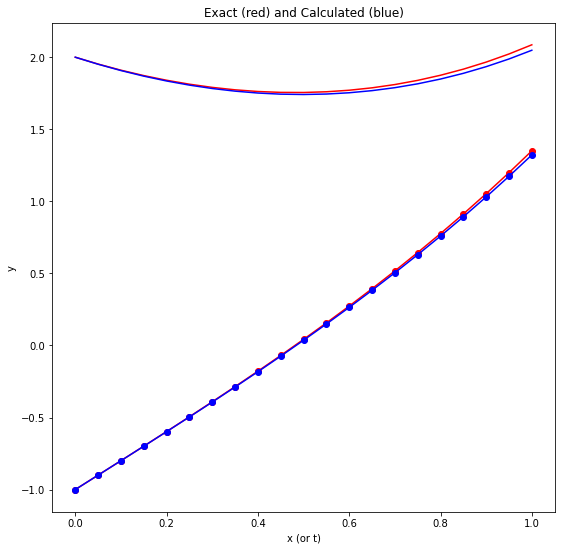

In [39]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
calculatedList0 = []
calculatedList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oSData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[3]))
            calculatedList1.append(float(row[5]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1

#Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList0, color='r')
ax.plot(positionList, calculatedList0, color='b')
ax.plot(positionList, truthList1, color='r', marker = 'o')
ax.plot(positionList, calculatedList1, color='b', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

[5](#5) NRPy+ "Solving the Scalar Wave Equation"

[6](#6) https://www.dataquest.io/blog/read-file-python/

[7](#7) https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib

[9](#9) https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine

The line with cirlces is u', while the one without is u itself. If the Euler method was used, as was set by default, we should see some clear divergence by the end of the procedure: the values start out nearly the same between calculated and exact but slowly diverge. Methods with orders that are much higher than Euler's will produce essentially no discernable difference between the two graphs, everything will look blue. Which is not to say the result is perfect, merely that the difference is not discernable at this scale.

Therefore we usually don't try to compare data to truth this way, we instead look at the errors directly. 

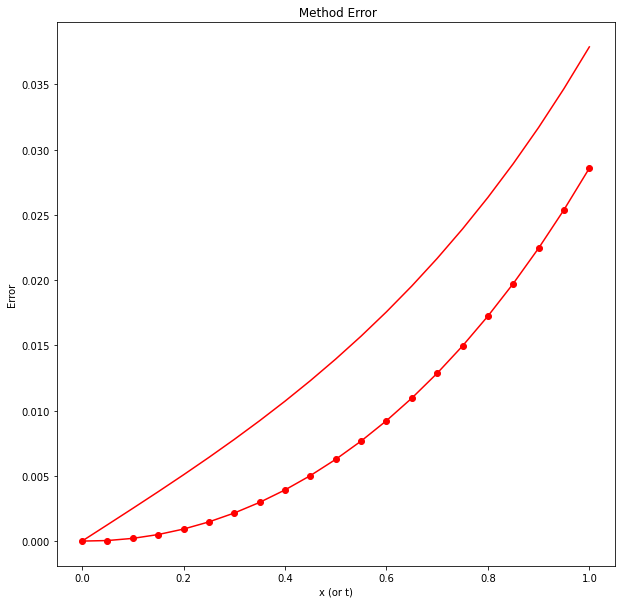

In [40]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
errorList0 = []
errorList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oSData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
        i = i+1

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Error')
ax.set_title(' Method Error')
ax.plot(positionList, errorList0, color='r')
ax.plot(positionList, errorList1, color='r', marker = 'o')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

Admittedly, the above graph isn't particuarly illumiating in most cases, it genreally just shows that errors rise with time. The program reports error in an exact sense: it can be positive or negative and indicates precisely how far off from the truth the result was. Often, however, we care less about that and care more about the relative error, since that can be plotted on a logarithmic scale to tell us to how many significant figures our program matches the truth. 

In this case, we define relative error as:

$$ \left| \frac{Truth - Calculated}{Truth} \right| $$

The errorr reported by the program is just $Truth - Calculated$. But no worries, this is very simple to resolve, for numpy can take the arrays we made and do operations on them. Like so...

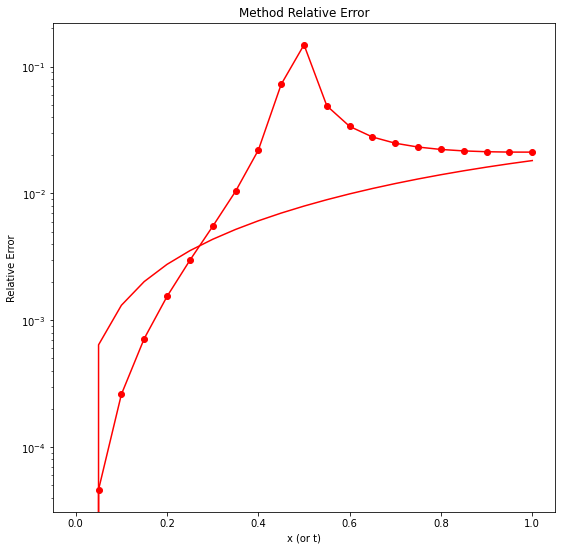

In [41]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
import numpy as np #numpy, for doing math with our data. 

#Make a bunch of lists to hold all our data. 
positionList = []
errorList0 = []
errorList1 = []
truthList0 = []
truthList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oSData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title ('Method Relative Error')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r')
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

This tells us a lot more than the simple error plot! First of all, assuming the parameters have not been adjusted by the user, we can see clearly that the error starts at around 1e-3 and grows to 1e-2. Naturally this is not very good, less than 2 sig figs of agreement at the end, but this is Euler's method, we know it's not very good, we specifically chose it so we could visually see features on the full scale. 

One thing we do note is that the errors for the function u are well behaved and don't do anything unusual, slowly growing as is to be expected. However, the errors for u' spike in the middle! Why is this? Well, if we look at how u' itself behaves in the first graph, that is where it crosses the x axis--that is, u'=0 at some point. As the values get closer to zero, they get smaller and smaller, and thus the relative error between said values increases markedly. We could not see this feature in the direct error plot, but here it's on full display! Being aware of points where functions go to zero is an important part of analyzing them properly, and spikes like this in the error can be used to find them. 

These are generally the three graphs we make from one run of the program. However, there is more informaiton we can glean from running it multiple times. 

<a id='S3e'></a>

## Step 3e: Multiple-Run Examination \[Back to [top](#toc)\]
$$\label{S3e}$$

#### Sometimes doing it once just won't cut it.

Validation of the program can be done if it's run multiple times. In order to demonstrate this validation, we will run the program two times; both times using the RK4 method, but once at 0.01 step size, and another time at 0.02. Doing this is a simple as adjusting `nrpy_odiegm_main_c` and calling NRPy+'s compiler again. 

Since trying to do that from scratch in this notebook would just fill it with C-declarations, we will use data from previous runs of the system to construct the following graphs. What follows are runs performed with the exact same program as above, but the method was RK4. We did the evaluation with two different step sizes: 0.01, and 0.02 with SIZE of 100 and 50, repsectively. When plotted together, the results are:

In [42]:
#os.chdir('../')
#potentially useful, but not for us today. 

nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the functions chosen. 
    //The system of differential equations can be found declared in diffyQEval()
    //in nrpy_odiegm_user_methods.c

    double step = 0.01; //the "step" value. Initial step if using an adaptive method.
    double bound = 0.0; //where the boundary/initial condition is. Same for every equation in the system.
    int numberOfEquations = 2; //How many equations are in our system?
    int numberOfConstants = 0; //How many constants do we wish to separately evaluate and report? 
    //If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    //and cause an overflow in the functions in user_methods
    const int SIZE = 100; //How many steps are we going to take? 
    //This is the default termination condition. 
    int adamsBashforthOrder = 3; //if using the AB method, specify which order you want.
    //If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool noAdaptiveTimestep = true; //Sometimes we just want to step forward uniformly 
    //without using GSL's awkward setup. False by default. 

    bool reportErrorActual = true;
    bool reportErrorEstimates = false;
    //AB methods do not report error estimates. 
    //BE WARNED: setting reporError (either kind) to true makes it print out all error data on another line,
    //the file will have to be read differently. 

    //ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absoluteErrorLimit = 1e-14; //how big do we let the absolute error be?
    double relativeErrorLimit = 1e-14; //how big do we let the relative error be?
    //Note: there are a lot more error control numbers that can be set inside the control "object" d->c.

    char fileName[] = "RKData01.txt"; //Where do you want the data to print?

    //Now we set up the method. 
    const nrpy_odiegm_step_type * stepType;
    stepType = nrpy_odiegm_step_RK4;
    //Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * stepType2;
    stepType2 = nrpy_odiegm_step_RK4;
    //this is a second step type "object" (struct) for hybridizing. 
    //Only used if the original type is AB.
    //Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 

"""

def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    #prefunctions are functions declared outside main.
    #the specifics of what go here were declared above. 
    
    desc = "Simple Example: u''=u+x Solver"
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    #Anything that isn't red indicates where we are inserting something, such as the butcherTable or step size. 
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard
    #Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolver", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolver", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.42 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolver `...
(BENCH): Finished executing in 0.21 seconds.


In [43]:
nrpy_odiegm_main_c_modifiable = r"""

    printf("Beginning ODE Solver \"Odie\" V10...\n");

    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the functions chosen. 
    //The system of differential equations can be found declared in diffyQEval()
    //in nrpy_odiegm_user_methods.c

    double step = 0.02; //the "step" value. Initial step if using an adaptive method.
    double bound = 0.0; //where the boundary/initial condition is. Same for every equation in the system.
    int numberOfEquations = 2; //How many equations are in our system?
    int numberOfConstants = 0; //How many constants do we wish to separately evaluate and report? 
    //If altering the two "numberOf" ints, be careful it doesn't go over the actual number 
    //and cause an overflow in the functions in user_methods
    const int SIZE = 50; //How many steps are we going to take? 
    //This is the default termination condition. 
    int adamsBashforthOrder = 3; //if using the AB method, specify which order you want.
    //If we are not using the AB method this is set to 0 later automatically. 4 by default. 
    bool noAdaptiveTimestep = true; //Sometimes we just want to step forward uniformly 
    //without using GSL's awkward setup. False by default. 

    bool reportErrorActual = true;
    bool reportErrorEstimates = false;
    //AB methods do not report error estimates. 
    //BE WARNED: setting reporError (either kind) to true makes it print out all error data on another line,
    //the file will have to be read differently. 

    //ERROR PARAMETERS: Use these to set limits on the erorr. 
    double absoluteErrorLimit = 1e-14; //how big do we let the absolute error be?
    double relativeErrorLimit = 1e-14; //how big do we let the relative error be?
    //Note: there are a lot more error control numbers that can be set inside the control "object" d->c.

    char fileName[] = "RKData02.txt"; //Where do you want the data to print?

    //Now we set up the method. 
    const nrpy_odiegm_step_type * stepType;
    stepType = nrpy_odiegm_step_RK4;
    //Here is where the method is actually set, by specific name since that's what GSL does. 

    const nrpy_odiegm_step_type * stepType2;
    stepType2 = nrpy_odiegm_step_RK4;
    //this is a second step type "object" (struct) for hybridizing. 
    //Only used if the original type is AB.
    //Set to AB to use pure AB method. 

    //AFTER THIS POINT THERE SHOULD BE NO NEED FOR USER INPUT, THE CODE SHOULD HANDLE ITSELF. 

"""

def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = nrpy_odiegm_h+ nrpy_odiegm_proto_c+ nrpy_odiegm_funcs_c + nrpy_odiegm_user_methods_c
    #prefunctions are functions declared outside main.
    #the specifics of what go here were declared above. 
    
    desc = "Simple Example: u''=u+x Solver"
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    #Anything that isn't red indicates where we are inserting something, such as the butcherTable or step size. 
    body = nrpy_odiegm_main_c_modifiable + nrpy_odiegm_main_c_standard
    #Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolver", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolver", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

(EXEC): Executing `make -j10`...
(BENCH): Finished executing in 0.41 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3 ./ODESolver `...
(BENCH): Finished executing in 0.20 seconds.


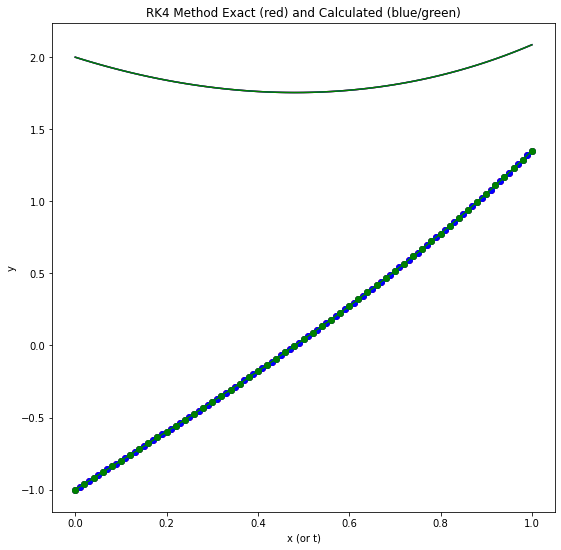

In [49]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
calculatedList0 = []
calculatedList1 = []

#"a" appended to the front of lists to be used for the second data set.
#truth list is irrelevant, the value is the same for both. 
apositionList = []
acalculatedList0 = []
acalculatedList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/../RKData01.txt') as f: #shenangians required to access the previous file. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[3]))
            calculatedList1.append(float(row[5]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
        i = i+1
i = 0
with open('RKData02.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
            acalculatedList0.append(float(row[3]))
            acalculatedList1.append(float(row[5]))
        i = i+1


#Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('RK4 Method Exact (red) and Calculated (blue/green)')
ax.plot(positionList, truthList0, color='r')
ax.plot(positionList, calculatedList0, color='b')
ax.plot(apositionList, acalculatedList0, color='g')
ax.plot(positionList, truthList1, color='r', marker = 'o')
ax.plot(positionList, calculatedList1, color='b', marker = 'o')
ax.plot(apositionList, acalculatedList1, color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

Naturally, viewing it from the bird's eye view reveales absolutely nothing, as the truth, 0.01 step, and 0.02 step results are all essentially right on top of each other. We can tell that the resolution is different only because the dots use to mark u' values are not in the same locations along the line. We have to examine the log plot to get anything useful out of this. 

0.0
2.0
2.664535259e-15
1.990100001
3.907985047e-14
1.980400013
1.083577672e-13
1.970900068
2.113864639e-13
1.961600213
3.474998067e-13
1.952500521
5.169198403e-13
1.94360108
7.200906538e-13
1.934902001
9.56568158e-13
1.926403414
1.226352353e-12
1.918105469
1.529443239e-12
1.910008336
1.866951038e-12
1.902112206
2.237987573e-12
1.894417288
2.642774888e-12
1.886923814
3.081535027e-12
1.879632034
3.554045946e-12
1.872542219
4.060973779e-12
1.86565466
4.601208303e-12
1.858969668
5.176081785e-12
1.852487575
5.785150137e-12
1.846208732
6.429079491e-12
1.840133511
7.107203714e-12
1.834262306
7.819966896e-12
1.828595529
8.567813126e-12
1.823133612
9.350520358e-12
1.817877011
1.016853268e-11
1.8128262
1.10218501e-11
1.807981672
1.191047261e-11
1.803343945
1.283506634e-11
1.798913554
1.379518721e-11
1.794691056
1.479150136e-11
1.790677028
1.582445286e-11
1.78687207
1.689337559e-11
1.783276801
1.799915772e-11
1.779891862
1.914157721e-11
1.776717913
2.032152224e-11
1.773755638
2.153854872e-11
1.7

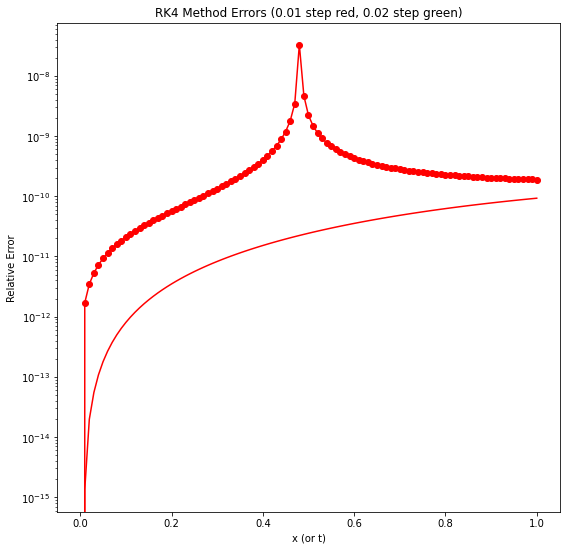

In [56]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
errorList0 = []
errorList1 = []

#"a" appended to the front of lists to be used for the second data set.
#truth list matters now as we need to be calculating relative errors.
apositionList = []
atruthList0 = []
atruthList1 = []
aerrorList0 = []
aerrorList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/../RKData01.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            print(float(row[2]))
            truthList0.append(float(row[4]))
            print(float(row[4]))
            truthList1.append(float(row[8]))
            errorList1.append(float(row[6]))
        i = i+1
i = 0
with open('RKData02.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
        else:
            atruthList0.append(float(row[4]))
            atruthList1.append(float(row[8]))
            aerrorList0.append(float(row[2]))
            aerrorList1.append(float(row[6]))
        i = i+1

#Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title('RK4 Method Errors (0.01 step red, 0.02 step green)')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r')
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o')
#ax.plot(apositionList, abs(np.array(aerrorList0)/np.array(atruthList0)), color='g')
#ax.plot(apositionList, abs(np.array(aerrorList1)/np.array(atruthList1)), color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'
ax.set_yscale("log") #found in matplotlib's documentation.

We note the very curious result that while the errors are different in magnitude, their shape is virtually identical. The fact that 0.02 has more error than 0.01 is expected: smaller step size leads to higher resolution. But it almost looks as though there is a relaiton between the two errors. That is because there is a relation, that relation is based on the order of the error itself. Adjusting the step size by a factor of two should introduce an error difference of ariybd $2^m$, where m is the order of the error. in this case, m is 4, so we should see error adjustments by a factor of 16. Do we? 

The best way to test is just to plot it again, but scale one of the values by 16.

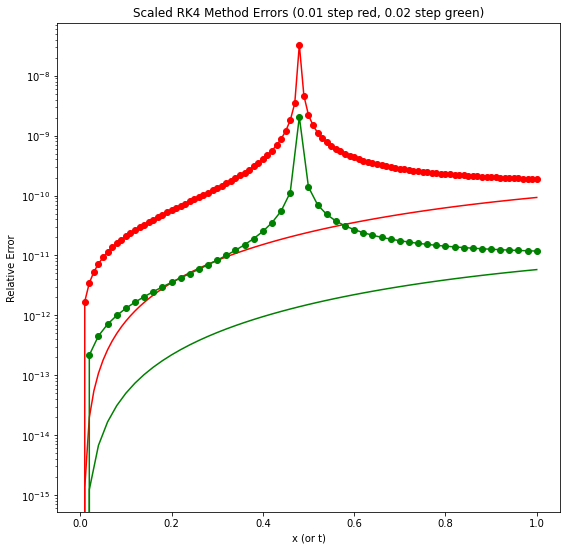

In [53]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys

#Make a bunch of lists to hold all our data. 
positionList = []
truthList0 = []
truthList1 = []
errorList0 = []
errorList1 = []

#"a" appended to the front of lists to be used for the second data set.
#truth list matters now as we need to be calculating relative errors.
apositionList = []
atruthList0 = []
atruthList1 = []
aerrorList0 = []
aerrorList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/../RKData01.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            truthList0.append(float(row[4]))
            truthList1.append(float(row[8]))
            errorList0.append(float(row[2]))
            errorList1.append(float(row[6]))
        i = i+1
i = 0
with open('RKData02.txt') as f: #this file is stored in the folder, not produced at runtime.
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            apositionList.append(float(row[1]))
        else:
            atruthList0.append(float(row[4]))
            atruthList1.append(float(row[8]))
            aerrorList0.append(float(row[2]))
            aerrorList1.append(float(row[6]))
        i = i+1

#Next we plot it all using matplotlib. 
fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error')
ax.set_title('Scaled RK4 Method Errors (0.01 step red, 0.02 step green)')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r')
ax.plot(positionList, abs(np.array(errorList1)/np.array(truthList1)), color='r', marker = 'o')
ax.plot(apositionList, abs(np.array(aerrorList0)/np.array(atruthList0)/16.0), color='g')
ax.plot(apositionList, abs(np.array(aerrorList1)/np.array(atruthList1)/16.0), color='g', marker = 'o')

# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'
ax.set_yscale("log") #found in matplotlib's documentation.

The scaling factor of 16 has made it so the two error plots are more or less right on top of each other. They agree remarkably, even near the spike as u' approaches zero. 

This is effectively a validation check for the RK4 method itself--is it consistent with its supposed fourth-order accuracy? As we can see here, yes, absolutely. Everything matches. With that, we consider the Simple Example complete. We can now move on to a more complciated example, one where the truth is not known. 

<a id='S4'></a>

## Step 4: Complicated Problem Example \[Back to [top](#toc)\]
$$\label{S4}$$

#### Don't hang up yet, I'm not done.

The program is more than capable of handling questions that are far more complicated than a simple second-order differential equation. For instance, in General Relativity there are a sequence of equations called the TOV equations, the primary isntance of which is described on wikipedia [here](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation). In genreal, the TOV equations represent a relativistic picture of a spherically symmetric star with respect to the radius. 

The specifics of why we wish to solve the TOV equations are unimportant, what is important is the form they take. There are many ways to state and evaluate them, but the one we will implement here is given by the following:

$$
\boxed{
\begin{matrix}
\frac{dP}{dr} &=& - \frac{1}{r} \left( \frac{\rho + P}{2} \right) \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \left(1 - \frac{2 m}{r}\right)^{-1} \\
\frac{d \nu}{d r} &=& \frac{1}{r}\left(1 - \frac{2 m}{r}\right)^{-1} \left(\frac{2 m}{r} + 8 \pi r^2 P\right) \\
\frac{m(r)}{dr} &=& 4\pi r^2 \rho(r) \\
\frac{d\bar{r}(r)}{dr} &=& \left(1 - \frac{2m}{r} \right)^{-1/2} \frac{\bar{r}(r)}{r}
\end{matrix}
}\
$$

Taken from the soon-to-be-depricated [NRPy+ TOV solver](http://localhost:8889/notebooks/Tutorial-ADM_Initial_Data-TOV.ipynb). P is pressure, $\nu$ doesn't correlate to something easily seen as physica, m is the total enclosed mass of the star, and r-bar is the isotropic radius (non-normalized). Though, really, as an example the physical meaning of the results are unimportant. 

In various implementations and models, the function $\rho$ (energy density) can vary. In our implementation here, we treat it as

$$ \rho(r) = \sqrt{P} + P $$

Which we will report as a separate constant, making use of our program's functionality in this regard. For the record, a fuller definition of $\rho(r)$ would be...

$$ \rho(r) = (P/K)^{1/\Gamma} (1 + \frac{P}{(P/K)^{1/\Gamma} (\Gamma - 1)})$$

However, in our implementation K=1 and $\Gamma = 2$ so it quickly reduces to our original declaration. 

Another thing we need is initial conditions. The pressure has to be specified ahead of time, but all other values start at zero. In our case, Pressure is 0.016714611225000002. 

With all this, we have 4 differential equations and 1 constant we wish to report. We also need to consider our boundary conditions. Traditionally, we start from the center of the star at r=0. This, naturally, will provide some issues as the solver will run into divide by zero errors if it tries to evaluate any point there. However, in our declaration we will demonstrate how to avoid this issue, as well as avoiding problems that will arise if, say, the pressure goes negative due to an estimation error and makes the energy density NaN, which breaks everything. It can all be handled in the program so long as it is implemented properly. 

Note that unlike the Simple Problem, we do not know what the answer should be ahead of time, so there will be no relative error reporting this time around--but we will still have other forms of analysis. 

<a id='S4a'></a>

## Step 4a: Complicated Problem Customization  \[Back to [top](#toc)\]
$$\label{S4a}$$

#### Curiously not more complicated than the simple version of this section. 

Here is where users can adjust information in the notebook to adjust how the program runs. These changes only apply to the Complicated Example, the Simple Example and the final fully customizable code have their own customization sections. 

In [ ]:
#This is the method variable, used to choose how the program calculates the result. 
key = "RK4"
#Possible options: "Euler" (Order 1), "RK2 Heun" (Order 2), "RK2 MP" (2), 
#"RK2 Ralston" (2), "RK3" (3), "RK3 Heun" (3), "RK3 Ralston" (3), "SSPRK3" (3),
#"RK4" (4), "DP5" (5), "DP5alt" (5), "CK5" (5), "DP6" (6), "L6" (6), "DP8" (8) 

#This is the step size. 
step = "0.00001"
#Can be any number, 0.00001 by default, because that's the first step the original NRPy+ TOV took.
#Note that this is a string--we are passing it to
#the C code generator as a string. Be very careful not to declare it as something that isn't
#a number. 

#This is the number of steps.
size = "100000"
#Can be any integer, 100000 by default. Be sure to make it actually be an integer. 
#Note that this time we have a termination condition, so we will not hit all the steps. 

#this is what we set to ask for validation. "true" if desired, "false" if not. Disabled for this example. 
validate = "false"

#This is the initial point we start from. Generally zero.
bound = "0.0"

#Unless you're adding another function or wish to report a constant, do not change the two settings below. 
#this is the number of equations in the system of differential equations
eNum = "4"
#make sure this is an integer.

#this is the number of constants we wish to report.
cNum = "1"
#make sure this is an integer.

#more coming eventually: functions and boundary values.
#though those two might be a while. 

<a id='S4b'></a>

## Step 4b: Complicated Problem Python-Code \[Back to [top](#toc)\]
$$\label{S4b}$$

#### The snakes complain that there's nothing different to do here. 

As with the simple example, we have to grab the Butcher Table and format it properly. The code here is absolutely identical to the previous example, it is simply replicated here for clarity. 

In [ ]:
import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import numpy as np              # NumPy: A numerical methods module for Python
from RK_Butcher_Table_Dictionary import Butcher_dict #the Butcher Tables themselves. 

#The end result of all this should be a string with our chosen method. 
#If you want to set the method, see above. 

butcherTable = ""

#Now in order to determine what size to make our loop, we need the size of the table itself.
print(len(Butcher_dict[key][0]))
rows = len(Butcher_dict[key][0])
#TABLE CONVERSION IN PROGRESS, PICK UP TOMORROW
maxColumns = len(Butcher_dict[key][0][rows-1]) #the last row has the max columns.
print(len(Butcher_dict[key][0][rows-1]))
i = 0

#Set up th edeclaration of the double 2D array in C. 
butcherTable = butcherTable + "double butcher[" + str(len(Butcher_dict[key][0])) + "][" + str(len(Butcher_dict[key][0][rows-1])) +"] = {"

while (i < rows):
    print(len(Butcher_dict[key][0][i]))
    #The above print function helps us see that the program really is doing the entire matrix.
    columns = len(Butcher_dict[key][0][i]) 
    
    butcherTable = butcherTable + "{"
    #Even though the matrix is square, we cannot set rows=columns since 
    #The butcher tables have a lot of empty slots we will be filling with 0s. 
    j = 0
    if Butcher_dict[key][0][i][j] == '':
        butcherTable = butcherTable + str(float(Butcher_dict[key][1]))+ ","
        j = j+1
        # This is a check for the empty spot in the bottom left of the table
        # the C-code uses this to store the method order, so we put it there. 
        # The main bennefit is that this keeps the matrix square.
    while (j < maxColumns): #not < columns, since we still need to fill in 0s for 
        #the C code. 
        if (j < columns):
            butcherTable = butcherTable + str(float(Butcher_dict[key][0][i][j]))
            # Print the number requested. 
            # Note the conversion to floating point. The C-code has no clue what to
            # do with fractions, so they must be changed. 
            if (j<maxColumns-1):
                butcherTable = butcherTable + ","
                #if not at end of row, add comma. WE don't want to overdo it. 
        elif (j < maxColumns-1):
            butcherTable = butcherTable + "0"+ ","
            # if we are at the point where there are no numbers, fill with 0. 
        else:
            butcherTable = butcherTable + "0"
            # if we are at the point where there are no numbers, fill with 0. 
            # end of row does not have the comma addition. 
        j = j+1
    if(i < rows-1):
        butcherTable = butcherTable + "},"
    else:
        butcherTable = butcherTable + "}"
    # After every row, we need a brace, but the added comma is not needed on the last one.
    i = i+1
butcherTable = butcherTable + "};"
print(butcherTable)

With that, now we can start setting up the file within which we will run the C code. Once again, we rely on NRPy+'s abilities to do this. 

In [ ]:
import outputC as outC       #NRPy+: Core C code output module.
import cmdline_helper as cmd #NRPy+: Multi-platform Python command-line interface
import os                    #Python: Miscellaneous operating system interfaces
import shutil                #Python: High level file operations

# https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Start_to_Finish-Finite_Difference_Playground.ipynb

#Create a C code output directory
#First, name it.
Ccodesrootdir = os.path.join(sys.path[0] + "/ODESolver_Complicated_Ccodes/")
#Remove any previously existing files there.
shutil.rmtree(Ccodesrootdir,ignore_errors=True)
#Create the fresh directory. 
cmd.mkdir(Ccodesrootdir)

<a id='S4c'></a>

## Step 4c: Complicated Problem C-Code \[Back to [top](#toc)\]
$$\label{S4c}$$

#### Time to make use of some real power.

Below is the C-Code. Numerous output lines are commented out and can be un-commented at will if a user wishes to examine in more detail what's happening during runtime. (Though in this notebook that is likely not necessary as the terminal output is just placed in a text file.) Code is heavily commented, some of it is likely redundant with the section above, but looking at things two different ways rarely hurts. 

The C-code generated here can also be found in pure C form, though it only has one of each of the first five orders of solution methods as possibilities, as it is unable to interface with NRPy+ directly. 

If a user wishes to examine the code in detail, we highly recommend opening the .c version in a coding editor with C in mind, since jupyter notebook is going to color all the C-Code red because we pass it through Python as a very large string. 

Yes, it is a very large block of text that is hard to read. We recommend looking for python comments marked with # to understand what exactly is being done. Unlike the Simple Example, here we will be using a lot of the extra functionality of the solver, but will not be reporting errors since this is a situation where we don't know what the truth is. 

In [ ]:
#Now define our c function itself. To do that, we need to build the strings that actually make up the C-function. 
#when creating functions, NRPy+ takes several arguments, each one with its own important role:
#includes: this is where all the .h files that the C program relies on are declared, in the form of a list. 
#prefunc: any functions that exist outside of main() are declared here. For the purposes of this tutorial, we 
#explicitly declare these functions one at a time and go over them, but more often all of them are passed
#to prefunc as a long string all at once. 
#desc: contains a description of the method.
#c_type: what type does the main() function return? This is usually int. 
#name: what is the name of the main() function? Usually just main. 
#params: a place to put special parameters. Usually blank.
#body: the actual body of the main function and the majority of text density on any given document. 

#The most important part to go over is prefunc, for it is the part the user is expected to interact with.
#We consider its construction here step-by-step, one function at a time. 
#we use the format r""" """ to pass string literals so the C-code slashes don't mess up Python's compiler. 

aString = r"""
void diffyQEval (double x, double y[], double c[])
{
    //Efficient(ish) Assignment Method
    //This computes the values of the *derivatives* of the functions, so what we are passed
    //in the array y[] is *not* the same thing as what we are calculating, be careful not to re-use
    //outside of the function, because we are taking in the function itself and replacing it with its derivative. 
    //This is somewhat counter-intuitive, but it is efficient. 

    //This if statement is an example of a special condition, in this case at x=0 we have a divide by zero problem. 
    //In this case we manually know what the derivatives should be.
    //Alternatively, we could define piecewise equations this way. 
    if(x == 0) {
        y[0] = 0; 
        y[1] = 0;
        y[2] = 0;
        y[3] = 1;
    }
    else {
        double y0 = y[0]; //Pressure
        double y1 = y[1]; //nu. Uncertain what this physically is, likely just a bookkeeping situation. 
        double y2 = y[2]; //Total mass. 
        double y3 = y[3]; //r-bar, the isotropic radius. NOT NORMALIZED. Must be normalized in post-processing. 

        //Note that we declare these buffer variables since we will need to use them multiple times, but we are also
        //overwriting them in the original array, so we need buffers. 
        y[0] = -((c[0]+y0)*( (2.0*y2)/(x) + 8.0*M_PI*x*x*y0 ))/(x*2.0*(1.0 - (2.0*y2)/(x)));
        y[1] =  ((2.0*y2)/(x) + 8.0*M_PI*x*x*y0)/(x*(1.0 - (2.0*y2)/(x)));
        y[2] = 4*M_PI*x*x*c[0];
        y[3] = (y3)/(x*sqrt(1.0-(2.0*y2)/x));
    }
    //This funciton is not guaranteed to work in all cases. For instance, we have manually 
    //made an exception for x=0, since evaluating at 0 produces infinities and NaNs. 
    //Be sure to declare any exceptions before running, both here and in exceptionHandler(), depending 
    //on the kind of exception desired.  
}

"""

#The above function is where a user would declare the actual set of differential equations to be solved. 
#Here we have declared the TOV equations, all four of them. 
#Note that we have an if statement here. This is an example of careful declaration.

#The if statement catches when we're trying to evaluate a function at zero, which would go very badly
#aince most of the equations contain 1/r, which is going to break everything. Thus, when we evaluate
#at r=0 (or x=0 in the code), we replace the values with known ones. 
#The determination of these values was analytic in nature: pressure, nu, and mass all have to have
#a derivative of zero at r=0 since they are smooth functions and the star is spherically symmetric. 
#The isotropic radius is a little different, we assume here that it has a derivative of 1, that is, 
#it scales directly with the radius r itself at the start. This is just an assumption to get it to
#calculate. The produced result will be incorrect, but it will be *relatively* correct. The actual
#isotropic radius will be found by normalizing the data produced by this. We are allowed to do this since
#none of the other functions in the system depend on the isotropic radius. 

#Such an if statement could also be used to declare piecewise differential equations. 

#Note the nuance: we are being passed an array with values y, but we change it to contain values y', the derivatives.
#This is why we make sure to declare double variables when doing this, in case, say, the derivative of y1 depends
#On y0. These coupled reliances exist here, too; if we changed y2 and then tried to evaluate the y3', we would be incorrect. 
#Users can also declare piecewise functions here with a C if statement, should it be desired. 

aString = aString + r"""
void getInitialCondition (double y[])
{
    //be sure to have these MATCH the equations in diffyQEval
    y[0] = 0.016714611225000002; //Pressure
    y[1] = 0.0; //nu
    y[2] = 0.0; //mass
    y[3] = 0.0; //r-bar
}
"""

#We have added another function, the getInitialCondition function, which is used to stare initial conditions. 
#These are the initial conditions of the actual functions, not their derivatives. 
#When declaring new initial conditions, make sure they match the order of the differential equations in DiffyQEval()!
#The program assumes the values you insert here are correct, this will lead to problems if they are not. 
#The initial condition for the Pressure comes from the "central baryon density," via P = Krho_b^Gamma = rho_b^2. 
#The baryon density here was chosen to be 0.129285, taken from NRPy+'s TOV solver

aString = aString + r"""
void constEval (double y[], double c[])
{
    //Sometimes we want to evaluate constants in the equation that change, but do not have derivative forms.
    //Today, we do that for the total energy density. 
    double c0 = c[0];
    //Make sure to instantiate buffer values so you don't end up changing things when you don't want to!
    //Not necessary here, but left in as a demonstration. 
    c[0] = sqrt(y[0]) + y[0];
    //The total energy density only depends on pressure. 
}

"""

#Today we have a constant to evaluate, the total energy density. It depends entirely on y[0] (Pressure), however
#the program supports constants that depend on any number of the actual differential equation values. 

aString = aString + r"""
void knownQEval (double x, double y[])
{
    //This function is only used if there are known solutions. 
    //Notably this is not the case for the TOV equations. 
    //If you do put anything here, make SURE it has the same order as the differential equations. 
    //In the case of TOV, that would be Pressure, nu, mass, and r-bar, in that order. 
}

"""

#We do NOT know the solution to the TOV equations, so we leave this function empty save for some comments. 
#If we did have an exact result, it would need to be declared in the same order as the differential equations.

aString = aString + r"""
void exceptionHandler (double x, double y[], double c[])
{
    //This funciton might be empty. It's only used if the user wants to hard code some limitations 
    //On some varaibles.
    //Good for avoding some divide by zero errors, or going negative in a square root. 
    if (y[0] < 0) {
        y[0] = 0;
    }
    //In this case, the TOV Equations, we need to make sure the pressure doesn't go negative.
    //Physically, it cannot, but approximation methods can cross the P=0 line
    //We just need a hard wall to prevent that. 
}

"""

#This time, we do need an exception handler. In this case, we knot that the total energy density (rho)
#is determined by taking the square root of the pressure. If RK methods were perfect, there would
#be no problem here, since the only way this would be undefined is if Pressure went negative. Physically,
#this is impossible. However, RK methods are not perfect and when evaluating values near 0, they can
#easily throw out small values just below zero. This will break everything when the program tries
#to take a square root. So, if we ever detect that pressure has dropped below zero, we set it *to* zero
#to prevent this from occuring. 

#If a user is getting a lot of NaN and inf results, chances are the program is trying to evaluate something
#like a negative square root. The exception handler can also be used to force boundaries on the way the data
#evolves, such as modeling a "wall" by preventing a value from increasing beyond a certain point. 

aString = aString + r"""
int doWeTerminate (double x, double y[], double c[])
{
    //This funciton might be empty. It's only used if the user wants to have a special termination condition.
    //Today we do. We terminate once the pressure hits zero, or goes below it. 
    if (y[0] <= 0.0) {
        return 1;
    } else {
        return 0;
    }
    //return 1 for termination.
}

"""

#We also have a termination condition. Once the pressure drops to zero, we know we have reached the
#edge of the star and don't particuarly care what exists outside of it. 

def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h", "time.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = aString
    #prefunctions are functions declared outside main.
    #the specifics of what go here were declared above. 
    
    desc = "Complicated Example: TOV Solver With Basic Assumptions."
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    #Anything that isn't red indicates where we are inserting something, such as the butcherTable or step size. 
    body = butcherTable + r"""
    printf("Beginning ODE Solver \"Odie\" V7...\n");
    
    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the functions chosen. 
    //The system of differential equations can be found declared in diffyQEval().

    double step = """ + step + r"""; //the "step" value.
    double bound = """ + bound + r"""; //where the boundary/initial condition is. Same for every equation in the system.
    int numberOfEquations = """ + eNum + r"""; //How many equations are in our system?
    int numberOfConstants = """ + cNum + r"""; //How many constants do we wish to separately evaluate and report? 
    //If altering the two "numberOf" ints, be careful it doesn't go over the actual number and cause an overflow 
    //in the functions above main()
    const int SIZE = """ + size + r"""; //How many steps we are going to take?
    bool validate = """ + validate + r"""; //Set to true if you wish to run a validation test. Only works if solution is already known.
    //Spits out nonsense if no solution is provided.
    //BE WARNED: setting validate to true makes it print out all error data on a second line, the file will have
    //to be read differently.

        //How to get array size: https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c
    size_t methodSize = sizeof(butcher)/sizeof(butcher[0][0]);
    int dimension = sqrt((int)methodSize);
    //We need to know how big our method is, especially if passed one we've never seen before. 
    if (validate == true) {
        printf("Method Order: %i. \nOrder of Error should be near to or larger than Method Order + 1.\n",(int)butcher[dimension-1][0]);
        printf("If not, try a larger step size, roundoff error may be interfering.\n");
    } else {
        printf("Method Order: %i.\n",(int)butcher[dimension-1][0]);
    }
    //If validation is not needed, we don't care about the Order of the Error. 

    double y[numberOfEquations];
    double c[numberOfConstants];
    //These variables temporarily store the values calculated before they are 
    //printed to the output file and forgotten.
    //y is the values of the actual equations. 
    //c is just used to hold any constants we wish to report. 
    //Each array only holds values at one evaluation point, but one for each Equation.

    //This here sets the initial conditions as declared in getInitialCondition()
    getInitialCondition(y); 

    //This evaluates any constants that might be needed for evaluating the actual differnetial equations. 
    constEval(y,c);

    //SECTION II: The Loop

    //prior to beginning the loop, start the timer. 
    double startN = time(NULL);
    //printf("Time: %.90f seconds\n", startN);
    //set start time to current time.  Uncomment to print.

    //also open the file we'll be writing data to. 
    FILE *fp;
    fp = fopen("oCData.txt","w");

    //First though, let's print out our initial data. The print function needs to be adaptable to any size of data. 
    //We can do this with multiple print functions and just not adding the newline character until we're done.
    //We print both to console and to the file for the initial conditions, but later only print to file.
    //First, print the location we are at. 
    printf("INITIAL: Position:,\t%f,\t",bound);
    fprintf(fp, "Position:,\t%f,\t",bound);
    //Second, go through and print the result for every single equation in our system.
    for (int n = 0; n < numberOfEquations; n++) {
        printf("Equation %i:,\t%10.9e,\t",n, y[n]);
        fprintf(fp, "Equation %i:,\t%10.9e,\t",n, y[n]);
    }
    //Third, print out desired constants.     
    for (int n = 0; n < numberOfConstants; n++) {
        printf("Constant %i:,\t%10.9e,\t",n, c[n]);
        fprintf(fp, "Constant %i:,\t%10.9e,\t",n, c[n]);
    }
    //Lastly, the newline character. 
    printf("\n");
    fprintf(fp,"\n");
    //Comma delimiters are printed to the file so it can be converted to .csv with ease. 

    if (validate == true) {
        //In order to keep things neat and regular in the file, print a first line of errors. 
        //Even though by necessity all of them must be zero. 
        fprintf(fp, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp, "Equation %i:,\t0.0,\t",n);
                fprintf(fp, "Truth:,\t%10.9e,\t",y[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp, "Constant %i:,\t0.0,\t",n);
                fprintf(fp, "Truth:,\t%10.9e,\t",c[n]);
            }   
            //printf("\n");
            fprintf(fp,"\n");
    }
    
    //This loop fills out all the data.
    //It takes a provided butcher table and executes the method stored within. Any table should work. 

    for (int i = 0; i < SIZE; i++){ 
        //i represents how many steps have been taken. 0 is the initial condition, that is, the variable `bound`. 
        double K[dimension][numberOfEquations];
        //These are the K-values that are required to evaluate RK-like methods. 
        //They will be determined based on the provided butcher table.
        //This is a 2D matrix since each diffyQ has its own set of K-values. 

        //Since we'll be calling K while it's empty, even though there should be no errors due
        //to the way it's set up, let's go ahead and fill it with zeroes.
        for (int j = 0; j<dimension; j++) {
            for (int n = 0; n<numberOfEquations; n++) {
                K[j][n]=0.0;
            }
        } 

        double yInsert[numberOfEquations];
        //We also need an array for the inserted y-values for each equation. 
        //Most applications actually have the different yInsert values be independent, so 
        //if we knew the form of the equation we could simplify the code.
        //However, we need to make sure to always fill everything in case we have a system
        //of the form y'=f(u,y) u'=g(u,y)

        double cInsert[numberOfConstants];
        //Create an array to hold the constants we want.
        //Surprisingly, does not throw an error when the number is zero. Neat.

        for (int j = 1; j < dimension; j++) {
            //Due to the way the Butcher Table is formatted, start our index at 1 and stop at the end. 
            double xInsert = bound+i*step + butcher[j-1][0]*step;
            //x does not change much for different tables, just adjust the "step correction" term.
            //x is the same for every equation too.

            for (int n = 0; n < numberOfEquations; n++) {
                yInsert[n] = y[n];
            } 
            //This is set since y is our actual value, but we will be adjusting yInsert a lot to find the next y. 

            for (int n = 1; n < dimension; n++) {
                //Once again, start at index of 1 rather than 0.
                for (int q = 0; q < numberOfEquations; q++) {
                    yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                }
                //Each individual yInsert portion is dependent on one of the K values.
                //K values are initially set to zero even though technically whenever 
                //we would use an undeclared K-value the butcher table would have zero.
                //You know, just in case something goes wrong. 
            }
            
            //Check for any limitations on our results. 
            exceptionHandler(xInsert,yInsert,cInsert);

            //Evaluate the constants. 
            constEval(yInsert,cInsert);

            //Now we actually evaluate the differential equations. 
            diffyQEval(xInsert, yInsert, cInsert);
            //yInsert comes out as evaluated derivatives, and is now in a form we can use. 

            for (int n = 0; n < numberOfEquations; n++) {
                K[j][n] = step*yInsert[n];
                //Fill in the K-values. 
            } 
        }

        //Now that we have all the K-values set, we need to find the actual result in one final loop.
        for (int n = 0; n< numberOfEquations; n++) {
            K[0][n] = y[n]; //The 0th spot in the K-values is reserved for holding the 
            //final value while it's being calculated. 
            for (int j = 1; j < dimension; j++) {
                K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n]; 
                //This is where the actual approximation is finally performed. 
            }
            if (validate == true) {
                yInsert[n] = y[n];
                //Before we change our initial ys, we save their data for the validation check now that
                //yInsert is not being used. 
            }
            y[n] = K[0][n]; //Set y to the new estimated value. 
        }

        //After each step is calculated, print results. 
        //However, prior to printing we need to run our exception and constant evaluators one more time. 
        exceptionHandler(bound+i*step,y,c);
        constEval(y,c);
        //Since we've usually been running them on yInsert, the actual y and c values have not generally seen 
        //the restrictions applied here. 

        //Uncomment for live updates.
        //printf(fp, "Position:,\t%f,\t",bound+(i+1)*step);
        fprintf(fp, "Position:,\t%f,\t",bound+(i+1)*step);
        for (int n = 0; n < numberOfEquations; n++) {
            //printf("Equation %i:,\t%10.9e,\t",n, y1[n]);
            fprintf(fp, "Equation %i:,\t%10.9e,\t",n, y[n]);
        }
        for (int n = 0; n < numberOfConstants; n++) {
            //printf("Constant %i:,\t%10.9e,\t",n, c[n]);
            fprintf(fp, "Constant %i:,\t%10.9e,\t",n, c[n]);
        }   
        //printf("\n");
        fprintf(fp,"\n");
                
        //validation: grab the first error for every equation, estimate its order, and continually report errors
        if (validate==true) {
            //We should only be here if we have a truth to compare against. 
            double saveErr1[numberOfEquations];
            double yTruth[numberOfEquations];
            double constErr1[numberOfConstants];
            double cTruth[numberOfConstants];
            //we need errors for both the differential equations and the constants. 
            //We only need one error array for reporting errors, but we will need a second for order checking. 
            exceptionHandler(bound+step*(i+1),yTruth,cTruth);
            knownQEval(bound+step*(i+1),yTruth);
            constEval(yTruth,cTruth);
            //Evaluate what yTruth is at our current point.
            //remember, i+1, not i, since we've already updated the previous point. 

            for (int n = 0; n < numberOfEquations; n++) {
                saveErr1[n] = (yTruth[n] - y[n]);
                //This calculates the errors we have right now. 
            } 
            for (int n = 0; n < numberOfConstants; n++) {
                constErr1[n] = (cTruth[n] - c[n]);
                //This calculates the constant errors we have right now. 
            } 

            if(i == 0.0) { 
                //The following is an algorithm for determining the rate of error 
                //convergence. A bit rudimentary, could be condensed, but is also only
                //called once so not relaly a concern and it is easier to read this way. 
                //Note that this only reports the estimated order for the differential equations, not constants. 
                double saveErr2[numberOfEquations];
                //Need to store a second error. 
                double step2 = step*0.5;
                //It is easier to just use another variable than multiply the step by 0.5 every time. 
                //Below not really commented since it is just a copy of what's above with minor tweaks.
                    for (int j = 0; j<dimension; j++) {
                        for (int n = 0; n<numberOfEquations; n++) {
                            K[j][n]=0.0;
                        }
                    }

                    double yInsertBuffer[numberOfEquations];

                    for (int j = 1; j < dimension; j++) {
                        double xInsert = bound+i*step2 + butcher[j-1][0]*step2;
                        
                        for (int n = 0; n < numberOfEquations; n++) {
                            yInsertBuffer[n] = yInsert[n];
                        } 
                        for (int n = 1; n < dimension; n++) {
                            for (int q = 0; q < numberOfEquations; q++) {
                                yInsertBuffer[q] = yInsertBuffer[q] + butcher[j-1][n]*K[n][q];
                            }
                        }

                        exceptionHandler(xInsert,yInsertBuffer,cInsert);

                        constEval(yInsertBuffer,cInsert);

                        diffyQEval(xInsert, yInsertBuffer, cInsert);
                        for (int n = 0; n < numberOfEquations; n++) {
                            K[j][n] = step2*yInsertBuffer[n];
                        }

                    }
                    for (int n = 0; n< numberOfEquations; n++) {
                        K[0][n] = yInsert[n];
                        for (int j = 1; j < dimension; j++) {
                            K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n];
                        }
                    }
                //Now that we've performed the approximation's first step at half the size, we can estimate the order.
                //Create an array to hold the true values. 
                double truthValidate[numberOfEquations];
                //Fill it with the true values. 
                knownQEval(bound+step2,truthValidate);
                //Then print out the estimated order, one individually for each equation.
                for (int n = 0; n < numberOfEquations; n++) {
                    saveErr2[n] = (truthValidate[n] - K[0][n]);
                    printf("Order of Error: %i\t%f\n",n, log2(saveErr1[n]/saveErr2[n]));
                }
                //Note: this will not produce an integer, but with proper data it will be close to an integer
                //and the validation would be performed by rounding. 
                //Results can be larger than the order of the method+1, but should not be much smaller
                //However one can also get errors if the results are too exact, roundoff error can ruin the calcluation. 
                //Using larger step sizes usually removes that. 
            }
        
            //When validating, we add an extra line to the output file for errors.
            //prints the errors alongside the truth values. 
            fprintf(fp, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp, "Equation %i:,\t%10.9e,\t",n, saveErr1[n]);
                fprintf(fp, "Truth:,\t%10.9e,\t",yTruth[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp, "Constant %i:,\t%10.9e,\t",n, constErr1[n]);
                fprintf(fp, "Truth:,\t%10.9e,\t",cTruth[n]);
            }   
            //printf("\n");
            fprintf(fp,"\n");

            //Note that error printed is not relative error, but simple difference error. 
        }

        //And the very last thing we do in the loop is ask if we terminate it. 
        if (doWeTerminate(bound+i*step, y, c) == 1) {
            i = SIZE;
        }
    }

    //SECTION III: Analysis
    //Minor post-processing goes here. 
    //Anything advanced will need to be done in the jupyter notebook that encloses this. 

    // basic reference: https://www.tutorialspoint.com/cprogramming/c_file_io.htm
    // used to be a file converter here, now there isn't, we just close the file. 
    fclose(fp);

    //TIMER
    double endN = time(NULL);
    //loop is complete, how long did it take?
    printf("Time Elapsed: %f seconds\n", endN-startN);
    //Only calculates to the closest second, for some reason.

    printf("ODE Solver \"Odie\" V7 Shutting Down...\n");
    return 0;

// - GM, master of dogs.
    """
    #Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolver", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolver", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

<a id='S4d'></a>

## Step 4d: Complicated Problem Results \[Back to [top](#toc)\]
$$\label{S4d}$$

#### If it isn't the consequences of my own actions. ...Again. 

First, let's see what the terminal printed. 

In [ ]:
with open("terminalOutput.txt") as f:
    print(f.read())

Note that the method of error isn't even stated here, we did not ask for a validation check since we don't know the answer. Do note that we now report the constant as well! 

The actual data produced by the program is below. Note: if the user chose a large SIZE it will be a very long result. Though we have it set to 100 by default so it's going to be large anyway. 

In [ ]:
with open("oCData.txt") as f:
    print(f.read())

Note that there are no errors reported, just the positions, values of our functions, and the value of our constant. This should be the full solution to the system of differential equations. 

<a id='S4e'></a>

## Step 4e: Complicated Problem Analysis \[Back to [top](#toc)\]
$$\label{S4e}$$

#### Time to go mining again. 

Let's just print out our equations and constant, see how they behave. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
calculatedList4 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))
        calculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV solution with RK4')
ax.plot(positionList, calculatedList0, color='b') 
ax.plot(positionList, calculatedList1, color='r') 
ax.plot(positionList, calculatedList2, color='g') 
ax.plot(positionList, calculatedList3, color='olive') 
ax.plot(positionList, calculatedList4, color='purple') 

#plt.ylim(0.0,0.15)
#plt.xlim(0.0,1)
fig.set_size_inches(9,9)

Well, everything looks nice and smooth, but a lot of the information here is condensed at the bottom of the graph. Let's zoom in to examine the detail. 

(For the record, blue is pressure, red is nu, green is mass, gold is r-bar, and purple is total energy density) 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []
calculatedList4 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[5]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))
        calculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV solution with RK4')
ax.plot(positionList, calculatedList0, color='b') 
ax.plot(positionList, calculatedList1, color='r') 
ax.plot(positionList, calculatedList2, color='g') 
ax.plot(positionList, calculatedList3, color='olive') 
ax.plot(positionList, calculatedList4, color='purple') 

plt.ylim(0.0,0.15)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)

From this, we can confirm that our termination condition is working: the number of steps would have taken us to r=1, but we stop slightly before that. We also don't have any NaNs. The density and pressure act as expected, starting high in the center of the star and going to zero, while the mass levels off to a certain value (since the mass would all be contained within the star, this makes sense). All we can say about r-bar is that it's increasing similarly but not exactly to r itself, which is expected. Now, we happen to know that r-bar needs to be normalized, but the solver doesn't do that--we'll show how to do post-processing at the end here. 

For now, we discuss validation. We don't have a closed form solution for the TOV equations, but we do have a solution printed out by a previous NPRy+ solver that solved TOV equations specifically. Let's compare our results shall we? 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV Solution, NRPy+ TOV and Odie comparison.')

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

ax.plot(positionList, calculatedList0, color='b') 
ax.plot(positionList, calculatedList1, color='r') 
ax.plot(positionList, calculatedList2, color='g') 
ax.plot(positionList, calculatedList3, color='olive') 

ax.plot(apositionList, acalculatedList0, color='b') 
ax.plot(apositionList, acalculatedList2, color='g') 
ax.plot(apositionList, acalculatedList3, color='olive') 
ax.plot(apositionList, acalculatedList4, color='purple') 

plt.ylim(0.0,0.15)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)

We can see rather clearly that pressure, mass, and total energy density visually match the values reported by the trusted solver, with the notable exception that the solver continued evolving past P=0 and so we have some trailling flat lines at the end. However, r-bar does not match. This is because, as previously mentioned, we have not normalized the data. Normalization of r-bar requires knowing what the estimate for values at the edge of the star are, which can't be done until the entire differential equation is already solved, so this is why we do it now. The below code demonstrates how to use numpy to do this post-processing. 

Nu is not reported in this graph since the NRPy+ solver did not report it. 

The normalization factor for r-bar is

$$\frac{1}{2} \frac{\sqrt{R(R-2M) + R-M}}{\bar R}$$

Where R is the radius of the star, M is the mass, and $\bar R$ is the non-normalized isotropic radius of the star. These will be the *last* values in the lists of our data since we made sure to terminate at P=0.  

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('TOV Solution, NRPy+ TOV and Odie comparison, normalized r-bar')

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

#POST PROCESSING!
#Now that we have all our data in lists, we can harvest the last values using Python's "-1" index trick.
R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

#Calculate the normalization constant
C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw
        
ax.plot(positionList, calculatedList0, color='b') 
ax.plot(positionList, calculatedList1, color='purple') 
ax.plot(positionList, calculatedList2, color='g') 
ax.plot(positionList, calculatedList3, color='olive') 

ax.plot(apositionList, acalculatedList0, color='b') 
ax.plot(apositionList, acalculatedList2, color='g') 
#Make sure to actually normalize r-bar when plotting it. numpy can perform operations on the list if
#we convert it to a numpy array. 
ax.plot(apositionList, np.array(acalculatedList3)*C, color='olive') 
ax.plot(apositionList, acalculatedList4, color='purple') 

plt.ylim(0.0,1.2)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)

We zoomed out so we could focus on r-bar here. As we can see, now that it's normalized, both the trusted NRPy+ result and our program plot what is visually the same thing.

However, as we know, just because things are similar doesn't mean the errors are as small as we would like. Sadly, even though we have a trusted solution, it itself is just an approximation method and is not perfectly exact, so we can't determine "digits of agreement" with the truth since the truth isn't known to absolute precision. Furthermore, both solvers plot distinct points, and those points genreally don't line up so we can't easily compare them. 

There is a solution, however. It is a little messy, but we can use scypy's advanced interpolation functions to draw lines that connect the data poitns together so they can be compared. This is, admittedly, a second level of approximation being added to the data, but with luck it will show us that the two answers agree extremely closely. To do that, we will cubically interpolate the NRPy+ data so it can be evaluated at the same points our solver has results at, then we can compare those. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import scipy.interpolate as scy
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('relative error')
ax.set_title('Relative Errors treating cubically interpolated NRPy+ TOV as truth.')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

#here is the interpolation. Admittedly not entirely sure how this all works, but here goes. 
from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) #collect x and y values for the "truth" values. 
f0 = interpolate.interp1d(x0, y0, "cubic") #interpolate cubically between them. 
xnew = apositionList #Make the step size equal to our solver's.
xnew.pop(0)
ynew = f0(xnew)   # use interpolation function returned by `interp1d` to get "truth" values
ynew2 = acalculatedList0 #manually put our solver's values in, we wish to avoid double interpolating
ynew2.pop(0) #the first value, printed at r=0, is not reported in the NRPy+ solver, get rid of it. 
#1:20 + 45 = 2:05
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'blue')

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList2
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'green')

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList3
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(xnew, abs((ynew-np.array(ynew2)*C)/ynew), 'olive')

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList4
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'purple')

# plt.ylim(0,0.001)
plt.xlim(0.0,1)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

Well that is certainly an absolute mess. Let's run it again but zoom in so we can actually talk about what's going on. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import scipy.interpolate as scy
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open('oCData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('relative error')
ax.set_title('Relative Errors treating cubically interpolated NRPy+ TOV as truth.')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

#here is the interpolation. Admittedly not entirely sure how this all works, but here goes. 
from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) #collect x and y values for the "truth" values. 
f0 = interpolate.interp1d(x0, y0, "cubic") #interpolate cubically between them. 
xnew = apositionList #Make the step size equal to our solver's.
xnew.pop(0)
ynew = f0(xnew)   # use interpolation function returned by `interp1d` to get "truth" values
ynew2 = acalculatedList0 #manually put our solver's values in, we wish to avoid double interpolating
ynew2.pop(0) #the first value, printed at r=0, is not reported in the NRPy+ solver, get rid of it. 
#1:20 + 45 = 2:05
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'blue')

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList2
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'green')

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList3
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(xnew, abs((ynew-np.array(ynew2)*C)/ynew), 'olive')

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList4
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'purple')

# plt.ylim(0,0.001)
plt.xlim(0.6,0.8)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

We see here a shape that regularly appears in error analysis: the COMB. 

The comb occurs when we have two sets of data that are reported at different resolutions but nonetheless represent the same quantity. As we can see, all four quantities we can compare demonstrate the comb effect. What's happening is that the NRPy+ TOV solver decided it didn't need to sample a lot of points in the middle of the star since it was behaving rather regularly, and so it takes steps of rougnly 0.01 in size, which we see here as the width of each segment of the comb. The points with the least error *are* the points NRPy+ TOV was reporting, which agree to 12 to 15 digits according to the exponent on the relative error. The "hump" errors are the errors of the cubic interpolation, which is not able to perfectly smooth out the data. However, even the places where the interpolator is the worst is still correct to 7 digits, barring the spike that occurs at the edge of the star due to some values drifting near to zero. 

Keep in mind this does not necessarily mean our program is "less accurate" than the NRPy+ TOV solver. In fact, since we take so many small steps, we are likely more accurate. All we can say is that we are extremely close to what the NRPy+ TOV solver thinks the answer is near the points where the NRPy+ TOV solver was actually evaluating, which means the disagreement between them is minimal. It is impossible to reduce the disagreement to absolutely zero, since we use different stepping methods and have a slightly different (more general) implementaiton. 

That, however, is all we have for our Complex Example. Hopefully we have demonstrated how to properly set it up so any user can now define their own set of differential equations and get whatever the desired results may be. 

<a id='S5'></a>

# Step 5: User-Defined Problem Section \[Back to [top](#toc)\]
$$\label{S5}$$


#### The part where I hand you the reigns.

With both examples behind us, this section is here simply for any user to edit. The above code does not take long to run, so it will have minimal effect on whatever is implemented below. 

<a id='S5a'></a>

## Step 5a: Customization \[Back to [top](#toc)\]
$$\label{S5a}$$

#### Wealth, fame, power, accuracy... all of it is on offer for the right combination of settings.

All the tools in the previous Examples are available here. 

In [ ]:
#This is the method variable, used to choose how the program calculates the result. 
key = "Euler"
#Possible options: "Euler" (Order 1), "RK2 Heun" (Order 2), "RK2 MP" (2), 
#"RK2 Ralston" (2), "RK3" (3), "RK3 Heun" (3), "RK3 Ralston" (3), "SSPRK3" (3),
#"RK4" (4), "DP5" (5), "DP5alt" (5), "CK5" (5), "DP6" (6), "L6" (6), "DP8" (8) 

#This is the step size. 
step = "0.01"
#Can be any number, 0.01 by default.
#Note that this is a string--we are passing it to
#the C code generator as a string. Be very careful not to declare it as something that isn't
#a number. 

#This is the number of steps.
size = "100"
#Can be any integer, 100 by default. Be sure to make it actually be an integer.

#this is what we set to ask for validation. "true" if desired, "false" if not. Disabled by default. 
validate = "false"

#This is the initial point we start from. Generally zero.
bound = "0.0"

#this is the number of equations in the system of differential equations
eNum = "1"
#make sure this is an integer.

#this is the number of constants we wish to report.
cNum = "0"
#make sure this is an integer.

#more coming eventually: functions and boundary values.
#though those two might be a while. 

<a id='S5b'></a>

## Step 5b: Python-Code \[Back to [top](#toc)\]
$$\label{S5b}$$

#### Don't poke the snake too much. 

There's not really anything here to edit, we just need a new Python repository each time we do something. 

In [ ]:
import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import numpy as np              # NumPy: A numerical methods module for Python
from RK_Butcher_Table_Dictionary import Butcher_dict #the Butcher Tables themselves. 

#The end result of all this should be a string with our chosen method. 
#If you want to set the method, see above. 

butcherTable = ""

#Now in order to determine what size to make our loop, we need the size of the table itself.
print(len(Butcher_dict[key][0]))
rows = len(Butcher_dict[key][0])
#TABLE CONVERSION IN PROGRESS, PICK UP TOMORROW
maxColumns = len(Butcher_dict[key][0][rows-1]) #the last row has the max columns.
print(len(Butcher_dict[key][0][rows-1]))
i = 0

#Set up th edeclaration of the double 2D array in C. 
butcherTable = butcherTable + "double butcher[" + str(len(Butcher_dict[key][0])) + "][" + str(len(Butcher_dict[key][0][rows-1])) +"] = {"

while (i < rows):
    print(len(Butcher_dict[key][0][i]))
    #The above print function helps us see that the program really is doing the entire matrix.
    columns = len(Butcher_dict[key][0][i]) 
    
    butcherTable = butcherTable + "{"
    #Even though the matrix is square, we cannot set rows=columns since 
    #The butcher tables have a lot of empty slots we will be filling with 0s. 
    j = 0
    if Butcher_dict[key][0][i][j] == '':
        butcherTable = butcherTable + str(float(Butcher_dict[key][1]))+ ","
        j = j+1
        # This is a check for the empty spot in the bottom left of the table
        # the C-code uses this to store the method order, so we put it there. 
        # The main bennefit is that this keeps the matrix square.
    while (j < maxColumns): #not < columns, since we still need to fill in 0s for 
        #the C code. 
        if (j < columns):
            butcherTable = butcherTable + str(float(Butcher_dict[key][0][i][j]))
            # Print the number requested. 
            # Note the conversion to floating point. The C-code has no clue what to
            # do with fractions, so they must be changed. 
            if (j<maxColumns-1):
                butcherTable = butcherTable + ","
                #if not at end of row, add comma. WE don't want to overdo it. 
        elif (j < maxColumns-1):
            butcherTable = butcherTable + "0"+ ","
            # if we are at the point where there are no numbers, fill with 0. 
        else:
            butcherTable = butcherTable + "0"
            # if we are at the point where there are no numbers, fill with 0. 
            # end of row does not have the comma addition. 
        j = j+1
    if(i < rows-1):
        butcherTable = butcherTable + "},"
    else:
        butcherTable = butcherTable + "}"
    # After every row, we need a brace, but the added comma is not needed on the last one.
    i = i+1
butcherTable = butcherTable + "};"
print(butcherTable)

<a id='S5c'></a>

## Step 5c: C-Code \[Back to [top](#toc)\]
$$\label{S5c}$$

#### Now it's time for some fun. 

Below is the C-Code. Numerous output lines are commented out and can be un-commented at will if a user wishes to examine in more detail what's happening during runtime. (Though in this notebook that is likely not necessary as the terminal output is just placed in a text file.) Code is heavily commented, some of it is likely redundant with the section above, but looking at things two different ways rarely hurts. 

The C-code generated here can also be found in pure C form, though it only has one of each of the first five orders of solution methods as possibilities. 

Everything has been set to the bare minimum to allow the code to run, most functions are empty, and the differential equation just solves y'=y by default. Users are encouraged to put anything desired in here. The Python comments should serve as a helpful guide. 

In [ ]:
#Now define our c function itself. To do that, we need to build the strings that actually make up the C-function. 
#when creating functions, NRPy+ takes several arguments, each one with its own important role:
#includes: this is where all the .h files that the C program relies on are declared, in the form of a list. 
#prefunc: any functions that exist outside of main() are declared here. For the purposes of this tutorial, we 
#explicitly declare these functions one at a time and go over them, but more often all of them are passed
#to prefunc as a long string all at once. 
#desc: contains a description of the method.
#c_type: what type does the main() function return? This is usually int. 
#name: what is the name of the main() function? Usually just main. 
#params: a place to put special parameters. Usually blank.
#body: the actual body of the main function and the majority of text density on any given document. 

#The most important part to go over is prefunc, for it is the part the user is expected to interact with.
#We consider its construction here step-by-step, one function at a time. 
#we use the format r""" """ to pass string literals so the C-code slashes don't mess up Python's compiler. 

aString = r"""
void diffyQEval (double x, double y[], double c[])
{
    //Efficient(ish) Assignment Method

        double y0 = y[0];
        y[0] = y0;

    //This is the differential equation system itself. 
    //Naturally other equaitons can be put in, but be sure to change the numberOfEquations value!
    //Remember to declare a double y variable for each differential equation so no overwriting occurs. 
    //Note: not guaranteed to work for functions that are not well-behaved. 
}

"""

#The above function is where a user would declare the actual set of differential equations to be solved. 
#Note the nuance: we are being passed an array with values y, but we change it to contain values y', the derivatives.
#This is why we make sure to declare double variables when doing this, in case, say, the derivative of y1 depends
#On y0.
#Users can also declare piecewise functions here with a C if statement, should it be desired. 

aString = aString + r"""
void getInitialCondition (double y[])
{
    //be sure to have these MATCH the equations in diffyQEval
    //every differential equation needs one. 
    y[0] = 1.0;
}

"""

#We have added another function, the getInitialCondition function, which is used to stare initial conditions. 
#These are the initial conditions of the actual functions, not their derivatives. 
#When declaring new initial conditions, make sure they match the order of the differential equations in DiffyQEval()!
#The program assumes the values you insert here are correct, this will lead to problems if they are not. 
#Especially in error validation. 

aString = aString + r"""
void constEval (double y[], double c[])
{
    //none. 
}

"""

#This would be where we evaluate any additional constants we wish to report. 
#They should be declared like the equations in diffyQEval, though the order here is irrelevant
#we just need to ensure we don't overwrite any cs if there are more than one and they rely on each other. 

aString = aString + r"""
void knownQEval (double x, double y[])
{
    //not implemented by default.
}


"""

#Note that declared known values are the functions themselves, not their derivatives. 
#Also different boundary conditions would not necessarily produce the same results. 
#Even if the set values here are incorrect, the program can still calculate errors.
#The results would just all be junk. 

aString = aString + r"""
void exceptionHandler (double x, double y[], double c[])
{
    //This funciton might be empty. It's only used if the user wants to hard code some limitations 
    //On some varaibles.
    //Good for avoding divide by zero errors, or going negative in a square root. 
}

int doWeTerminate (double x, double y[], double c[])
{
    //This funciton might be empty. It's only used if the user wants to have a special termination condition.
    return 0;
    //return 1 for termination.
}
"""

#exceptionHandler() and doWeTerminate() are only used when special conditions are required. 
#esceptionHandler() can hold basically any code the user desires, such as checking if y[0] is negative and setting
#it to zero before passing it to diffyQEval. 
#doweTerminate() is intended to hold an if statement that returns 1 if a termination condition is reached. 
#Just have it return 0 if no termination aside from number of steps is desired. 

def add_to_Cfunction_dict_ODESolver():
    includes = ["stdio.h", "stdlib.h", "math.h", "stdbool.h", "time.h"]
    # what "#include" lines do we include at the top?
    
    prefunc = aString
    #prefunctions are functions declared outside main.
    #the specifics of what go here were declared above. 
    
    desc = "User-Defined Differential Equation(s)"
    #just put a guide as to what the code actually does here. 
    
    c_type = "int" 
    #what does main return?
    
    name = "main"
    #will almost always just be "main", but could be otherwise. 
    
    params = ""
    #various paremeters. Should be "" most often. 
    
    #Below is where the actual main function itself goes, constructed from the variables
    #defined in the customization section.
    #Anything that isn't red indicates where we are inserting something, such as the butcherTable or step size. 
    body = butcherTable + r"""
    printf("Beginning ODE Solver \"Odie\" V7...\n");
    
    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the functions chosen. 
    //The system of differential equations can be found declared in diffyQEval().

    double step = """ + step + r"""; //the "step" value.
    double bound = """ + bound + r"""; //where the boundary/initial condition is. Same for every equation in the system.
    int numberOfEquations = """ + eNum + r"""; //How many equations are in our system?
    int numberOfConstants = """ + cNum + r"""; //How many constants do we wish to separately evaluate and report? 
    //If altering the two "numberOf" ints, be careful it doesn't go over the actual number and cause an overflow 
    //in the functions above main()
    const int SIZE = """ + size + r"""; //How many steps we are going to take?
    bool validate = """ + validate + r"""; //Set to true if you wish to run a validation test. Only works if solution is already known.
    //Spits out nonsense if no solution is provided.
    //BE WARNED: setting validate to true makes it print out all error data on a second line, the file will have
    //to be read differently.

        //How to get array size: https://stackoverflow.com/questions/37538/how-do-i-determine-the-size-of-my-array-in-c
    size_t methodSize = sizeof(butcher)/sizeof(butcher[0][0]);
    int dimension = sqrt((int)methodSize);
    //We need to know how big our method is, especially if passed one we've never seen before. 
    if (validate == true) {
        printf("Method Order: %i. \nOrder of Error should be near to or larger than Method Order + 1.\n",(int)butcher[dimension-1][0]);
        printf("If not, try a larger step size, roundoff error may be interfering.\n");
    } else {
        printf("Method Order: %i.\n",(int)butcher[dimension-1][0]);
    }
    //If validation is not needed, we don't care about the Order of the Error. 

    double y[numberOfEquations];
    double c[numberOfConstants];
    //These variables temporarily store the values calculated before they are 
    //printed to the output file and forgotten.
    //y is the values of the actual equations. 
    //c is just used to hold any constants we wish to report. 
    //Each array only holds values at one evaluation point, but one for each Equation.

    //This here sets the initial conditions as declared in getInitialCondition()
    getInitialCondition(y); 

    //This evaluates any constants that might be needed for evaluating the actual differnetial equations. 
    constEval(y,c);

    //SECTION II: The Loop

    //prior to beginning the loop, start the timer. 
    double startN = time(NULL);
    //printf("Time: %.90f seconds\n", startN);
    //set start time to current time.  Uncomment to print.

    //also open the file we'll be writing data to. 
    FILE *fp;
    fp = fopen("oData.txt","w");

    //First though, let's print out our initial data. The print function needs to be adaptable to any size of data. 
    //We can do this with multiple print functions and just not adding the newline character until we're done.
    //We print both to console and to the file for the initial conditions, but later only print to file.
    //First, print the location we are at. 
    printf("INITIAL: Position:,\t%f,\t",bound);
    fprintf(fp, "Position:,\t%f,\t",bound);
    //Second, go through and print the result for every single equation in our system.
    for (int n = 0; n < numberOfEquations; n++) {
        printf("Equation %i:,\t%10.9e,\t",n, y[n]);
        fprintf(fp, "Equation %i:,\t%10.9e,\t",n, y[n]);
    }
    //Third, print out desired constants.     
    for (int n = 0; n < numberOfConstants; n++) {
        printf("Constant %i:,\t%10.9e,\t",n, c[n]);
        fprintf(fp, "Constant %i:,\t%10.9e,\t",n, c[n]);
    }
    //Lastly, the newline character. 
    printf("\n");
    fprintf(fp,"\n");
    //Comma delimiters are printed to the file so it can be converted to .csv with ease. 

    if (validate == true) {
        //In order to keep things neat and regular in the file, print a first line of errors. 
        //Even though by necessity all of them must be zero. 
        fprintf(fp, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp, "Equation %i:,\t0.0,\t",n);
                fprintf(fp, "Truth:,\t%10.9e,\t",y[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp, "Constant %i:,\t0.0,\t",n);
                fprintf(fp, "Truth:,\t%10.9e,\t",c[n]);
            }   
            //printf("\n");
            fprintf(fp,"\n");
    }
    
    //This loop fills out all the data.
    //It takes a provided butcher table and executes the method stored within. Any table should work. 

    for (int i = 0; i < SIZE; i++){ 
        //i represents how many steps have been taken. 0 is the initial condition, that is, the variable `bound`. 
        double K[dimension][numberOfEquations];
        //These are the K-values that are required to evaluate RK-like methods. 
        //They will be determined based on the provided butcher table.
        //This is a 2D matrix since each diffyQ has its own set of K-values. 

        //Since we'll be calling K while it's empty, even though there should be no errors due
        //to the way it's set up, let's go ahead and fill it with zeroes.
        for (int j = 0; j<dimension; j++) {
            for (int n = 0; n<numberOfEquations; n++) {
                K[j][n]=0.0;
            }
        } 

        double yInsert[numberOfEquations];
        //We also need an array for the inserted y-values for each equation. 
        //Most applications actually have the different yInsert values be independent, so 
        //if we knew the form of the equation we could simplify the code.
        //However, we need to make sure to always fill everything in case we have a system
        //of the form y'=f(u,y) u'=g(u,y)

        double cInsert[numberOfConstants];
        //Create an array to hold the constants we want.
        //Surprisingly, does not throw an error when the number is zero. Neat.

        for (int j = 1; j < dimension; j++) {
            //Due to the way the Butcher Table is formatted, start our index at 1 and stop at the end. 
            double xInsert = bound+i*step + butcher[j-1][0]*step;
            //x does not change much for different tables, just adjust the "step correction" term.
            //x is the same for every equation too.

            for (int n = 0; n < numberOfEquations; n++) {
                yInsert[n] = y[n];
            } 
            //This is set since y is our actual value, but we will be adjusting yInsert a lot to find the next y. 

            for (int n = 1; n < dimension; n++) {
                //Once again, start at index of 1 rather than 0.
                for (int q = 0; q < numberOfEquations; q++) {
                    yInsert[q] = yInsert[q] + butcher[j-1][n]*K[n][q];
                }
                //Each individual yInsert portion is dependent on one of the K values.
                //K values are initially set to zero even though technically whenever 
                //we would use an undeclared K-value the butcher table would have zero.
                //You know, just in case something goes wrong. 
            }
            
            //Check for any limitations on our results. 
            exceptionHandler(xInsert,yInsert,cInsert);

            //Evaluate the constants. 
            constEval(yInsert,cInsert);

            //Now we actually evaluate the differential equations. 
            diffyQEval(xInsert, yInsert, cInsert);
            //yInsert comes out as evaluated derivatives, and is now in a form we can use. 

            for (int n = 0; n < numberOfEquations; n++) {
                K[j][n] = step*yInsert[n];
                //Fill in the K-values. 
            } 
        }

        //Now that we have all the K-values set, we need to find the actual result in one final loop.
        for (int n = 0; n< numberOfEquations; n++) {
            K[0][n] = y[n]; //The 0th spot in the K-values is reserved for holding the 
            //final value while it's being calculated. 
            for (int j = 1; j < dimension; j++) {
                K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n]; 
                //This is where the actual approximation is finally performed. 
            }
            if (validate == true) {
                yInsert[n] = y[n];
                //Before we change our initial ys, we save their data for the validation check now that
                //yInsert is not being used. 
            }
            y[n] = K[0][n]; //Set y to the new estimated value. 
        }

        //After each step is calculated, print results. 
        //However, prior to printing we need to run our exception and constant evaluators one more time. 
        exceptionHandler(bound+i*step,y,c);
        constEval(y,c);
        //Since we've usually been running them on yInsert, the actual y and c values have not generally seen 
        //the restrictions applied here. 

        //Uncomment for live updates.
        //printf(fp, "Position:,\t%f,\t",bound+(i+1)*step);
        fprintf(fp, "Position:,\t%f,\t",bound+(i+1)*step);
        for (int n = 0; n < numberOfEquations; n++) {
            //printf("Equation %i:,\t%10.9e,\t",n, y1[n]);
            fprintf(fp, "Equation %i:,\t%10.9e,\t",n, y[n]);
        }
        for (int n = 0; n < numberOfConstants; n++) {
            //printf("Constant %i:,\t%10.9e,\t",n, c[n]);
            fprintf(fp, "Constant %i:,\t%10.9e,\t",n, c[n]);
        }   
        //printf("\n");
        fprintf(fp,"\n");
                
        //validation: grab the first error for every equation, estimate its order, and continually report errors
        if (validate==true) {
            //We should only be here if we have a truth to compare against. 
            double saveErr1[numberOfEquations];
            double yTruth[numberOfEquations];
            double constErr1[numberOfConstants];
            double cTruth[numberOfConstants];
            //we need errors for both the differential equations and the constants. 
            //We only need one error array for reporting errors, but we will need a second for order checking. 
            exceptionHandler(bound+step*(i+1),yTruth,cTruth);
            knownQEval(bound+step*(i+1),yTruth);
            constEval(yTruth,cTruth);
            //Evaluate what yTruth is at our current point.
            //remember, i+1, not i, since we've already updated the previous point. 

            for (int n = 0; n < numberOfEquations; n++) {
                saveErr1[n] = (yTruth[n] - y[n]);
                //This calculates the errors we have right now. 
            } 
            for (int n = 0; n < numberOfConstants; n++) {
                constErr1[n] = (cTruth[n] - c[n]);
                //This calculates the constant errors we have right now. 
            } 

            if(i == 0.0) { 
                //The following is an algorithm for determining the rate of error 
                //convergence. A bit rudimentary, could be condensed, but is also only
                //called once so not relaly a concern and it is easier to read this way. 
                //Note that this only reports the estimated order for the differential equations, not constants. 
                double saveErr2[numberOfEquations];
                //Need to store a second error. 
                double step2 = step*0.5;
                //It is easier to just use another variable than multiply the step by 0.5 every time. 
                //Below not really commented since it is just a copy of what's above with minor tweaks.
                    for (int j = 0; j<dimension; j++) {
                        for (int n = 0; n<numberOfEquations; n++) {
                            K[j][n]=0.0;
                        }
                    }

                    double yInsertBuffer[numberOfEquations];

                    for (int j = 1; j < dimension; j++) {
                        double xInsert = bound+i*step2 + butcher[j-1][0]*step2;
                        
                        for (int n = 0; n < numberOfEquations; n++) {
                            yInsertBuffer[n] = yInsert[n];
                        } 
                        for (int n = 1; n < dimension; n++) {
                            for (int q = 0; q < numberOfEquations; q++) {
                                yInsertBuffer[q] = yInsertBuffer[q] + butcher[j-1][n]*K[n][q];
                            }
                        }

                        exceptionHandler(xInsert,yInsertBuffer,cInsert);

                        constEval(yInsertBuffer,cInsert);

                        diffyQEval(xInsert, yInsertBuffer, cInsert);
                        for (int n = 0; n < numberOfEquations; n++) {
                            K[j][n] = step2*yInsertBuffer[n];
                        }

                    }
                    for (int n = 0; n< numberOfEquations; n++) {
                        K[0][n] = yInsert[n];
                        for (int j = 1; j < dimension; j++) {
                            K[0][n] = K[0][n] + butcher[dimension-1][j]*K[j][n];
                        }
                    }
                //Now that we've performed the approximation's first step at half the size, we can estimate the order.
                //Create an array to hold the true values. 
                double truthValidate[numberOfEquations];
                //Fill it with the true values. 
                knownQEval(bound+step2,truthValidate);
                //Then print out the estimated order, one individually for each equation.
                for (int n = 0; n < numberOfEquations; n++) {
                    saveErr2[n] = (truthValidate[n] - K[0][n]);
                    printf("Order of Error: %i\t%f\n",n, log2(saveErr1[n]/saveErr2[n]));
                }
                //Note: this will not produce an integer, but with proper data it will be close to an integer
                //and the validation would be performed by rounding. 
                //Results can be larger than the order of the method+1, but should not be much smaller
                //However one can also get errors if the results are too exact, roundoff error can ruin the calcluation. 
                //Using larger step sizes usually removes that. 
            }
        
            //When validating, we add an extra line to the output file for errors.
            //prints the errors alongside the truth values. 
            fprintf(fp, "Errors:,\t");
            for (int n = 0; n < numberOfEquations; n++) {
                fprintf(fp, "Equation %i:,\t%10.9e,\t",n, saveErr1[n]);
                fprintf(fp, "Truth:,\t%10.9e,\t",yTruth[n]);
            }
            for (int n = 0; n < numberOfConstants; n++) {
                fprintf(fp, "Constant %i:,\t%10.9e,\t",n, constErr1[n]);
                fprintf(fp, "Truth:,\t%10.9e,\t",cTruth[n]);
            }   
            //printf("\n");
            fprintf(fp,"\n");

            //Note that error printed is not relative error, but simple difference error. 
        }

        //And the very last thing we do in the loop is ask if we terminate it. 
        if (doWeTerminate(bound+i*step, y, c) == 1) {
            i = SIZE;
        }
    }

    //SECTION III: Analysis
    //Minor post-processing goes here. 
    //Anything advanced will need to be done in the jupyter notebook that encloses this. 

    // basic reference: https://www.tutorialspoint.com/cprogramming/c_file_io.htm
    // used to be a file converter here, now there isn't, we just close the file. 
    fclose(fp);

    //TIMER
    double endN = time(NULL);
    //loop is complete, how long did it take?
    printf("Time Elapsed: %f seconds\n", endN-startN);
    //Only calculates to the closest second, for some reason.

    printf("ODE Solver \"Odie\" V7 Shutting Down...\n");
    return 0;

// - GM, master of dogs.
    """
    #Now everything is ready to be constructed. 
    outC.add_to_Cfunction_dict(
    includes=includes,
    prefunc=prefunc,
    desc=desc,
    c_type=c_type, name=name, params=params,
    body=body, enableCparameters=False)
    #Now all those things we defined above are put into a function from outC, 
    #Which generates the actual entry in the C function dictionary. 
    
add_to_Cfunction_dict_ODESolver()
# Call the function we just declared above. 

cmd.new_C_compile(Ccodesrootdir, "ODESolver", compiler_opt_option="fast")
#This just compiles the code into the file ODESolver. 

os.chdir(Ccodesrootdir)
#Change the file path to the folder we created earlier. 

cmd.Execute("ODESolver", "", "terminalOutput.txt")
#Evaluate the C-code and put the Terminal output into a text file. 

<a id='S5d'></a>

## Step 5d: Results \[Back to [top](#toc)\]
$$\label{S5d}$$

#### If it isn't the consequences of your actions

First, let's see what the terminal printed. 

In [ ]:
with open("terminalOutput.txt") as f:
    print(f.read())

And, assuming the actual data isn't long enough to make jupyter notebook upset, we get the following. If jupyter notebook complains, the data can be found in `oData.txt` under the `ODESolver_Ccodes` folder. 

In [ ]:
with open("oData.txt") as f:
    print(f.read())

And those are the results in raw form. In the next section are some graphs generated from the data produced.

<a id='S5e'></a>

# Step 5e: Analysis \[Back to [top](#toc)\]
$$\label{Se}$$

#### Was this what you expected? 

This section is pretty bare-bones because there's no way to know what sorts of graphs a user will want when running this notebook. We hope that the various examples throughout this notebook and the scaffolding for graphing below will be enough to let any user easily produce all sorts of plots of the relevant data. 

Post-processing has to be done here manually. (Or, alternatively, the resulting 'oData.txt' file could be sent to another program of the user's choice.) 

By default this section has two graphing sections. Feel free to add more. They both just report the data of the first calculated value by default. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []

#truthList0 = []
#uncomment or add more if validation is desired.

calculatedList0 = []
#calculatedList1 = []
#uncomment for plotting more than one value. 

#errorList0 = []
#uncomment for lists to store errors. 

#i = 0
#Use this i if a check has to be performed as to which row we're on. 

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))

fig, ax = plt.subplots()

#Here is where you would do any post-processing. Remember, use np.array() on the lists so operations
#can be performed properly. 

#Remember to change labels!
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title(key + ' Method Custom Graph')
ax.plot(positionList, calculatedList0, color='r') # marker='o' (or whatever symbol) can be added here. 

fig.set_size_inches(9,9)
#plt.xlim(0.0,1.0)
#plt.ylim(0.0,1.0)
#The above two lines can control the region of the graph displayed. Comment out for auto scaling. 

#ax.set_yscale("log") #found in matplotlib's documentation. 
#Uncommenting this sets the scale to logarithmic. 

Below is just a duplicate of the same graphing code but on a log scale. Since by default we have no error or truth to refer to, we can't have an automatically appearing error graph here, alas. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []

#truthList0 = []
#uncomment or add more if validation is desired.

calculatedList0 = []
#calculatedList1 = []
#uncomment for plotting more than one value. 

#errorList0 = []
#uncomment for lists to store errors. 

#i = 0
#Use this i if a check has to be performed as to which row we're on. 

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open('oData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))

fig, ax = plt.subplots()

#Here is where you would do any post-processing. Remember, use np.array() on the lists so operations
#can be performed properly. 

#Remember to change labels!
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title(key + ' Method Custom Graph')
ax.plot(positionList, calculatedList0, color='r') # marker='o' (or whatever symbol) can be added here. 

fig.set_size_inches(9,9)
#plt.xlim(0.0,1.0)
#plt.ylim(0.0,1.0)
#The above two lines can control the region of the graph displayed. Comment out for auto scaling. 

#ax.set_yscale("log") #found in matplotlib's documentation. 
#Uncommenting this sets the scale to logarithmic. 

<a id='S6'></a>

# Step 6: Conclusion \[Back to [top](#toc)\]
$$\label{S6}$$

#### So, what have we learned today?

Now that we have arrived at the end, what now? Well, we are reasonably confident that all the methods are coded correctly and that the solver is accurate. Both the simple and complicated examples resolved very well, and the notebook is set up to allow the third section to be customized to any user's heart's content. 

In the future, we need to do the following:

1) Adaptive Time Step inclusion. 

2) More user-friendly interface with Python, rather than entering C-codes in manually. 

3) GSL Formatting

3) Questions/Exercises

<a id='S7'></a>

# Step 7: Questions/Exercises \[Back to [top](#toc)\]
$$\label{S7}$$

#### POP QUIZ! 

This is a placeholder for now, may not even be in the final notebook. Can't really be done until we know everything we might want to put here anyway. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []

#truthList0 = []
#uncomment or add more if validation is desired.

calculatedList0 = []
errorList0 = []
truthList0 = []
#calculatedList1 = []
#uncomment for plotting more than one value. 

#errorList0 = []
#uncomment for lists to store errors. 

#i = 0
#Use this i if a check has to be performed as to which row we're on. 

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
counter = 0;
with open(sys.path[0] + '/ooData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if (counter % 2 == 0):
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[3]))
        else:
            errorList0.append(float(row[2]))
            truthList0.append(float(row[4]))
        counter = counter+1

fig, ax = plt.subplots()

#Here is where you would do any post-processing. Remember, use np.array() on the lists so operations
#can be performed properly. 

#Remember to change labels!
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title(' Method Custom Graph')
ax.plot(positionList, calculatedList0, color='r') # marker='o' (or whatever symbol) can be added here. 
#ax.plot(positionList, errorList0, color='g') # marker='o' (or whatever symbol) can be added here. 
ax.plot(positionList, truthList0, color='b') # marker='o' (or whatever symbol) can be added here. 

fig.set_size_inches(9,9)
#plt.xlim(0.0,1.0)
#plt.ylim(0.0,1.0)
#The above two lines can control the region of the graph displayed. Comment out for auto scaling. 

#ax.set_yscale("log") #found in matplotlib's documentation. 
#Uncommenting this sets the scale to logarithmic. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []

#truthList0 = []
#uncomment or add more if validation is desired.

calculatedList0 = []
errorList0 = []
truthList0 = []
#calculatedList1 = []
#uncomment for plotting more than one value. 

#errorList0 = []
#uncomment for lists to store errors. 

#i = 0
#Use this i if a check has to be performed as to which row we're on. 

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
counter = 0;
with open(sys.path[0] + '/ooData.txt') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if (counter % 2 == 0):
            positionList.append(float(row[1]))
            calculatedList0.append(float(row[3]))
        else:
            errorList0.append(abs(float(row[2])))
            truthList0.append(float(row[4]))
        counter = counter+1

fig, ax = plt.subplots()

#Here is where you would do any post-processing. Remember, use np.array() on the lists so operations
#can be performed properly. 

#Remember to change labels!
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title(' Method Custom Graph')
#ax.plot(positionList, calculatedList0, color='r') # marker='o' (or whatever symbol) can be added here. 
ax.plot(positionList, errorList0, color='g') # marker='o' (or whatever symbol) can be added here. 
#ax.plot(positionList, truthList0, color='b') # marker='o' (or whatever symbol) can be added here. 

fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.
#plt.xlim(0.0,1.0)
plt.ylim(0.0000000000000001,1.0)
#The above two lines can control the region of the graph displayed. Comment out for auto scaling. 

#ax.set_yscale("log") #found in matplotlib's documentation. 
#Uncommenting this sets the scale to logarithmic. 

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('EOS: P = 1/3 rho')

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open(sys.path[0] + '/ooData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[7]))
        acalculatedList2.append(float(row[11]))
        acalculatedList3.append(float(row[9]))
        #acalculatedList4.append(float(row[11]))

R_Schw    = apositionList[-1]
M         = acalculatedList1[-1]
Rbar_Schw = acalculatedList3[-1]
        
#ax.plot(np.array(positionList), calculatedList0, color='b') 
ax.plot(np.array(positionList), calculatedList1, color='purple') 
ax.plot(np.array(positionList), calculatedList2, color='g') 
ax.plot(np.array(positionList), calculatedList3, color='olive') 

ax.plot(np.array(apositionList), acalculatedList0, color='b', label= "PRESSURE") 
ax.plot(np.array(apositionList), acalculatedList1, color='g', label= "MASS") 
ax.plot(np.array(apositionList), acalculatedList2, color='purple', label= "DENSITY") 

#Calculate the normalization constant
C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw

ax.plot(np.array(apositionList), np.array(acalculatedList3)*C, color='olive', label = "POLYTROPIC RADIUS") 


plt.ylim(0.0,0.15)
plt.xlim(0.0,1.0)
fig.set_size_inches(9,9)
ax.legend()

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import scipy.interpolate as scy
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open(sys.path[0] + '/ooData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('relative error')
ax.set_title('AB with DP8 Initial Relative Errors treating cubically interpolated NRPy+ TOV as truth (GSL implementation).')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw
#C = 0.6998108895130731
print(C)

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

#here is the interpolation. Admittedly not entirely sure how this all works, but here goes. 
from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) #collect x and y values for the "truth" values. 
f0 = interpolate.interp1d(x0, y0, "cubic") #interpolate cubically between them. 
xnew = apositionList #Make the step size equal to our solver's.
xnew.pop(0)

ynew = f0(xnew)   # use interpolation function returned by `interp1d` to get "truth" values
ynew2 = acalculatedList0 #manually put our solver's values in, we wish to avoid double interpolating
ynew2.pop(0) #the first value, printed at r=0, is not reported in the NRPy+ solver, get rid of it. 
#1:20 + 45 = 2:05
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'blue', label= "PRESSURE")

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList2
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'green', label= "MASS")

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList3
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(xnew, abs((ynew-np.array(ynew2)*C)/ynew), 'olive', label= "POLYTROPIC RADIUS")

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList4
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'purple', label= "DENSITY")

#plt.ylim(0.0000000000000001,0.000001)
#plt.xlim(0.0,0.96)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.
ax.legend()

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
import sympy
import numpy

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('EOS: Gamma=5/3, Nonrelativistic, c=G=1')

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open(sys.path[0] + '/ooData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[7]))
        acalculatedList2.append(float(row[11]))
        #acalculatedList3.append(float(row[9]))
        #acalculatedList4.append(float(row[11]))

ax.plot(np.array(apositionList), acalculatedList0, color='b' , label = "PRESSURE") 
ax.plot(np.array(apositionList), acalculatedList1, color='g', label = "MASS") 
ax.plot(np.array(apositionList), acalculatedList2, color='purple' , label = "DENSITY") 
#ax.plot(np.array(apositionList), acalculatedList3, color='b' , label = "PRESSURE") 

#plt.ylim(0.0,0.4)
#plt.xlim(0.0,4.0)
fig.set_size_inches(9,9)
ax.legend()

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
import sympy
import numpy as np

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('result')
ax.set_title('EOS Comparisons; G = c = 1')

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []

with open(sys.path[0] + '/oDataGamma2.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        #acalculatedList3.append(float(row[9]))

ax.plot(np.array(apositionList), acalculatedList0, color='b' , label = "PRESSURE") 
ax.plot(np.array(apositionList), acalculatedList1, color='g', label = "MASS") 
ax.plot(np.array(apositionList), acalculatedList2, color='purple' , label = "DENSITY") 
#ax.plot(np.array(apositionList), acalculatedList3, color='b' , label = "PRESSURE") 

bpositionList = []
bcalculatedList0 = []
bcalculatedList1 = []
bcalculatedList2 = []
bcalculatedList3 = []

with open(sys.path[0] + '/oDataConst.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        bpositionList.append(float(row[1]))
        bcalculatedList0.append(float(row[3]))
        bcalculatedList1.append(float(row[5]))
        bcalculatedList2.append(float(row[7]))
        #acalculatedList3.append(float(row[9]))

ax.plot(np.array(bpositionList), bcalculatedList0, color='b') 
ax.plot(np.array(bpositionList), bcalculatedList1, color='g') 
ax.plot(np.array(bpositionList), bcalculatedList2, color='purple') 
#ax.plot(np.array(apositionList), acalculatedList3, color='b') 

cpositionList = []
ccalculatedList0 = []
ccalculatedList1 = []
ccalculatedList2 = []
ccalculatedList3 = []

with open(sys.path[0] + '/oDataNonRel.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        cpositionList.append(float(row[1]))
        ccalculatedList0.append(float(row[3]))
        ccalculatedList1.append(float(row[5]))
        ccalculatedList2.append(float(row[7]))
        #acalculatedList3.append(float(row[9]))

ax.plot(np.array(cpositionList), ccalculatedList0, color='b') 
ax.plot(np.array(cpositionList), ccalculatedList1, color='g') 
ax.plot(np.array(cpositionList), ccalculatedList2, color='purple') 
#ax.plot(np.array(apositionList), acalculatedList3, color='b') 

dpositionList = []
dcalculatedList0 = []
dcalculatedList1 = []
dcalculatedList2 = []
dcalculatedList3 = []

with open(sys.path[0] + '/oDataAsymFermi.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        dpositionList.append(float(row[1]))
        dcalculatedList0.append(float(row[3]))
        dcalculatedList1.append(float(row[5]))
        dcalculatedList2.append(float(row[7]))
        dcalculatedList3.append(float(row[9]))

#ax.plot(np.array(dpositionList), dcalculatedList0, color='gold') 
ax.plot(np.array(dpositionList), dcalculatedList1, color='g') 
ax.plot(np.array(dpositionList), dcalculatedList2, color='purple') 
ax.plot(np.array(dpositionList), dcalculatedList3, color='b') 

epositionList = []
ecalculatedList0 = []
ecalculatedList1 = []
ecalculatedList2 = []
ecalculatedList3 = []

with open(sys.path[0] + '/oDataAsymFermi2.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        epositionList.append(float(row[1]))
        ecalculatedList0.append(float(row[3]))
        ecalculatedList1.append(float(row[5]))
        ecalculatedList2.append(float(row[7]))
        ecalculatedList3.append(float(row[9]))

#ax.plot(np.array(dpositionList), dcalculatedList0, color='gold') 
ax.plot(np.array(epositionList), ecalculatedList1, color='g') 
ax.plot(np.array(epositionList), ecalculatedList2, color='purple') 
ax.plot(np.array(epositionList), ecalculatedList3, color='b') 

fpositionList = []
fcalculatedList0 = []
fcalculatedList1 = []
fcalculatedList2 = []
fcalculatedList3 = []

#plt.ylim(0.0,0.4)
#plt.xlim(0.0,4.0)
fig.set_size_inches(9,9)
ax.legend()

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import scipy.interpolate as scy
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[0]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[1]))
        calculatedList2.append(float(row[4]))
        calculatedList3.append(float(row[7]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open(sys.path[0] + '/ooData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('relative error')
ax.set_title('Adaptive RK4 Relative Errors treating cubically interpolated NRPy+ TOV as truth (Old Implementation).')

R_Schw    = apositionList[-1]
M         = acalculatedList2[-1]
Rbar_Schw = acalculatedList3[-1]

aR_Schw    = 9.788866381773926e-01
aM         = 1.405030336771405e-01
aRbar_Schw = acalculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw
#C = 0.6998108895130731
print(C)

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

#here is the interpolation. Admittedly not entirely sure how this all works, but here goes. 
from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) #collect x and y values for the "truth" values. 
f0 = interpolate.interp1d(x0, y0, "cubic") #interpolate cubically between them. 
xnew = apositionList #Make the step size equal to our solver's.
xnew.pop(0)

ynew = f0(xnew)   # use interpolation function returned by `interp1d` to get "truth" values
ynew2 = acalculatedList0 #manually put our solver's values in, we wish to avoid double interpolating
ynew2.pop(0) #the first value, printed at r=0, is not reported in the NRPy+ solver, get rid of it. 
#1:20 + 45 = 2:05
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'blue')

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList2
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'green')

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList3
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it.
plt.plot(xnew, abs((ynew-np.array(ynew2)*C)/ynew), 'olive')

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList4
ynew2.pop(0) #the first value, printd at zero, is not reported in the NRPy+ solver, get rid of it
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'purple')

#plt.ylim(0.0000000000000001,0.000001)
#plt.xlim(0.0,0.96)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
import scipy.interpolate as scy
import numpy as np

positionList = []
calculatedList0 = []
calculatedList1 = []
calculatedList2 = []
calculatedList3 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
#with open(sys.path[0] + '/outputTOVpolytrope.txt') as f: #data from NRPy+ TOV Solver
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #Secondary data
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionList.append(float(row[1]))
        calculatedList0.append(float(row[3]))
        calculatedList1.append(float(row[11]))
        calculatedList2.append(float(row[7]))
        calculatedList3.append(float(row[9]))

apositionList = []
acalculatedList0 = []
acalculatedList1 = []
acalculatedList2 = []
acalculatedList3 = []
acalculatedList4 = []

with open(sys.path[0] + '/ooData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        apositionList.append(float(row[1]))
        acalculatedList0.append(float(row[3]))
        acalculatedList1.append(float(row[5]))
        acalculatedList2.append(float(row[7]))
        acalculatedList3.append(float(row[9]))
        acalculatedList4.append(float(row[11]))

fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('relative difference')
ax.set_title('Relative Difference between 0.00001 step and adaptive time step')

aR_Schw    = apositionList[-1]
aM         = acalculatedList2[-1]
aRbar_Schw = acalculatedList3[-1]

R_Schw    = positionList[-1]
M         = calculatedList2[-1]
Rbar_Schw = calculatedList3[-1]

C = 0.5*(np.sqrt(R_Schw*(R_Schw - 2.0*M)) + R_Schw - M) / Rbar_Schw
aC = 0.5*(np.sqrt(aR_Schw*(aR_Schw - 2.0*aM)) + aR_Schw - aM) / aRbar_Schw
#C = 0.6998108895130731
print(C)

interpList0 = scy.interp1d(positionList, np.array(calculatedList0))
xNew = np.arange(0.63,0.8)
yNew = interpList0(np.arange(0.63,0.8))

#here is the interpolation. Admittedly not entirely sure how this all works, but here goes. 
from scipy import interpolate
x0 = np.array(positionList)
y0 = np.array(calculatedList0) #collect x and y values for the "truth" values. 
f0 = interpolate.interp1d(x0, y0, "cubic") #interpolate cubically between them. 
xnew = apositionList #Make the step size equal to our solver's.
ynew = f0(xnew)   # use interpolation function returned by `interp1d` to get "truth" values
ynew2 = acalculatedList0 #manually put our solver's values in, we wish to avoid double interpolating
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'blue')

from scipy import interpolate
x2 = np.array(positionList)
y2 = np.array(calculatedList2)
f2 = interpolate.interp1d(x2, y2, "cubic")
ynew = f2(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList2
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'green')

from scipy import interpolate
x3 = np.array(positionList)
y3 = np.array(calculatedList3)
f3 = interpolate.interp1d(x3, y3, "cubic")
ynew = f3(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList3
plt.plot(xnew, abs((np.array(ynew)*C-np.array(ynew2)*aC)/np.array(ynew)*C), 'olive')

from scipy import interpolate
x4 = np.array(positionList)
y4 = np.array(calculatedList1)
f4 = interpolate.interp1d(x4, y4, "cubic")
ynew = f4(xnew)   # use interpolation function returned by `interp1d`
ynew2 = acalculatedList4
plt.plot(xnew, abs((ynew-ynew2)/ynew), 'purple')

#ax.plot(positionList, np.array(calculatedList3)*aC, color='olive') 
#ax.plot(apositionList, np.array(acalculatedList3)*C, color='olive') 

# plt.ylim(0,0.001)
plt.xlim(0.0,0.0001)
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionListVeryLow = []
positionListLow = []
positionListMedium = []
positionListHigh = []
positionListVeryHigh = []
positionListODE = []
positionListODE2 = []

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
#with open(sys.path[0] + '/outputTOVpolytropeVeryLow.txt') as f: #data from NRPy+ TOV Solver
#    reader = csv.reader(f, delimiter=' ')
#    for row in reader:
#        positionListVeryLow.append(float(row[0]))
        
#with open(sys.path[0] + '/outputTOVpolytropeLow.txt') as f: #data from NRPy+ TOV Solver
#    reader = csv.reader(f, delimiter=' ')
#    for row in reader:
#        positionListLow.append(float(row[0]))
        
with open(sys.path[0] + '/outputTOVpolytropeMedium.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        positionListMedium.append(float(row[0]))
        
#with open(sys.path[0] + '/outputTOVpolytropeHigh.txt') as f: #data from NRPy+ TOV Solver
#    reader = csv.reader(f, delimiter=' ')
#    for row in reader:
#        positionListHigh.append(float(row[0]))
        
#with open(sys.path[0] + '/outputTOVpolytropeVeryHigh.txt') as f: #data from NRPy+ TOV Solver
#    reader = csv.reader(f, delimiter=' ')
#    for row in reader:
#        positionListVeryHigh.append(float(row[0]))
        
with open(sys.path[0] + '/ooData.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionListODE.append(float(row[1]))

with open(sys.path[0] + '/oData2.txt') as f: #data from NRPy+ TOV Solver
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionListODE2.append(float(row[1]))   
        
dpositionListVeryLow = []
dpositionListLow = []
dpositionListMedium = []
dpositionListHigh = []
dpositionListVeryHigh = []
dpositionListODE = []
dpositionListODE2 = []

#i = 0
#while i < len(positionListVeryLow):
#    if (i == 0):
#        dpositionListVeryLow.append(0.0)
#    else :
#        dpositionListVeryLow.append(positionListVeryLow[i] - positionListVeryLow[i-1])
#    i = i + 1
    
#i = 0
#while i < len(positionListLow):
#    if (i == 0):
#        dpositionListLow.append(0.0)
#    else :
#        dpositionListLow.append(positionListLow[i] - positionListLow[i-1])
#    i = i + 1
    
i = 0
while i < len(positionListMedium):
    if (i == 0):
        dpositionListMedium.append(0.0)
    else :
        dpositionListMedium.append(positionListMedium[i] - positionListMedium[i-1])
    i = i + 1
    
#i = 0
#while i < len(positionListHigh):
#    if (i == 0):
#        dpositionListHigh.append(0.0)
#    else :
#        dpositionListHigh.append(positionListHigh[i] - positionListHigh[i-1])
#    i = i + 1
    
#i = 0
#while i < len(positionListVeryHigh):
#    if (i == 0):
#        dpositionListVeryHigh.append(0.0)
#    else :
#        dpositionListVeryHigh.append(positionListVeryHigh[i] - positionListVeryHigh[i-1])
#    i = i + 1

i = 0
while i < len(positionListODE):
    if (i == 0):
        dpositionListODE.append(0.0)
    else :
        dpositionListODE.append(positionListODE[i] - positionListODE[i-1])
    i = i + 1

i = 0
while i < len(positionListODE2):
    if (i == 0):
        dpositionListODE2.append(0.0)
    else :
        dpositionListODE2.append(positionListODE2[i] - positionListODE2[i-1])
    i = i + 1
    
fig, ax = plt.subplots()
ax.set_xlabel('radius')
ax.set_ylabel('Step Size')
ax.set_title('Step Size Comparison')

#ax.plot(positionListVeryLow, dpositionListVeryLow, color='b') 
#ax.plot(positionListLow, dpositionListLow, color='g') 
ax.plot(np.array(positionListMedium)/R_Schw, dpositionListMedium, color='r') 
#ax.plot(positionListHigh, dpositionListHigh, color='purple') 
#ax.plot(positionListVeryHigh, dpositionListVeryHigh, color='olive') 
ax.plot(np.array(positionListODE)/R_Schw, dpositionListODE, color='magenta') 
ax.plot(np.array(positionListODE2)/R_Schw, dpositionListODE2, color='cyan') 

#plt.ylim(0.0,0.15)
plt.xlim(0.0,1)
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.

In [ ]:
1#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
import numpy as np #numpy, for doing math with our data. 

#Make a bunch of lists to hold all our data. 
positionList = []
errorList0 = []
errorList1 = []
truthList0 = []
truthList1 = []
#This counter here helps us keep track of where we are. 
i = 0

# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
# to make sure we get the right file. 
with open(sys.path[0] + '/oData.txt') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        #Since we have alternating rows of data, we need to alternate our reading of it.
        if (i % 2 == 0):
            positionList.append(float(row[1]))
        else:
            errorList0.append(float(row[2]))
            truthList0.append(float(row[4]))
        i = i+1

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_title('Relative Error DP8 initial with AB method subsequent.')
ax.set_ylabel('Relative Error')
ax.plot(positionList, abs(np.array(errorList0)/np.array(truthList0)), color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.
print(abs(errorList0[-1]/truthList0[-1]))
print(abs(errorList0[1]/truthList0[1]))
plt.xlim(0.0,0.11)
#plt.ylim(0.00000000000000001,1000000)

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
import numpy as np #numpy, for doing math with our data. 

#Make a bunch of lists to hold all our data. 
positionList = list(range(19))
errorList0 = [
    9.999428346799226e-05,
    8.334773105121924e-10,
    1.4042249861045322e-13,
    4.9756003444648765e-14,
    1.6044775431780573e-13,
    1.6683617945143964e-13,
    1.3022558926253759e-14,
    5.258165302298688e-14,
    2.443572613614974e-13,
    3.894482244926824e-14,
    3.126642685595827e-13,
    7.60468299561422e-13,
    3.935024173659503e-13,
    6.3693827125625135e-12,
    1.422653135528475e-12,
    7.0176850092968494e-12,
    3.072402499124695e-11,
    3.376405537455016e-11,
    3.6160083362651274e-11,
]
errorList1 = []
truthList0 = []
truthList1 = []
#This counter here helps us keep track of where we are. 


# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
n = 1
while n < 20:
    errorList1.append(4.703739889669283e-12)
    n = n+1

fig, ax = plt.subplots()
ax.set_xlabel('AB Method Order')
ax.set_title('Error at x=20 for e^x under 0.00001 timestep for each AB order')
ax.set_ylabel('Relative Error')
ax.plot(np.array(positionList) + 1, errorList0, color='r', label = "AB Errors")
ax.plot(np.array(positionList)+1, errorList1, color='cyan', label = "DP8 Error")
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.
ax.legend()

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
import numpy as np #numpy, for doing math with our data. 

#Make a bunch of lists to hold all our data. 
positionList = list(range(19))
errorList0 = [
    0.09510185051989604,
    8.327897999795654e-05,
    7.491862350055779e-08,
    6.966078413124585e-11,
    5.3181653977824324e-14,
    5.975295030267041e-14,
    2.2907844630103054e-13,
    1.4227620647515595e-13,
    1.2213441913527917e-12,
    1.775014111932269e-12,
    3.2601270813474864e-12,
    6.6461785387804e-13,
    1.0900252394472047e-11,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
]
errorList1 = []
truthList0 = []
truthList1 = []
#This counter here helps us keep track of where we are. 


# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
n = 1
while n < 20:
    errorList1.append(5.910534137388834e-10)
    n = n+1

fig, ax = plt.subplots()
ax.set_xlabel('AB Method Order')
ax.set_title('Error at x=200 for e^x under 0.001 timestep for each AB order, RK4 initializing')
ax.set_ylabel('Relative Error')
ax.plot(np.array(positionList) + 1, errorList0, color='r', label = "AB Errors")
ax.plot(np.array(positionList)+1, errorList1, color='cyan', label = "DP8 Error")
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.
ax.legend()

In [ ]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt
# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
import sys
import numpy as np #numpy, for doing math with our data. 

#Make a bunch of lists to hold all our data. 
positionList = list(range(19))
errorList0 = [
    0.09510185067057067,
    8.327931308489433e-05,
    7.541827354482588e-08,
    7.357875910304833e-10,
    8.327990273908071e-10,
    9.993080352201698e-10,
    1.1656142497885296e-09,
    1.332609686366775e-09,
    1.5001111127620358e-09,
    1.6672442409214047e-09,
    1.8287804584621531e-09,
    1.9980515502397883e-09,
    2.153998651024972e-09,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
]
errorList1 = []
truthList0 = []
truthList1 = []
#This counter here helps us keep track of where we are. 


# https://stackoverflow.com/questions/2753254/how-to-open-a-file-in-the-parent-directory-in-python-in-appengine
n = 1
while n < 20:
    errorList1.append(8.330765103540746e-06)
    n = n+1

fig, ax = plt.subplots()
ax.set_xlabel('AB Method Order')
ax.set_title('Error at x=200 for e^x under 0.001 timestep for each AB order, RK2 initializing')
ax.set_ylabel('Relative Error')
ax.plot(np.array(positionList) + 1, errorList0, color='r', label = "AB Errors")
ax.plot(np.array(positionList)+1, errorList1, color='cyan', label = "RK2 Error")
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)
ax.set_yscale("log") #found in matplotlib's documentation.
ax.legend()

In [ ]:
import numpy as np
import sympy as sp
from sympy import symbols
from sympy import integrate

#okay so our goal here is to calculate the coefficients to arbitrary precision for 
#Adams-Bashforth methods

#this does not work to generate an order 1 method. But why would you need to generate
#that, it's just a 1x1 matrix with a 1 in it. 
order = 19
pythonButcher = [[sp.Rational(0.0/1.0),sp.Rational(0.0/1.0)],
                 [sp.Rational(0.0/1.0),sp.Rational(0.0/1.0)]]
#just to initialize it, we'll set it in a minute

n = 1
while n < order+1: #12 is the order GSL stops at, so surely it'll be enough? (increase later)
    j = 0
    while j < n: #the number of coefficients in each method is equal to the order.
        
        #set up the product 
        x = symbols('x')
        expr = x
        i = 0
        while i < n:
            if i == j:
                i = i+1
            else:
                expr = expr*(x + i)
                i = i+1            
        expr = expr/x
        expr2 = integrate(expr,(x,0,1))
        expr2 = expr2 * sp.Rational((-1.0)**j,(sp.factorial(j)* sp.factorial(n - j - 1)))
        print(float(expr2))
        if (len(pythonButcher) < n): 
            pythonButcher.append([sp.Rational(0.0/1.0),sp.Rational(0.0/1.0)])
            #add another row if we need it.
        if (len(pythonButcher[n-1]) < j+1):
            pythonButcher[n-1].append(expr2)
            i = 0
            while i < n:
                if(len(pythonButcher[i]) < len(pythonButcher[n-1])):
                    pythonButcher[i].append(sp.sympify(0))
                i = i+1
        else:
            pythonButcher[n-1][j] = expr2
        j = j+1
    n = n+1
    print("\n")

print(pythonButcher)    
    
butcherTable = "double butcher[" + str(order) + "][" + str(order) +"] = {{"
n = 1
while n < order+1:
    j=1
    if n == order:
        butcherTable = butcherTable + str(order) + ","
        j=j+1
    while j < n:
        butcherTable = butcherTable + "0.0" + ","
        j = j+1
    while j < order:
        #https://linuxhint.com/python-insert-character-into-string/
        #silly python strings not liking being immutable...
        originalString = str((pythonButcher[order-n][j-n]))
        addString = ".0"
        slice = originalString.rfind('/')
        new = originalString[ : slice] + addString + originalString[slice : ]
        butcherTable = butcherTable + new + ".0,"
        j=j+1
    if n < order:
        originalString = str((pythonButcher[order-n][j-n]))
        addString = ".0"
        slice = originalString.rfind('/')
        new = originalString[ : slice] + addString + originalString[slice : ]
        butcherTable = butcherTable + new + ".0},{"
    else:
        butcherTable = butcherTable + str((pythonButcher[order-n][j-n])) + ".0}};"
    n = n+1
print(butcherTable)
    


In [ ]:
#This is taken almost directly from the butcher validation from NRPy+

import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import numpy as np              # NumPy: A numerical methods module for Python

from RK_Butcher_Table_Dictionary import Butcher_dict

def fy(y,t): # Yields expected convergence order for all cases
    return y

#rhs_dict = {'ypt':fypt, 'y':fy, 'eypt':feypt, 'tpoly6':ftpoly6}

def Validate(ABorder, yn, tn, rhs_key):
    
    order = ABorder
    
    # 1. First we solve the ODE exactly
    y = sp.Function('y')
    sol = sp.dsolve(sp.Eq(y(t).diff(t), fy(y(t), t)), y(t)).rhs
    constants = sp.solve([sol.subs(t,tn)-yn])
    exact = sol.subs(constants)
    exact_series = sp.series(exact.subs(t, dt),dt, 0, order+2)
    sp.pretty_print(exact_series)

    # 2. Now we solve the ODE numerically using specified Butcher table

    # Access the requested Butcher table
    Butcher = pythonButcher
    # Determine number of predictor-corrector steps
    L = len(Butcher)-1 #set to -2 for adaptive methods. 
    # Set a temporary array for update values
    k = np.zeros(L, dtype=object)
    # Initialize intermediate variable
    yhat = 1
    # Initialize the updated solution
    ynp1 = 0
    for i in range(ABorder):
        #Initialize and approximate update for solution
        # Update yhat for solution using a_ij Butcher table coefficients
        yhat += dt*Butcher[ABorder-1][i]*sp.exp((-i)*dt)
        # Update the solution at the next iteration ynp1 using Butcher table coefficients
        #this can be adjusted for testing different parts
        #of adaptive methods, just move L to L+1 or vice versa.
        #sp.pretty_print(yhat)
    # Finish determining the solution for the next iteration
    #sp.pretty_print(yhat)
    num_series = sp.series(yhat, dt, 0, order+2)
    sp.pretty_print(num_series)

    # Determine the order of the RK method
    order = ABorder
    # Produces Taylor series of exact solution at t=tn about t = 0 with the specified order
    diff = exact_series-num_series
    return diff

t, dt = sp.symbols('t dt')
# Set initial conditions
t0 = 0
y0 = 1

sp.pretty_print(Validate(19, y0, t0, 'a'))
#.evalf() if sympy is being rude. 

In [ ]:
#This is taken almost directly from the butcher validation from NRPy+

import sympy as sp              # SymPy: The Python computer algebra package upon which NRPy+ depends
import numpy as np              # NumPy: A numerical methods module for Python

from RK_Butcher_Table_Dictionary import Butcher_dict

def fy(y,t): # Yields expected convergence order for all cases
    return y

#rhs_dict = {'ypt':fypt, 'y':fy, 'eypt':feypt, 'tpoly6':ftpoly6}

def Validate(Butcher_key, yn, tn, rhs_key):
    
    order = Butcher_dict[Butcher_key][1]+2
    
    # 1. First we solve the ODE exactly
    y = sp.Function('y')
    sol = sp.dsolve(sp.Eq(y(t).diff(t), fy(y(t), t)), y(t)).rhs
    constants = sp.solve([sol.subs(t,tn)-yn])
    exact = sol.subs(constants)
    exact_series = sp.series(exact.subs(t, dt),dt, 0, order)
    sp.pretty_print(exact_series)

    # 2. Now we solve the ODE numerically using specified Butcher table

    # Access the requested Butcher table
    Butcher = Butcher_dict[Butcher_key][0]
    # Determine number of predictor-corrector steps
    L = len(Butcher)-2
    # Set a temporary array for update values
    k = np.zeros(L, dtype=object)
    # Initialize intermediate variable
    yhat = 0
    # Initialize the updated solution
    ynp1 = 0
    for i in range(L):
        #Initialize and approximate update for solution
        yhat = yn
        for j in range(i):
            # Update yhat for solution using a_ij Butcher table coefficients
            yhat += Butcher[i][j+1]*k[j]
            if Butcher_key == "DP8" or Butcher_key == "L6":
                yhat = 1.0*sp.N(yhat,20) # Otherwise the adding of fractions kills performance.
        # Determine the next corrector variable k_i using c_i Butcher table coefficients
        k[i] = dt*fy(yhat, tn + Butcher[i][0]*dt)
        # Update the solution at the next iteration ynp1 using Butcher table coefficients
        ynp1 += Butcher[L][i+1]*k[i]
    # Finish determining the solution for the next iteration
    ynp1 += yn
    num_series = sp.series(ynp1, dt, 0, order)
    #sp.pretty_print(num_series)

    # Determine the order of the RK method
    order = Butcher_dict[Butcher_key][1]+2
    # Produces Taylor series of exact solution at t=tn about t = 0 with the specified order
    exact_series = sp.series(exact.subs(t, dt),dt, 0, order)
    num_series = sp.series(ynp1, dt, 0, order)
    diff = exact_series-num_series
    return diff

t, dt = sp.symbols('t dt')
# Set initial conditions
t0 = 0
y0 = 1

sp.pretty_print(Validate('ACK', y0, t0, 'a').evalf())
#.evalf() if sympy is being rude. 

<a id='S8'></a>

# Step 8: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{S8}$$

((This is currently not functional due to file hierarchy, when in the actual nrpytutorial repo it will work)). 

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[OSESolver.pdf](ODESolver.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("ODESolverV3")